# __Life  Expectancy and Air Health Project__

 # _What is the relationship between average years of schooling and life expectancy, and how does education influence other health outcomes such as infant mortality, under-five mortality, and disease prevalence?_

## Importing necessary libraries

In [5]:
import pandas as pd 
import numpy as np 

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder

### Functions

In [7]:
# plotting functions

def plot_bar(data, x_column, y_column, title='Bar Plot', xlabel='Category', ylabel='Value', 
             color='#01394c', orientation='vertical', figsize=(10, 7)):
    if orientation not in ['vertical', 'horizontal']:
        raise ValueError("Orientation must be either 'vertical' or 'horizontal'.")

    x = data[x_column]
    y = data[y_column]

    plt.figure(figsize=figsize)
    if orientation == 'vertical':
        plt.bar(x, y, color=color)
    elif orientation == 'horizontal':
        plt.barh(x, y, color=color)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    if orientation == 'vertical':
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [8]:
def plot_histogram(series, title='Histogram', xlabel='Value', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman'):
    mean_val = series.mean()

    plt.figure(figsize=figsize)
    sns.histplot(series, kde=show_kde, bins=bins, color=color, edgecolor='black')
    
    if show_mean:
        plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        plt.legend(fontsize=12)

    plt.title(title, fontsize=16, fontname=fontname)
    plt.xlabel(xlabel, fontsize=14, fontname=fontname)
    plt.ylabel(ylabel, fontsize=14, fontname=fontname)
    plt.grid(visible=False)
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_scatter(series, title='Scatter Plot', xlabel='Index', ylabel='Value',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman'):

    plt.figure(figsize=figsize)
    plt.scatter(range(len(series)), series, color=color, alpha=alpha, s=point_size)

    plt.title(title, fontsize=15, fontname=fontname)
    plt.xlabel(xlabel, fontsize=12, fontname=fontname)
    plt.ylabel(ylabel, fontsize=12, fontname=fontname)
    plt.tight_layout()

    plt.tight_layout()
    plt.show()

In [10]:
def plot_categorical_bar(values, labels, title='Bar Plot', xlabel='Category', ylabel='Count',
                         colors=None, fontname='Times New Roman', figsize=(8, 5), 
                         label_fontsize=12, title_fontsize=15, value_fontsize=7, 
                         text_offset=5):

    if colors is None:
        female_colors = plt.cm.Reds(np.linspace(0.4, 1, len(labels)//2))
        male_colors = plt.cm.Blues(np.linspace(0.4, 1, len(labels) - len(female_colors)))
        
        colors = np.concatenate((female_colors, male_colors))
    
    plt.figure(figsize=figsize)

    plt.bar(labels, values, color=colors)

    for i, val in enumerate(values):
        plt.text(i, val + text_offset, str(val), ha='center', fontsize=value_fontsize)

    plt.title(title, fontsize=title_fontsize, fontname=fontname)
    plt.xlabel(xlabel, fontsize=label_fontsize, fontname=fontname)
    plt.ylabel(ylabel, fontsize=label_fontsize, fontname=fontname)
    
    plt.tight_layout()
    plt.show()

In [11]:
def replace_outliers_with_nan(dataframe, column, mean, std):
    # Convert the column to numeric, coercing errors to NaN
    dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
    
    # Drop NaN values and calculate Z-scores
    SeriesOfData = dataframe[column].dropna()
    ZScore = (SeriesOfData - mean) / std
    
    # Identify outliers (Z-score > 3 or < -3)
    outliers = SeriesOfData[abs(ZScore) > 3]
    
    # Print statistics
    print("Mean:", mean)
    print("Standard Deviation:", std)
    print("Outliers: \n", outliers)
    print("Number of rows containing outliers:", len(outliers))
    
    # Replace outliers with NaN in the original DataFrame
    dataframe.loc[dataframe.index.intersection(outliers.index), column] = np.nan
    
    return dataframe.head(5)

In [12]:
# Importing the first dataframe as csv file gained form kagel by downloading the file manually
lifeExpectancyDataframe = pd.read_csv("Life Expectancy Data.csv")

# Displaying the fist ten rows of the dataframe
lifeExpectancyDataframe.head(10)

Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   
5  Afghanistan  2010  Developing              58.8            279.0   
6  Afghanistan  2009  Developing              58.6            281.0   
7  Afghanistan  2008  Developing              58.1            287.0   
8  Afghanistan  2007  Developing              57.5            295.0   
9  Afghanistan  2006  Developing              57.3            295.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   
5             74     0.01               79.679367         66.0      1989  ...   
6             77     0.01               56.762217         63.0      2861  ...   
7             80     0.03               25.873925         64.0      1599  ...   
8             82     0.02               10.910156         63.0      1141  ...   
9             84     0.03               17.171518         64.0      1990  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.0               8.16         65.0        0.1  584.259210  33736494.0   
1   58.0               8.18         62.0        0.1  612.696514    327582.0   
2   62.0               8.13         64.0        0.1  631.744976  31731688.0   
3   67.0               8.52         67.0        0.1  669.959000   3696958.0   
4   68.0               7.87         68.0        0.1   63.537231   2978599.0   
5   66.0               9.20         66.0        0.1  553.328940   2883167.0   
6   63.0               9.42         63.0        0.1  445.893298    284331.0   
7   64.0               8.33         64.0        0.1  373.361116   2729431.0   
8   63.0               6.73         63.0        0.1  369.835796  26616792.0   
9   58.0               7.43         58.0        0.1  272.563770   2589345.0   

    thinness  1-19 years   thinness 5-9 years  \
0                   17.2                 17.3   
1                   17.5                 17.5   
2                   17.7                 17.7   
3                   17.9                 18.0   
4                   18.2                 18.2   
5                   18.4                 18.4   
6                   18.6                 18.7   
7                   18.8                 18.9   
8                   19.0                 19.1   
9                   19.2                 19.3   

   Income composition of resources  Schooling  
0                            0.479       10.1  
1                            0.476       10.0  
2                            0.470        9.9  
3                            0.463        9.8  
4                            0.454        9.5  
5                            0.448        9.2  
6                            0.434        8.9  
7                            0.433        8.7  
8                            0.415        8.4  
9                            0.405        8.1  

[10 rows x 22 columns]

In [13]:
# Creating a copy from the origonal dataframe 
lifeExpectancyDataframe_copy = lifeExpectancyDataframe.copy()

In [14]:
# World Bank API for Health Expenditure (% of GDP) in Israel
url = "http://api.worldbank.org/v2/country/ISR/indicator/SH.XPD.CHEX.GD.ZS?format=json&date=2000:2015&per_page=100"

# Send request to API
response = requests.get(url)
data = response.json()

# Extract and structure the data
if response.status_code == 200 and len(data) > 1:
    records = data[1]
    df = pd.DataFrame(records)
    df = df[['date', 'value']]
    df.columns = ['Year', 'Health_Expenditure_%_GDP']
    df['Year'] = df['Year'].astype(int)

    # Save to CSV
    df.to_csv('health_expenditure.csv', index=False)
    print("Data saved to 'health_expenditure.csv'")

Data saved to 'health_expenditure.csv'


In [15]:
# Displaying fist 10 rows of the dataframe
HealthExpenditureDataframe = pd.read_csv('health_expenditure.csv')
print(HealthExpenditureDataframe)

    Year  Health_Expenditure_%_GDP
0   2015                  7.022178
1   2014                  7.045307
2   2013                  6.958152
3   2012                  6.976485
4   2011                  6.839191
5   2010                  6.888176
6   2009                  6.916369
7   2008                  6.828302
8   2007                  6.695371
9   2006                  6.709723
10  2005                  6.903250
11  2004                  6.800597
12  2003                  6.855439
13  2002                  6.922676
14  2001                  7.018181
15  2000                  6.617313


In [16]:
# Creating a copy from the origonal dataframe 
HealthExpenditureDataframe_copy = HealthExpenditureDataframe.copy()

## Inspecting the dataframes to start the cleaning process: 

### Dataframe one:

In [19]:
lifeExpectancyDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [20]:
lifeExpectancyDataframe.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [21]:
# Inspecting the naming style of heading 
print(lifeExpectancyDataframe.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [22]:
# Strip leading and trailing spaces from all column names
lifeExpectancyDataframe.columns = lifeExpectancyDataframe.columns.str.strip()

# Verify the cleaned column names
print(lifeExpectancyDataframe.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


In [23]:
# Rearranging the data ascending based on the Year feature for better understanding
lifeExpectancyDataframe.sort_values(by='Year', ascending=True, inplace=True) 
lifeExpectancyDataframe.reset_index(drop=True, inplace=True)
lifeExpectancyDataframe

Country  Year      Status  \
0                                              Zimbabwe  2000  Developing   
1                                                Belize  2000  Developing   
2                                            Kazakhstan  2000  Developing   
3                                     Equatorial Guinea  2000  Developing   
4                                           South Sudan  2000  Developing   
...                                                 ...   ...         ...   
2933  United Kingdom of Great Britain and Northern I...  2015   Developed   
2934                                       Saudi Arabia  2015  Developing   
2935                                           Bulgaria  2015   Developed   
2936                                             Brazil  2015  Developing   
2937                                        Afghanistan  2015  Developing   

      Life expectancy  Adult Mortality  infant deaths  Alcohol  \
0                46.0            665.0             24     1.68   
1                68.3            196.0              0     4.79   
2                63.9            292.0              9     6.00   
3                52.7            336.0              3     4.46   
4                48.9             38.0             31      NaN   
...               ...              ...            ...      ...   
2933             81.2             69.0              3    10.66   
2934             74.5             88.0              7      NaN   
2935             74.5            137.0              0      NaN   
2936             75.0            142.0             42      NaN   
2937             65.0            263.0             62     0.01   

      percentage expenditure  Hepatitis B  Measles  ...  Polio  \
0                   0.000000         79.0     1483  ...   78.0   
1                 219.023984         76.0        0  ...   91.0   
2                 112.541157         99.0      245  ...   96.0   
3                  14.954513          NaN        0  ...   41.0   
4                   0.000000          NaN        0  ...    NaN   
...                      ...          ...      ...  ...    ...   
2933                0.000000          NaN       91  ...   96.0   
2934                0.000000         98.0      219  ...   97.0   
2935                0.000000         92.0        0  ...   91.0   
2936                0.000000         96.0      214  ...   98.0   
2937               71.279624         65.0     1154  ...    6.0   

      Total expenditure  Diphtheria  HIV/AIDS          GDP  Population  \
0                  7.10        78.0      43.5   547.358878  12222251.0   
1                  3.98        91.0       0.3  3364.423711    247315.0   
2                  4.16        97.0       0.1  1229.958000  14883626.0   
3                  2.73        34.0       1.9   172.684910    614323.0   
4                   NaN         NaN       2.7          NaN     67656.0   
...                 ...         ...       ...          ...         ...   
2933                NaN        96.0       0.1          NaN         NaN   
2934                NaN        98.0       0.1  2732.861720         NaN   
2935                NaN        91.0       0.1  6993.477360   7177991.0   
2936                NaN        96.0       0.1  8757.262200   2596218.0   
2937               8.16        65.0       0.1   584.259210  33736494.0   

      thinness  1-19 years  thinness 5-9 years  \
0                     11.0                11.2   
1                      3.8                 3.7   
2                      2.7                 2.7   
3                      1.7                 1.6   
4                      NaN                 NaN   
...                    ...                 ...   
2933                   0.8                 0.6   
2934                   7.8                 7.6   
2935                   1.9                 1.8   
2936                   2.7                 2.6   
2937                  17.2                17.3   

      Income composition of resources  Schoolin

### Dataframe two: 

In [25]:
HealthExpenditureDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      16 non-null     int64  
 1   Health_Expenditure_%_GDP  16 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 388.0 bytes


In [26]:
HealthExpenditureDataframe.isna().sum()

Year                        0
Health_Expenditure_%_GDP    0
dtype: int64

In [27]:
# Inspecting the naming style of heading 
print(HealthExpenditureDataframe.columns)

Index(['Year', 'Health_Expenditure_%_GDP'], dtype='object')


## _Exploration First Dataframe -before cleaning:_

### Column one: 

In [30]:
# checking for unique items and thier count
len(lifeExpectancyDataframe['Country'].unique())
print(lifeExpectancyDataframe['Country'].value_counts())

Country
Zimbabwe                            16
Peru                                16
Saint Lucia                         16
Saint Vincent and the Grenadines    16
Bulgaria                            16
                                    ..
Niue                                 1
Cook Islands                         1
Monaco                               1
Palau                                1
San Marino                           1
Name: count, Length: 193, dtype: int64


In [31]:
# checking for missing items and their count
print("Nan values sum: "+ str(lifeExpectancyDataframe['Country'].isna().sum()))

Nan values sum: 0


In [32]:
# checking for duplicated items and thier count
duplicates = lifeExpectancyDataframe.duplicated(subset=['Country', 'Year'], keep='first')
duplicates.sum()

0

In [33]:
# Insuring the type is string 
lifeExpectancyDataframe['Country'] = lifeExpectancyDataframe['Country'].astype(str)

### Column two: 

In [35]:
# checking for unique items and thier count
len(lifeExpectancyDataframe['Year'].unique())
print(lifeExpectancyDataframe['Year'].value_counts())

Year
2013    193
2000    183
2001    183
2002    183
2003    183
2004    183
2005    183
2006    183
2007    183
2008    183
2009    183
2010    183
2011    183
2012    183
2014    183
2015    183
Name: count, dtype: int64


In [36]:
# checking for missing items and their count
print("Nan values sum: "+str(lifeExpectancyDataframe['Year'].isna().sum()))

Nan values sum: 0


In [37]:
# checking for duplicated items and thier count
duplicates = lifeExpectancyDataframe.duplicated(subset=['Year', 'Country'], keep='first')
duplicates.sum()

0

In [38]:
# Investigating the data statically
lifeExpectancyDataframe['Year'].describe()

count    2938.000000
mean     2007.518720
std         4.613841
min      2000.000000
25%      2004.000000
50%      2008.000000
75%      2012.000000
max      2015.000000
Name: Year, dtype: float64

In [39]:
# Insuring the type is int because years are natural numbers so I can use int 16 to save more space in the memory
lifeExpectancyDataframe['Year'] = lifeExpectancyDataframe['Year'].astype('int16')

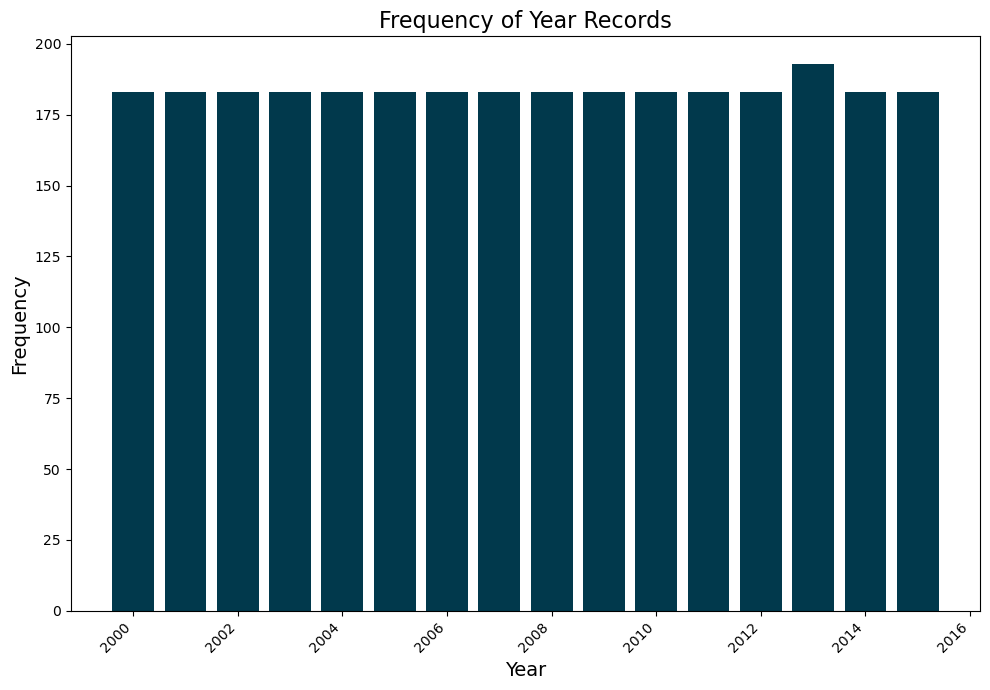

In [40]:
# Plotting the distribution of years
year_counts = lifeExpectancyDataframe['Year'].value_counts().reset_index()
year_counts.columns = ['Year', 'Frequency']

# Plot function
plot_bar(data=year_counts, 
         x_column='Year', 
         y_column='Frequency', 
         title="Frequency of Year Records", 
         xlabel="Year", 
         ylabel="Frequency", 
         color='#01394c', 
         orientation='vertical')

As can be noticed from the figure the recordes in the year 2014 are set to be the highest, while the rest of the years has same number of records. 

In [42]:
lifeExpectancyDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int16  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

### Column three: 

In [44]:
# investigating the data of the column 
lifeExpectancyDataframe['Life expectancy'].head(10)

0    46.0
1    68.3
2    63.9
3    52.7
4    48.9
5    57.3
6    55.4
7    51.9
8    55.0
9    64.1
Name: Life expectancy, dtype: float64

From the cell above we can see that the column contains some non-real numbers or float numbers as a start I will not turn it into int values. 

In [46]:
# checking for missing items and their count
print("Nan values sum: "+str(lifeExpectancyDataframe['Life expectancy'].isna().sum()))

Nan values sum: 10


In [47]:
# Investigating the data statically 
lifeExpectancyDataframe['Life expectancy'].describe()

count    2928.000000
mean       69.224932
std         9.523867
min        36.300000
25%        63.100000
50%        72.100000
75%        75.700000
max        89.000000
Name: Life expectancy, dtype: float64

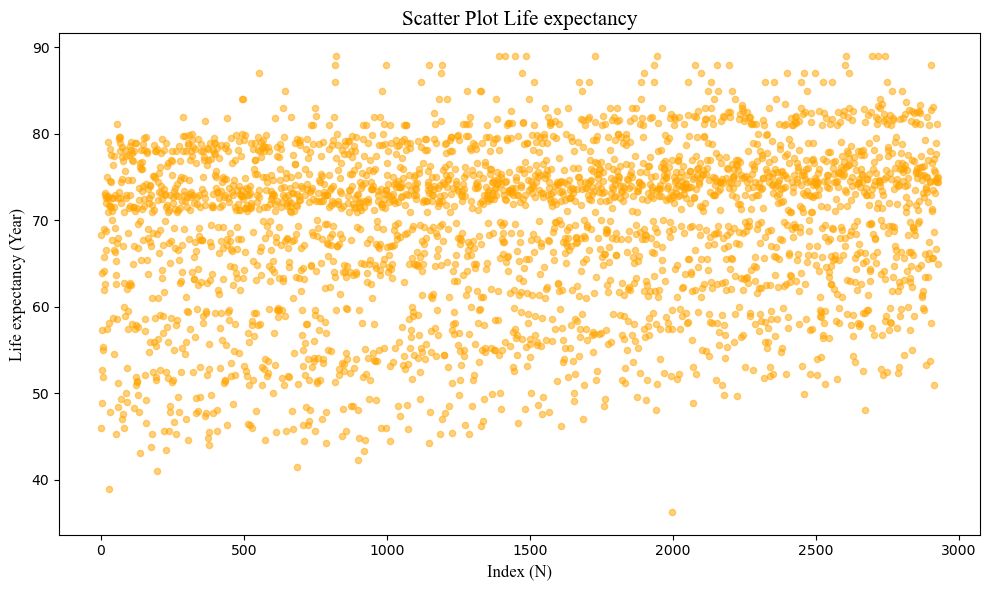

In [48]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Life expectancy'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Life expectancy', xlabel='Index (N)', ylabel='Life expectancy (Year)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

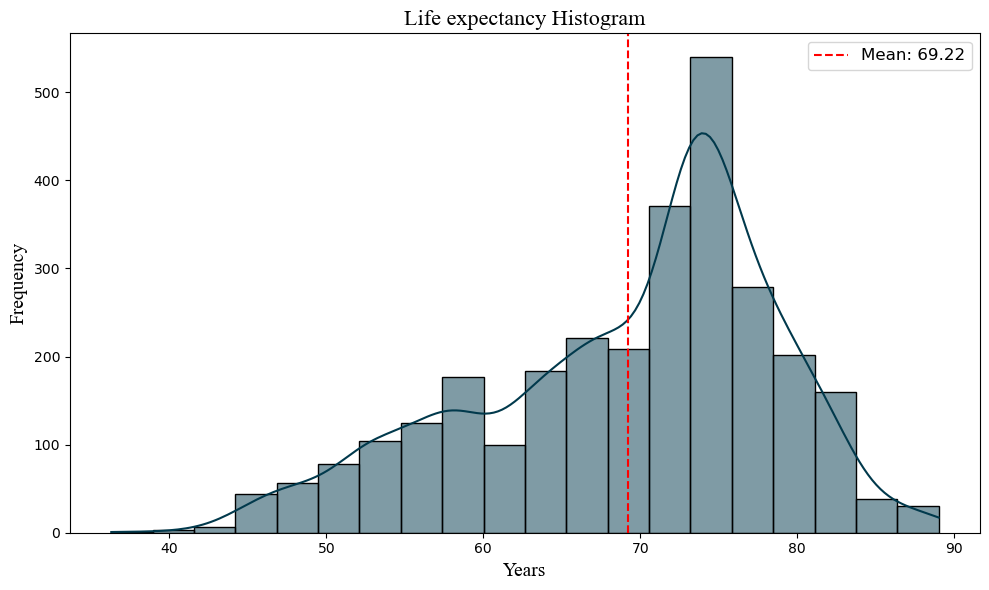

In [49]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Life expectancy'], errors='coerce').dropna()

plot_histogram(Data, title='Life expectancy Histogram', xlabel='Years', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman')

From the plot above we can see the average of life expectancy is around 69 years, and the most frequent value is around 75 years with a low thresholds of 89 and 36.
The previous cell a general understanding to the distribution of the data can be generated as following, the min age in the dataset is aproximatly _36_ years and the highest is _89_ years with an avg of _69_ pointing to a normal life expectancy.

In [51]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Life expectancy']= lifeExpectancyDataframe['Life expectancy'].astype('float32')

### Column four: 

In [53]:
# checking for missing items and their count
print("Nan values sum: "+str(lifeExpectancyDataframe['Status'].isna().sum()))

Nan values sum: 0


In [54]:
# Investigating the feature enteries 
print("Nan values sum: "+str(lifeExpectancyDataframe['Status'].isna().sum()))

Nan values sum: 0


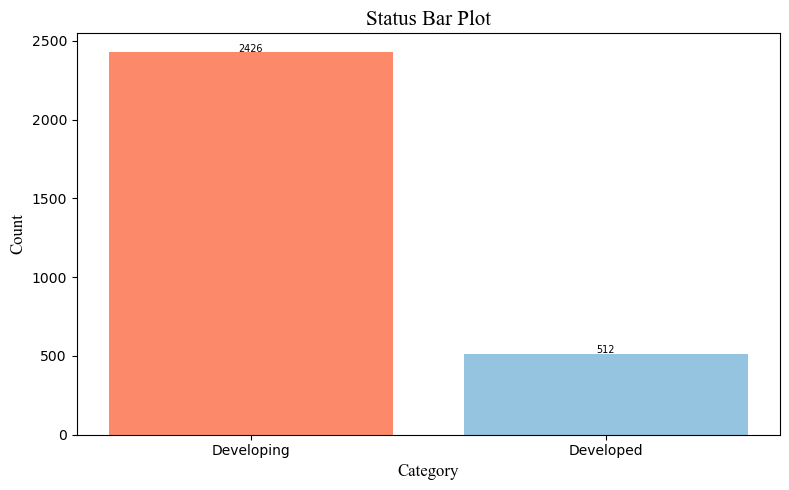

In [55]:
# Bar plot plotting
Data = lifeExpectancyDataframe['Status'].value_counts()
labels = Data.index
Data = Data.values

plot_categorical_bar(Data, labels, title='Status Bar Plot', xlabel='Category', ylabel='Count',
                     colors=None, fontname='Times New Roman', figsize=(8, 5), 
                     label_fontsize=12, title_fontsize=15, value_fontsize=7, 
                     text_offset=5)

From the figure above we can notice the numbers of developing countries is larger by four times than the developed countries pointing to more poor communities.

In [57]:
# Changing the type into category to save more space and arrange the data better
lifeExpectancyDataframe['Status'] = lifeExpectancyDataframe['Status'].astype('category')

### Column five: 

In [59]:
# investigating the data of the column 
lifeExpectancyDataframe['Adult Mortality'].head(10)

0    665.0
1    196.0
2    292.0
3    336.0
4     38.0
5    397.0
6    279.0
7    428.0
8    355.0
9    222.0
Name: Adult Mortality, dtype: float64

In [60]:
# checking for missing items and their count
print("Nan values sum: "+str(lifeExpectancyDataframe['Adult Mortality'].isna().sum()))

Nan values sum: 10


In [61]:
# Investigating the data statically 
lifeExpectancyDataframe['Adult Mortality'].describe()

count    2928.000000
mean      164.796448
std       124.292079
min         1.000000
25%        74.000000
50%       144.000000
75%       228.000000
max       723.000000
Name: Adult Mortality, dtype: float64

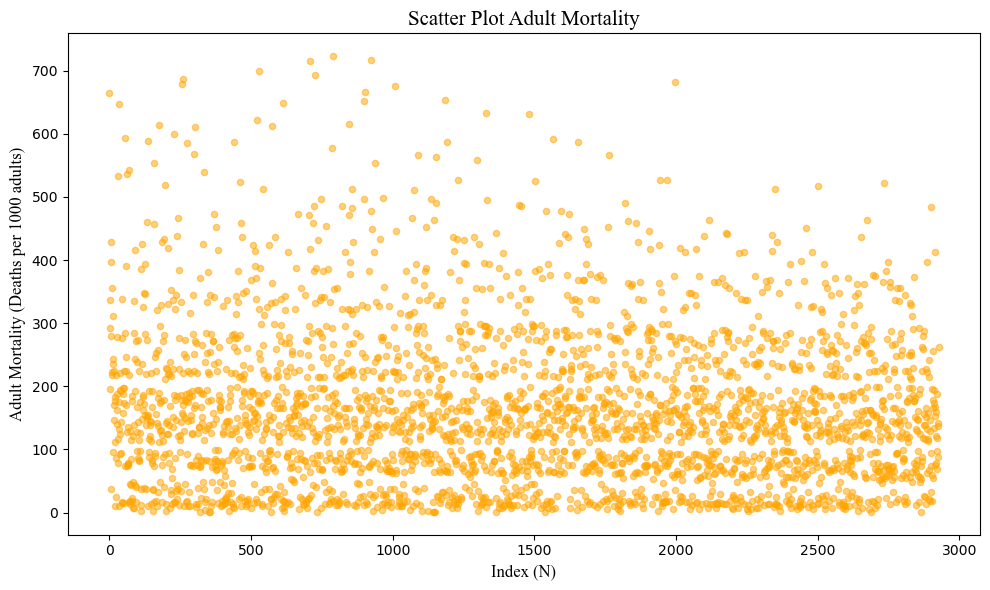

In [62]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Adult Mortality'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Adult Mortality', xlabel='Index (N)', ylabel='Adult Mortality (Deaths per 1000 adults)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

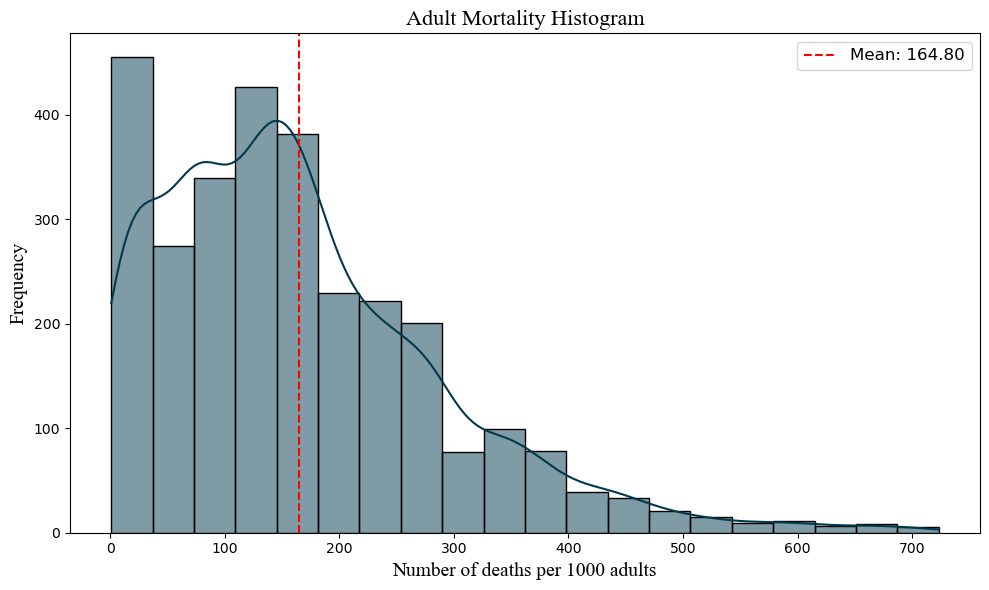

In [63]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Adult Mortality'], errors='coerce').dropna()

plot_histogram(Data, title='Adult Mortality Histogram', xlabel='Number of deaths per 1000 adults', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman')

From the figure above we can notice that the data is more skweed to the right side, with mean of 164.8 and low high values. The feature renders the numbers of people how dies from the X to Y for each _1000_ person. Based on the relative fact we can say the some countries have high death rates but the frequency of the countires is low.  
As a comclusion the numbers of personal to die with in the range is a kind of low. 

In [65]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Adult Mortality']= lifeExpectancyDataframe['Adult Mortality'].astype('float32')

### Column six:

In [67]:
# Investigating the data of the column 
lifeExpectancyDataframe['infant deaths'].head(10)

0    24
1     0
2     9
3     3
4    31
5    51
6    25
7    77
8    45
9     0
Name: infant deaths, dtype: int64

In [68]:
# Renaming the feature
lifeExpectancyDataframe = lifeExpectancyDataframe.rename(columns={'infant deaths': 'Infant deaths'})

In [69]:
# checking for missing items and their count
print("Nan values sum: "+str(lifeExpectancyDataframe['Infant deaths'].isna().sum()))

Nan values sum: 0


In [70]:
# Investigating the data statically 
lifeExpectancyDataframe['Infant deaths'].describe()

count    2938.000000
mean       30.303948
std       117.926501
min         0.000000
25%         0.000000
50%         3.000000
75%        22.000000
max      1800.000000
Name: Infant deaths, dtype: float64

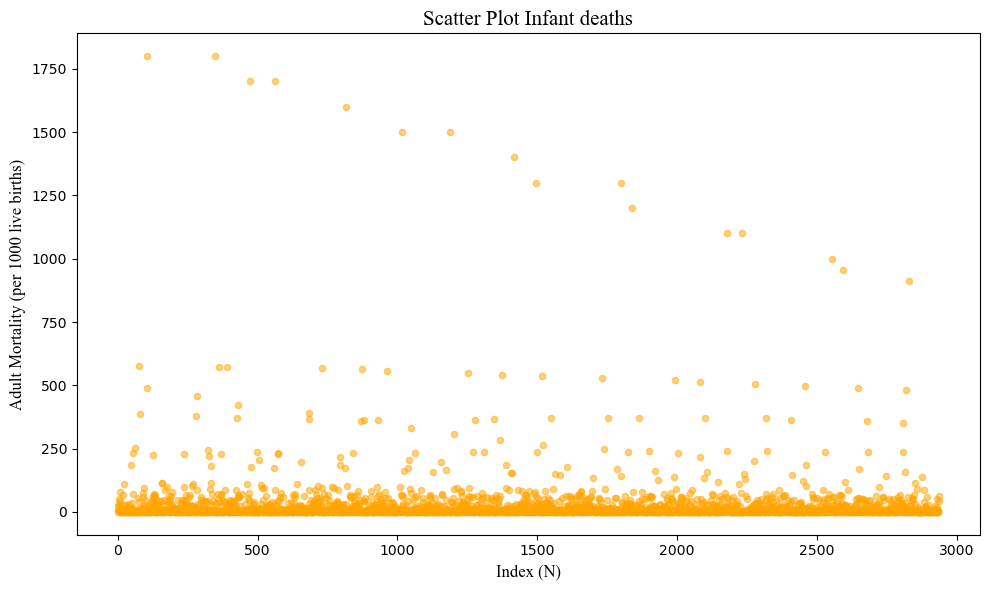

In [71]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Infant deaths'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Infant deaths', xlabel='Index (N)', ylabel='Adult Mortality (per 1000 live births)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

The measuring unit of the feature is the number of infant deaths per __1000__ live births, indicating a strong presence of outliers.

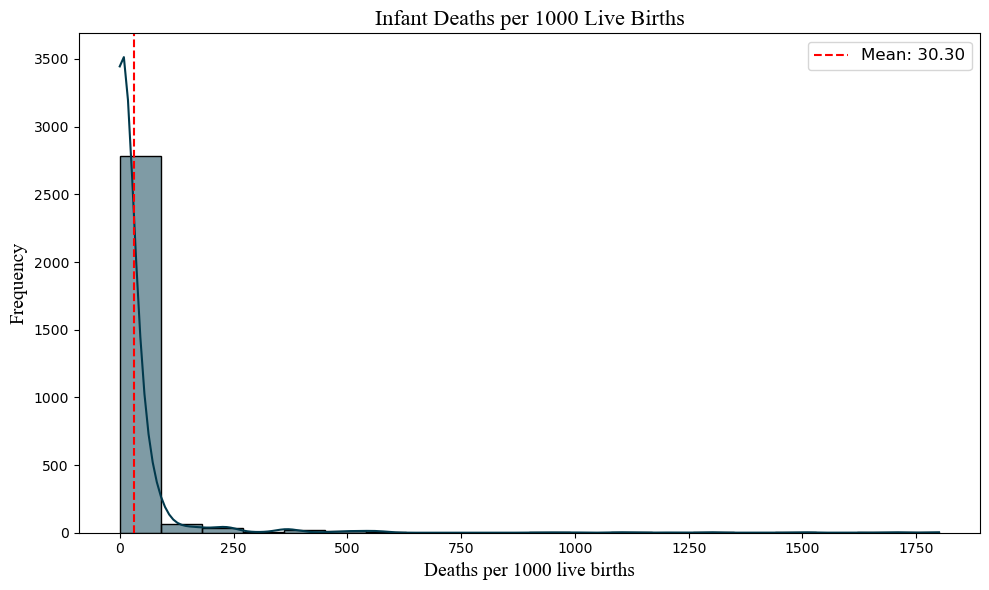

In [73]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Infant deaths'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Infant Deaths per 1000 Live Births',
               xlabel='Deaths per 1000 live births',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The previous plot shows possible outliers as the range maxed at 1000 and we have values exceeding the range of measuring. 

In [75]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Infant deaths']= lifeExpectancyDataframe['Infant deaths'].astype('float32')

### Column seven: 

In [77]:
# Renaming the feature
lifeExpectancyDataframe = lifeExpectancyDataframe.rename(columns={'Alcohol': 'Alcohol consumption'})

In [78]:
# Investigating the data of the column 
lifeExpectancyDataframe['Alcohol consumption'].head(10)

0    1.68
1    4.79
2    6.00
3    4.46
4     NaN
5    7.30
6    1.34
7    1.51
8    0.01
9    0.46
Name: Alcohol consumption, dtype: float64

In [79]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Alcohol consumption'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 194


In [80]:
# Suming the number of known values
data = lifeExpectancyDataframe['Alcohol consumption']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2744


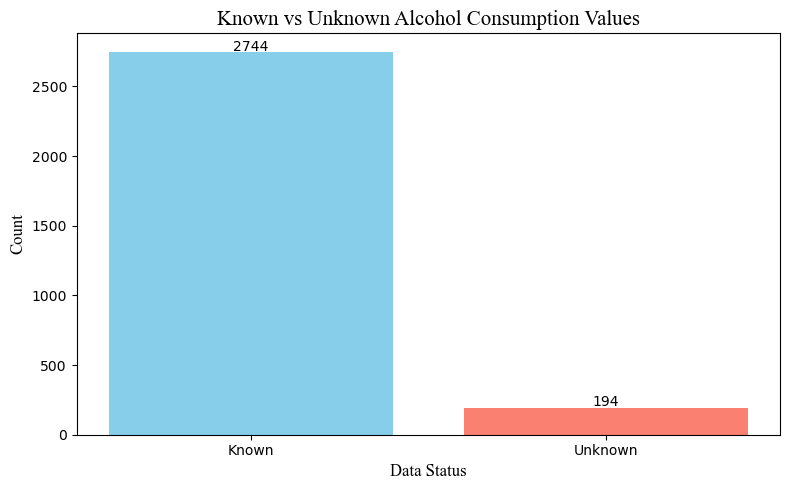

In [81]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Alcohol Consumption Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

In [82]:
# Investigating the data statically 
lifeExpectancyDataframe['Alcohol consumption'].describe()

count    2744.000000
mean        4.602861
std         4.052413
min         0.010000
25%         0.877500
50%         3.755000
75%         7.702500
max        17.870000
Name: Alcohol consumption, dtype: float64

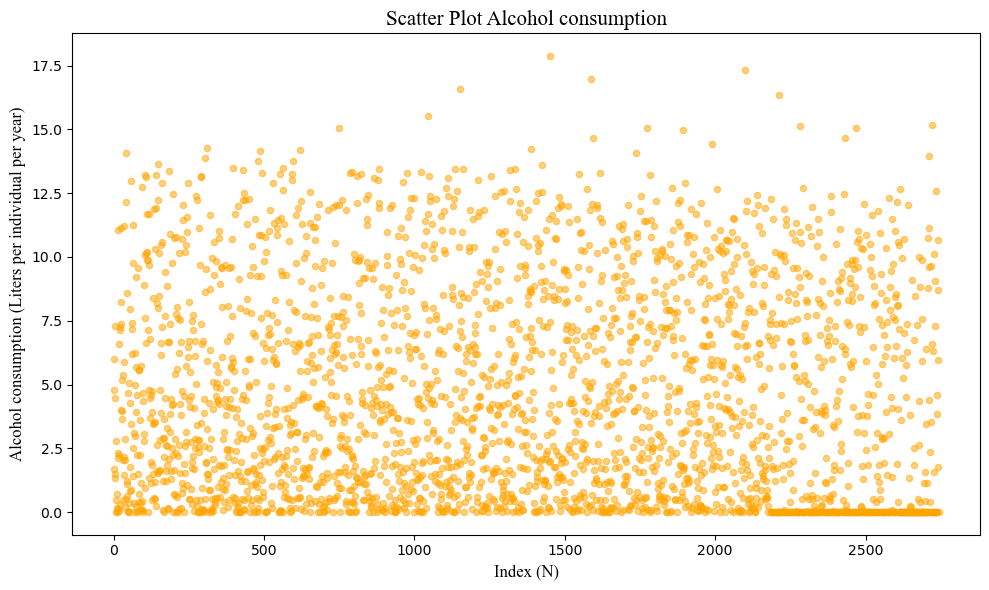

In [83]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Alcohol consumption'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Alcohol consumption', xlabel='Index (N)', ylabel='Alcohol consumption (Liters per individual per year)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

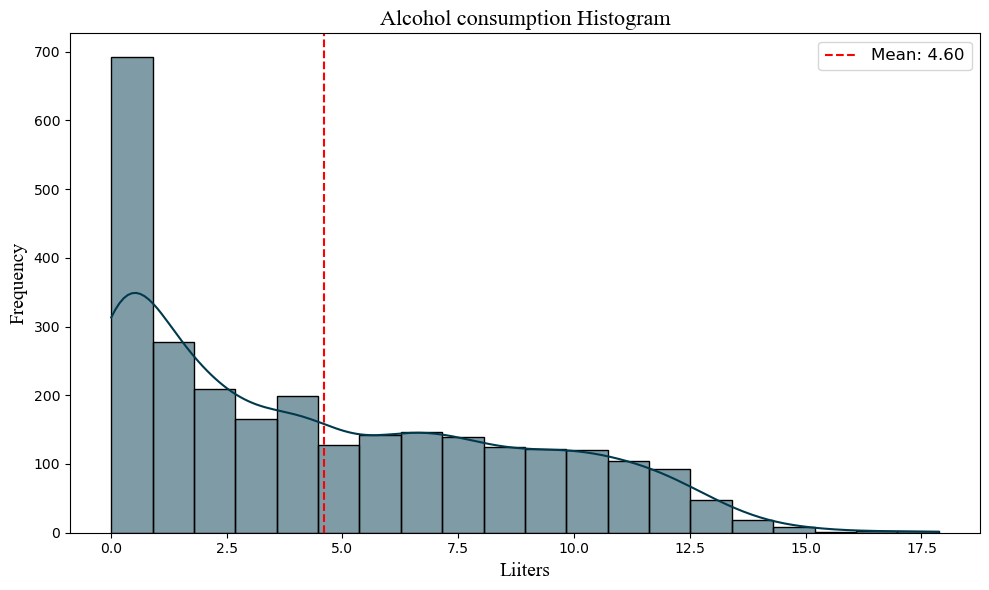

In [84]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Alcohol consumption'], errors='coerce').dropna()

plot_histogram(Data, title='Alcohol consumption Histogram', xlabel='Liiters', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman')

The previous plots shows a right skweeing and higher density of the data between the _0.0_ and _2.5_ with possible small number of outliers as well as a huge number of missing values. 

In [86]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 16 bit.
lifeExpectancyDataframe['Alcohol consumption']= lifeExpectancyDataframe['Alcohol consumption'].astype('float32')

### Column eight

In [88]:
# Renaming the feature
lifeExpectancyDataframe = lifeExpectancyDataframe.rename(columns={'percentage expenditure': 'Percentage expenditure'})

In [89]:
# Investigating the data of the column 
lifeExpectancyDataframe['Percentage expenditure'].head(10)

0      0.000000
1    219.023984
2    112.541157
3     14.954513
4      0.000000
5     45.963808
6     37.381820
7      0.681686
8      0.000000
9     11.075433
Name: Percentage expenditure, dtype: float64

In [90]:
# checking for missing items and their count
print("Nan values sum: " + str(lifeExpectancyDataframe['Percentage expenditure'].isna().sum()))

Nan values sum: 0


In [91]:
# Investigating the data statically 
lifeExpectancyDataframe['Percentage expenditure'].describe()

count     2938.000000
mean       738.251295
std       1987.914858
min          0.000000
25%          4.685343
50%         64.912906
75%        441.534144
max      19479.911610
Name: Percentage expenditure, dtype: float64

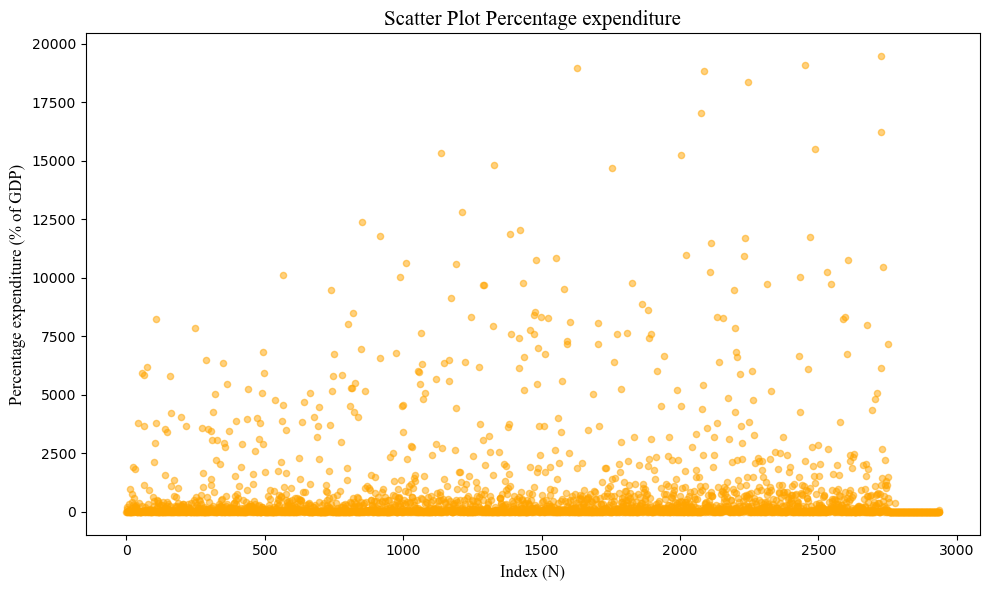

In [92]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Percentage expenditure'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Percentage expenditure', xlabel='Index (N)', ylabel='Percentage expenditure (% of GDP)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

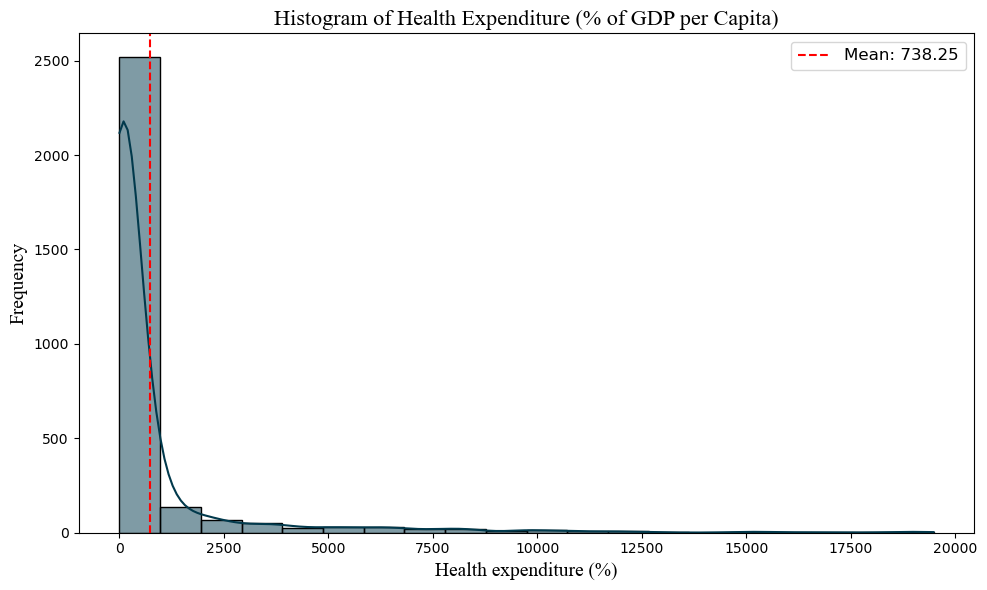

In [93]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Percentage expenditure'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Health Expenditure (% of GDP per Capita)',
               xlabel='Health expenditure (%)',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

the previous figure points to a high right skewed data with possible outliers and high density of data between _0-2500_. 

In [95]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 16 bit.
lifeExpectancyDataframe['Percentage expenditure']= lifeExpectancyDataframe['Percentage expenditure'].astype('float32')

### Column nine:

In [97]:
# Investigating the data of the column 
lifeExpectancyDataframe['Hepatitis B'].head(10) 

0    79.0
1    76.0
2    99.0
3     NaN
4     NaN
5    73.0
6     NaN
7     NaN
8     NaN
9     9.0
Name: Hepatitis B, dtype: float64

In [98]:
# Investigating the data statically
lifeExpectancyDataframe['Hepatitis B'].describe()

count    2385.000000
mean       80.940461
std        25.070016
min         1.000000
25%        77.000000
50%        92.000000
75%        97.000000
max        99.000000
Name: Hepatitis B, dtype: float64

In [99]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Hepatitis B'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 553


In [100]:
# Suming the number of known values
data = lifeExpectancyDataframe['Hepatitis B']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2385


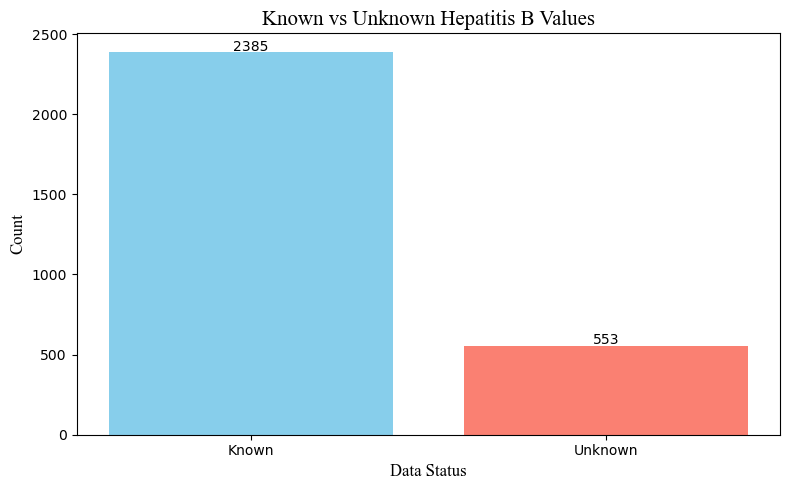

In [101]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Hepatitis B Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

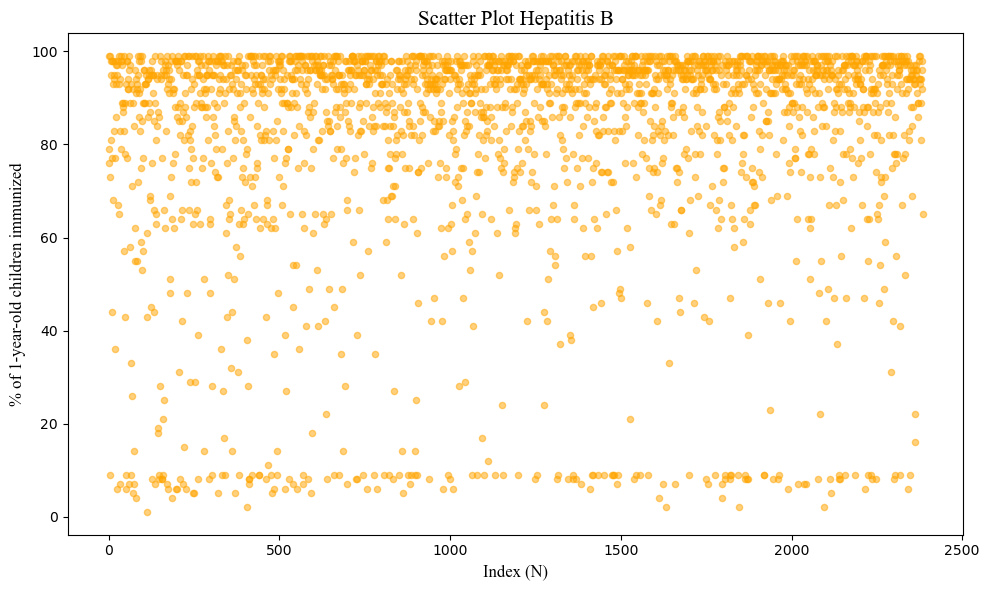

In [102]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Hepatitis B'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Hepatitis B', xlabel='Index (N)', ylabel='% of 1-year-old children immunized',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

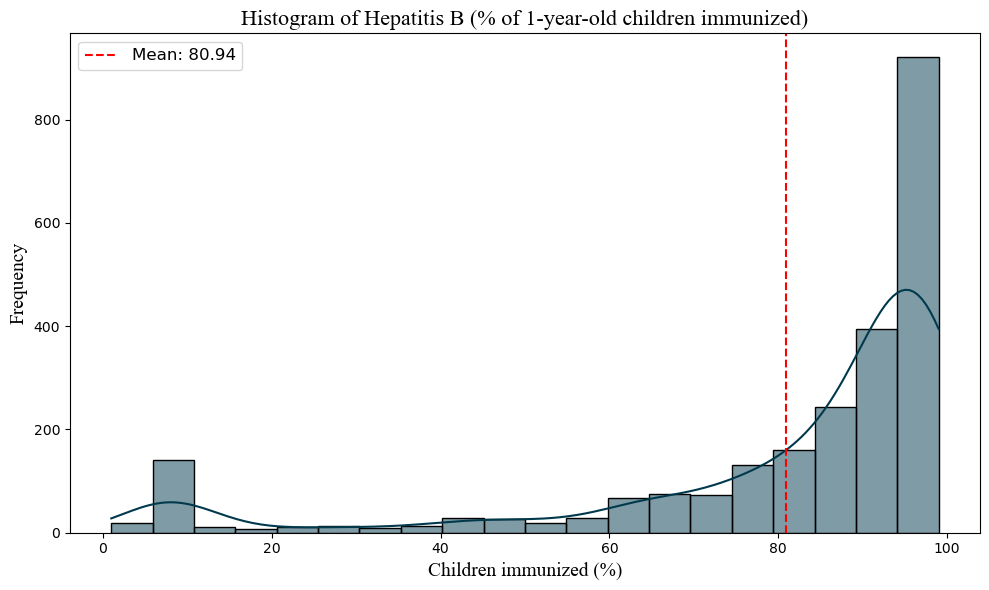

In [103]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Hepatitis B'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Hepatitis B (% of 1-year-old children immunized)',
               xlabel='Children immunized (%)',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

From the figures above we can see the data is skewed more to the left, with high mean pointing to the high percentage of babies being immunized.

In [105]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 16 bit.
lifeExpectancyDataframe['Hepatitis B']= lifeExpectancyDataframe['Hepatitis B'].astype('float32')

### Column ten: 

In [107]:
# Investigating the data of the column 
lifeExpectancyDataframe['Measles'].head(10)

0     1483
1        0
2      245
3        0
4        0
5     1459
6     4244
7    21002
8     3965
9        0
Name: Measles, dtype: int64

In [108]:
# Investigating the data statically
lifeExpectancyDataframe['Measles'].describe()

count      2938.000000
mean       2419.592240
std       11467.272489
min           0.000000
25%           0.000000
50%          17.000000
75%         360.250000
max      212183.000000
Name: Measles, dtype: float64

In [109]:
# checking for missing items and their count
print("Nan values sum: " + str(lifeExpectancyDataframe['Measles'].isna().sum()))

Nan values sum: 0


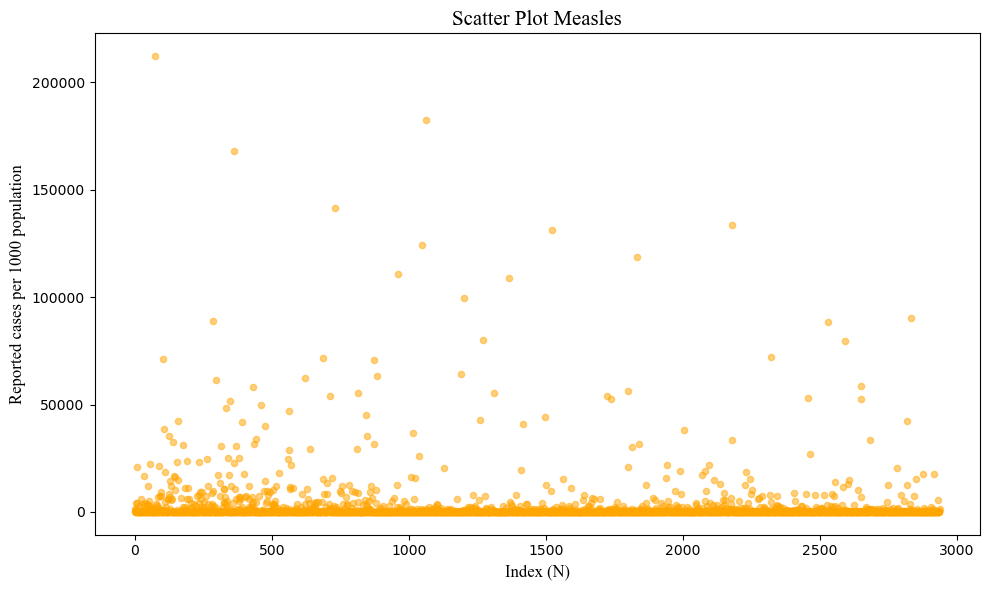

In [110]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Measles'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Measles', xlabel='Index (N)', ylabel='Reported cases per 1000 population',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

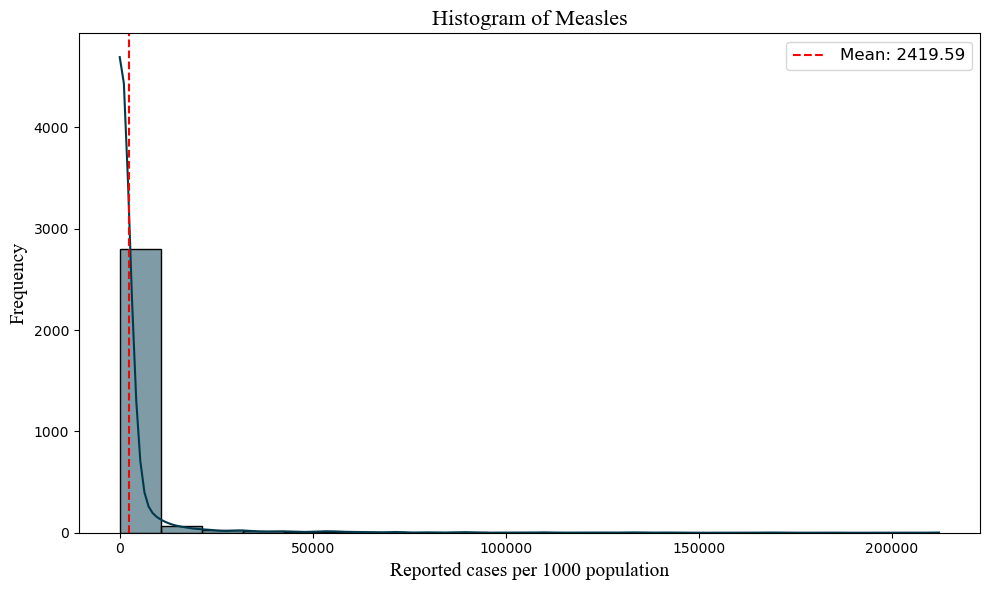

In [111]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Measles'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Measles',
               xlabel='Reported cases per 1000 population',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The previous figures indicates possible outliers, and the data looks more skewed to the right side. 

In [113]:
# The data will be stored as int but to save more memory and refrence to the range we are working with the size will be reduced to 16 bit.
lifeExpectancyDataframe['Measles']= lifeExpectancyDataframe['Measles'].astype('uint16')

### Column eleven:

In [115]:
# Investigating the data of the column 
lifeExpectancyDataframe['BMI'].head(10)

0    25.5
1     4.8
2    43.9
3    18.3
4     NaN
5     4.1
6    18.4
7    14.4
8    17.8
9    67.9
Name: BMI, dtype: float64

In [116]:
# Investigating the data statically
lifeExpectancyDataframe['BMI'].describe()

count    2904.000000
mean       38.321247
std        20.044034
min         1.000000
25%        19.300000
50%        43.500000
75%        56.200000
max        87.300000
Name: BMI, dtype: float64

In [117]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['BMI'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 34


In [118]:
# Suming the number of known values
data = lifeExpectancyDataframe['BMI']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2904


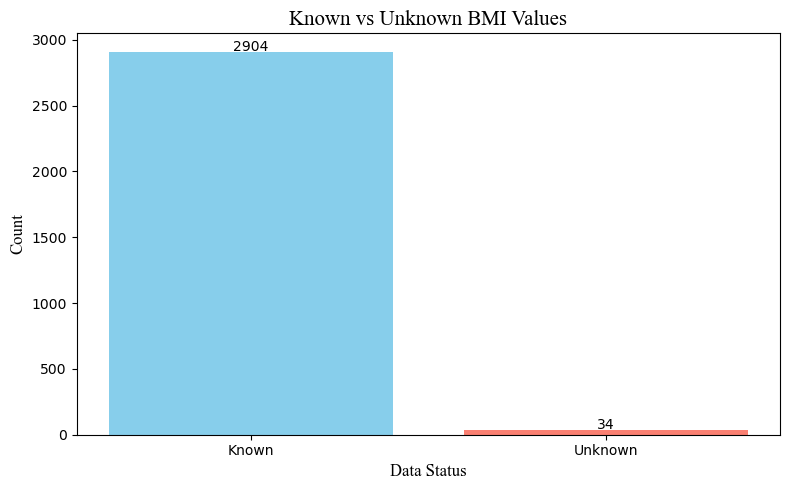

In [119]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown BMI Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

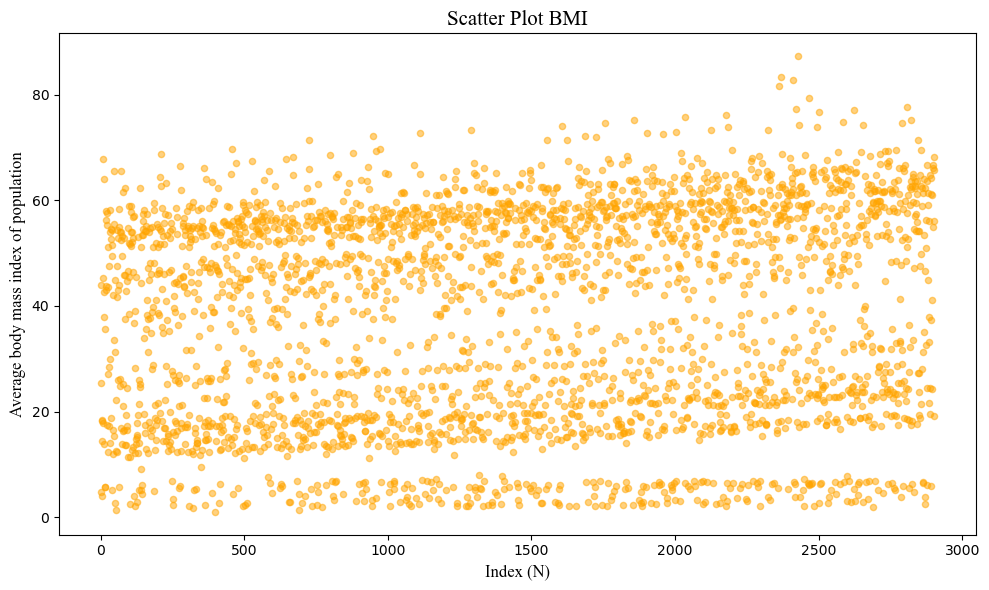

In [120]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['BMI'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot BMI', xlabel='Index (N)', ylabel='Average body mass index of population',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

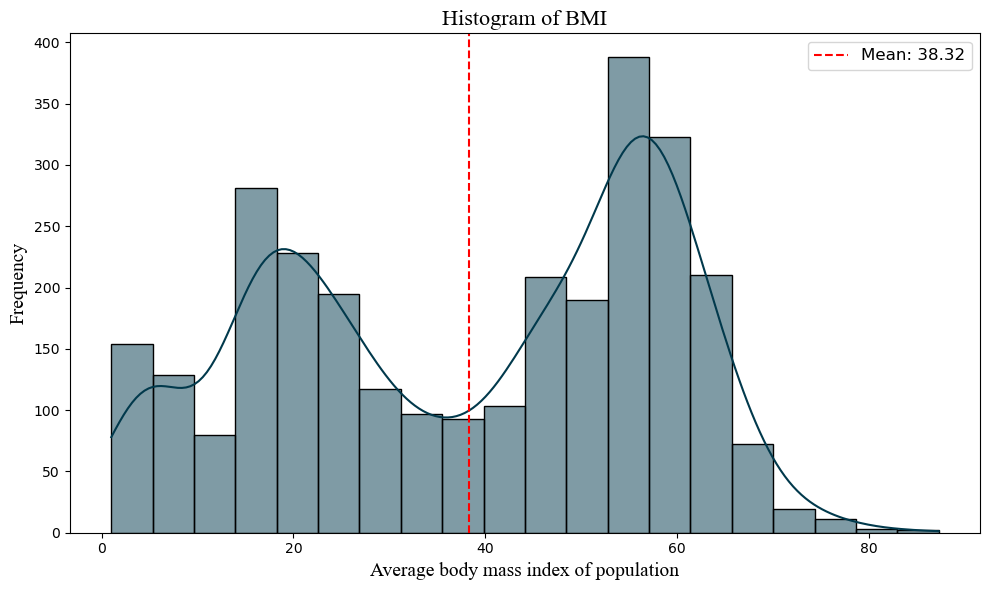

In [121]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['BMI'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of BMI',
               xlabel='Average body mass index of population',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The distribution of the data is not fully nature making the reading of the trend or locate the outlaires more chalinging. 

In [123]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['BMI']= lifeExpectancyDataframe['BMI'].astype('float32')

### Column twelve 

In [125]:
# Renaming the feature
lifeExpectancyDataframe = lifeExpectancyDataframe.rename(columns={'under-five deaths': 'Death numbers under-five'})

In [126]:
# Investigating the data of the column 
lifeExpectancyDataframe['Death numbers under-five'].head(10)

0     39
1      0
2     10
3      4
4     50
5     73
6     40
7    121
8     74
9      0
Name: Death numbers under-five, dtype: int64

In [127]:
# Investigating the data statically
lifeExpectancyDataframe['Death numbers under-five'].describe()

count    2938.000000
mean       42.035739
std       160.445548
min         0.000000
25%         0.000000
50%         4.000000
75%        28.000000
max      2500.000000
Name: Death numbers under-five, dtype: float64

In [128]:
# checking for missing items and their count
print("Nan values sum: " + str(lifeExpectancyDataframe['Death numbers under-five'].isna().sum()))

Nan values sum: 0


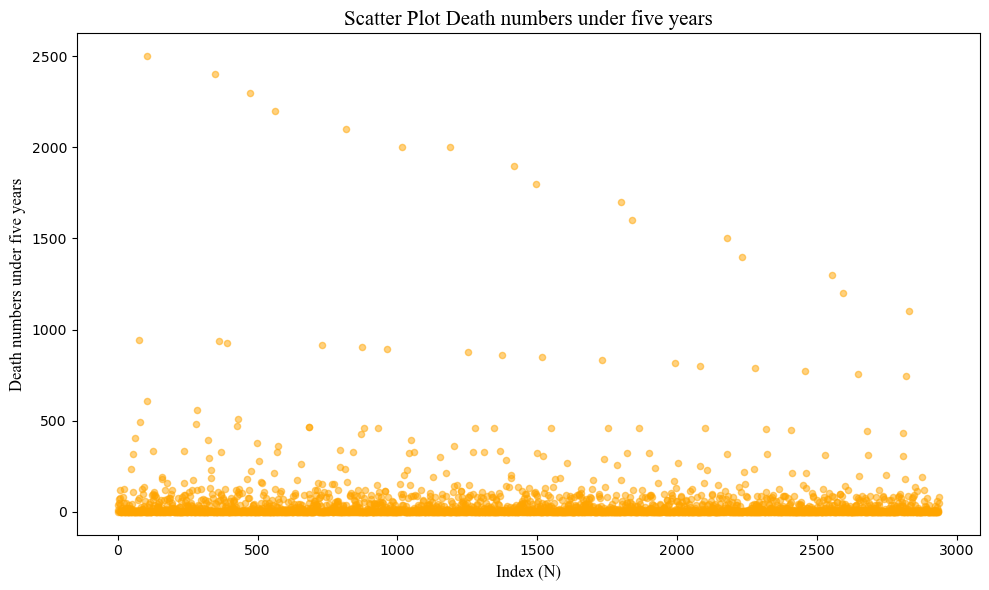

In [129]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Death numbers under-five'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Death numbers under five years', xlabel='Index (N)', ylabel='Death numbers under five years',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

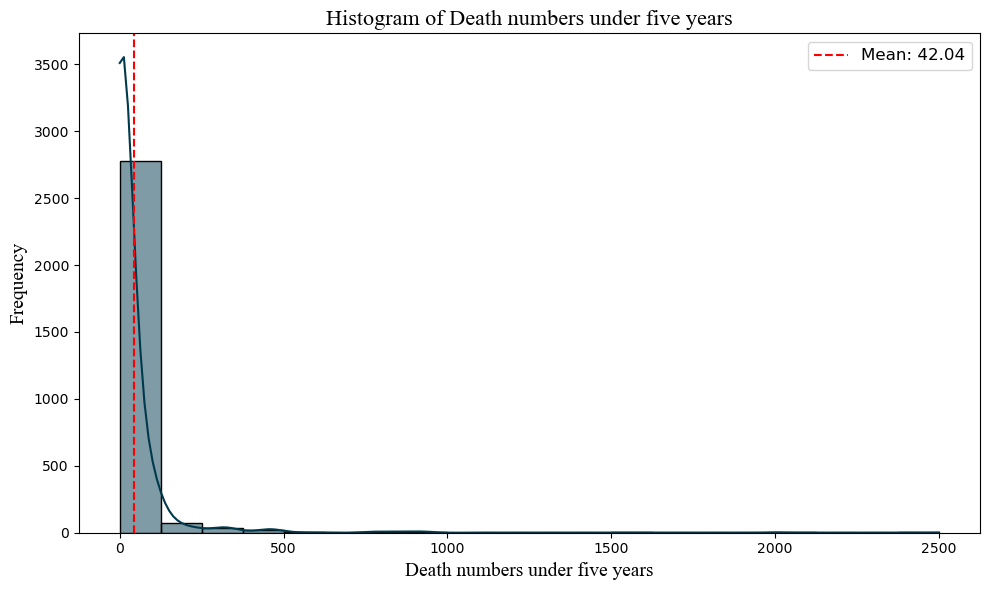

In [130]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Death numbers under-five'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Death numbers under five years',
               xlabel='Death numbers under five years',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

In [131]:
# The data will be stored as int but to save more memory and refrence to the range we are working with the size will be reduced to 16 bit.
lifeExpectancyDataframe['Death numbers under-five']= lifeExpectancyDataframe['Death numbers under-five'].astype('uint16')

The data is skewed more to the right side with higher data concentration in the lower levels roughly between _zero_ and _five hundred_, also the high values of death points into possible outliers. 

### Column thirteen:

In [134]:
# Renaming the feature
lifeExpectancyDataframe = lifeExpectancyDataframe.rename(columns={'Polio': 'Polio disease'})

In [135]:
# Investigating the data of the column 
lifeExpectancyDataframe['Polio disease'].head(10)

0    78.0
1    91.0
2    96.0
3    41.0
4     NaN
5    71.0
6    78.0
7     8.0
8    37.0
9     9.0
Name: Polio disease, dtype: float64

In [136]:
# Investigating the data statically
lifeExpectancyDataframe['Polio disease'].describe()

count    2919.000000
mean       82.550188
std        23.428046
min         3.000000
25%        78.000000
50%        93.000000
75%        97.000000
max        99.000000
Name: Polio disease, dtype: float64

In [137]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Polio disease'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 19


In [138]:
# Suming the number of known values
data = lifeExpectancyDataframe['Polio disease']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2919


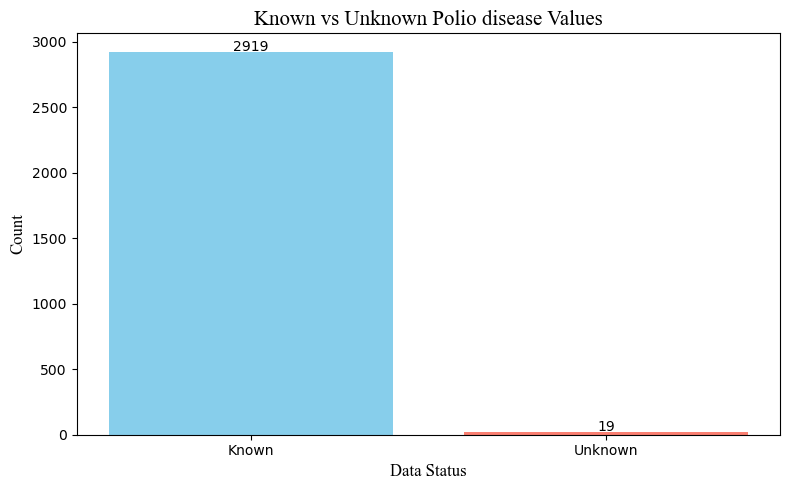

In [139]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Polio disease Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

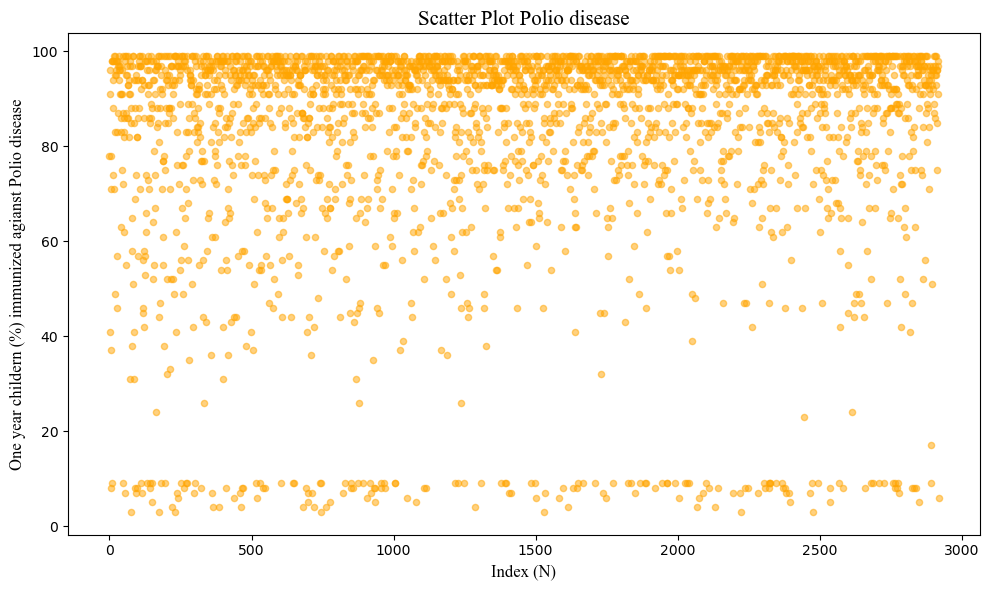

In [140]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Polio disease'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Polio disease', xlabel='Index (N)', ylabel='One year childern (%) immunized agianst Polio disease',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

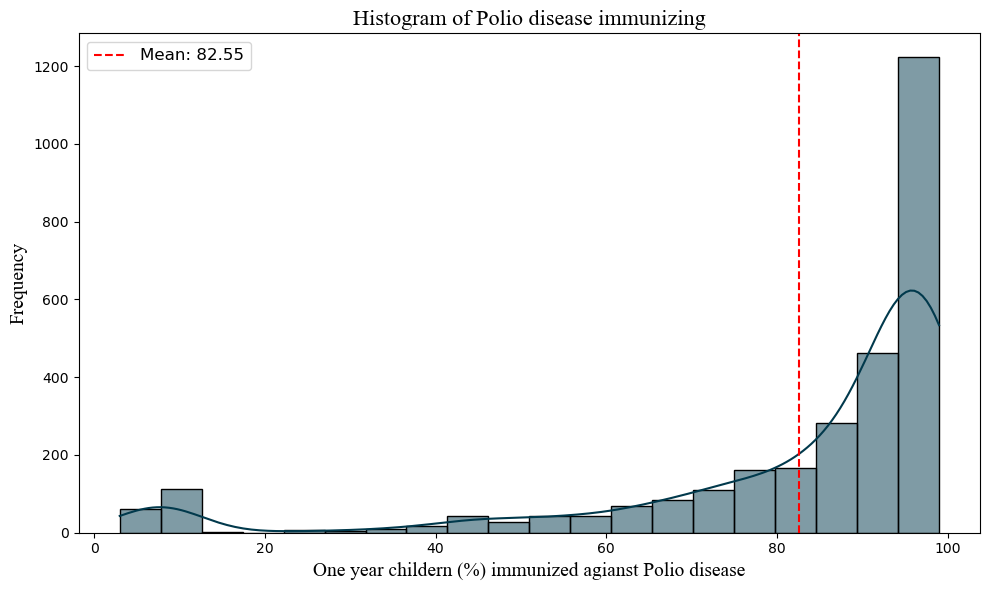

In [141]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Polio disease'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Polio disease immunizing',
               xlabel='One year childern (%) immunized agianst Polio disease',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The previous figures indicates a huge numbers of children's to be imuzed against the disease with a mean of _82.55_ as well as skewering more to the left. Indicating an overall good health care system. 

In [143]:
# The data will be stored as int but to save more memory and refrence to the range we are working with the size will be reduced to 16 bit.
lifeExpectancyDataframe['Death numbers under-five']= lifeExpectancyDataframe['Death numbers under-five'].astype('uint16')

### Column fourteen

In [145]:
# Investigating the data of the column 
lifeExpectancyDataframe['Total expenditure'].head(10)

0    7.10
1    3.98
2    4.16
3    2.73
4     NaN
5    8.70
6    4.34
7    4.68
8     NaN
9    8.12
Name: Total expenditure, dtype: float64

In [146]:
# Investigating the data statically
lifeExpectancyDataframe['Total expenditure'].describe()

count    2712.00000
mean        5.93819
std         2.49832
min         0.37000
25%         4.26000
50%         5.75500
75%         7.49250
max        17.60000
Name: Total expenditure, dtype: float64

In [147]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Total expenditure'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 226


In [148]:
# Suming the number of known values
data = lifeExpectancyDataframe['Total expenditure']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2712


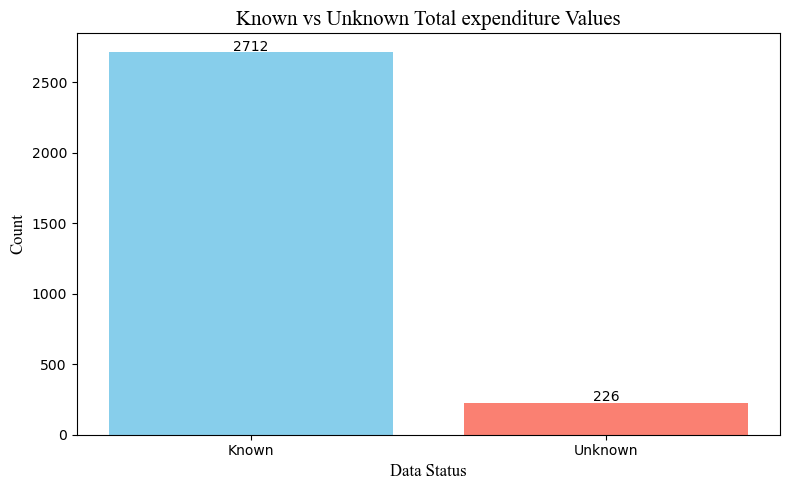

In [149]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Total expenditure Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

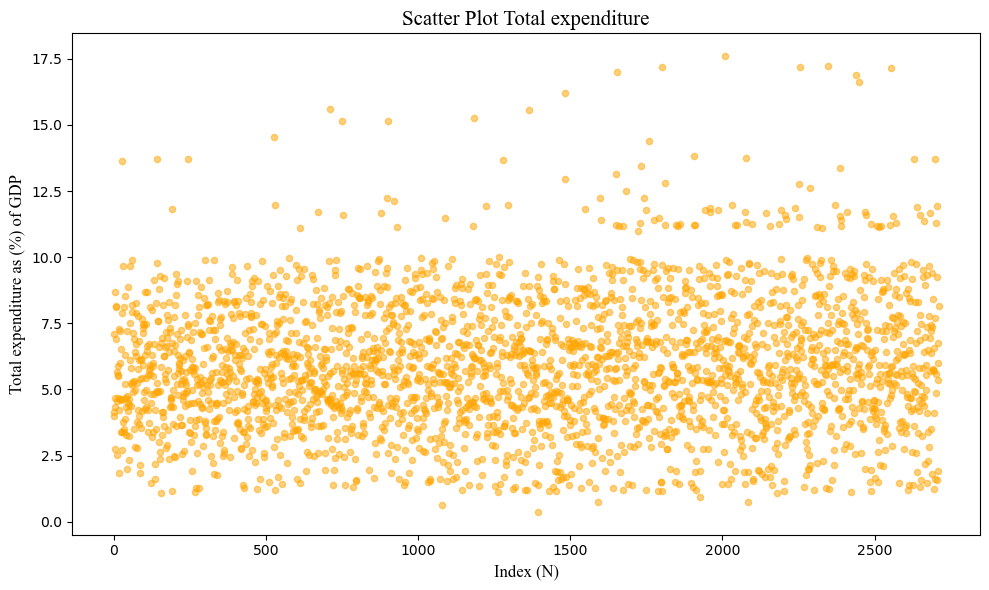

In [150]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Total expenditure'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Total expenditure', xlabel='Index (N)', ylabel='Total expenditure as (%) of GDP',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

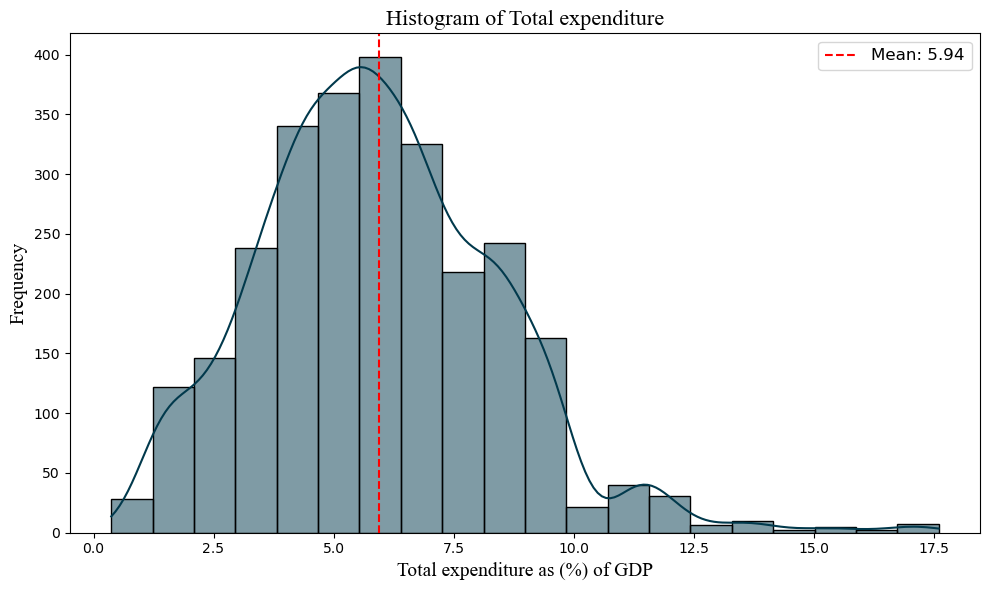

In [151]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Total expenditure'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Total expenditure',
               xlabel='Total expenditure as (%) of GDP',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is roughly distributed normally with high range values and maybe low number of outliers. 

In [153]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Total expenditure']= lifeExpectancyDataframe['Total expenditure'].astype('float32')

### Column fifteen: 

In [155]:
# Investigating the data of the column 
lifeExpectancyDataframe['Diphtheria'].head(10)

0    78.0
1    91.0
2    97.0
3    34.0
4     NaN
5    73.0
6    78.0
7    82.0
8    33.0
9     9.0
Name: Diphtheria, dtype: float64

In [156]:
# Investigating the data statically
lifeExpectancyDataframe['Diphtheria'].describe()

count    2919.000000
mean       82.324084
std        23.716912
min         2.000000
25%        78.000000
50%        93.000000
75%        97.000000
max        99.000000
Name: Diphtheria, dtype: float64

In [157]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Diphtheria'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 19


In [158]:
# Suming the number of known values
data = lifeExpectancyDataframe['Diphtheria']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2919


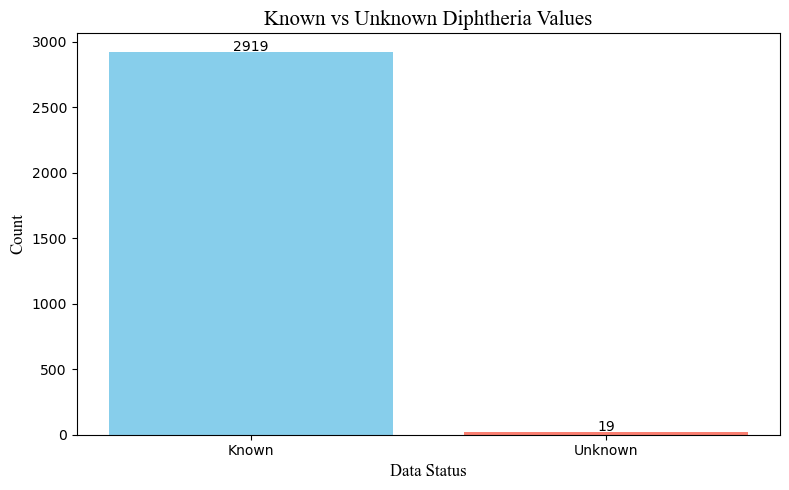

In [159]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Diphtheria Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

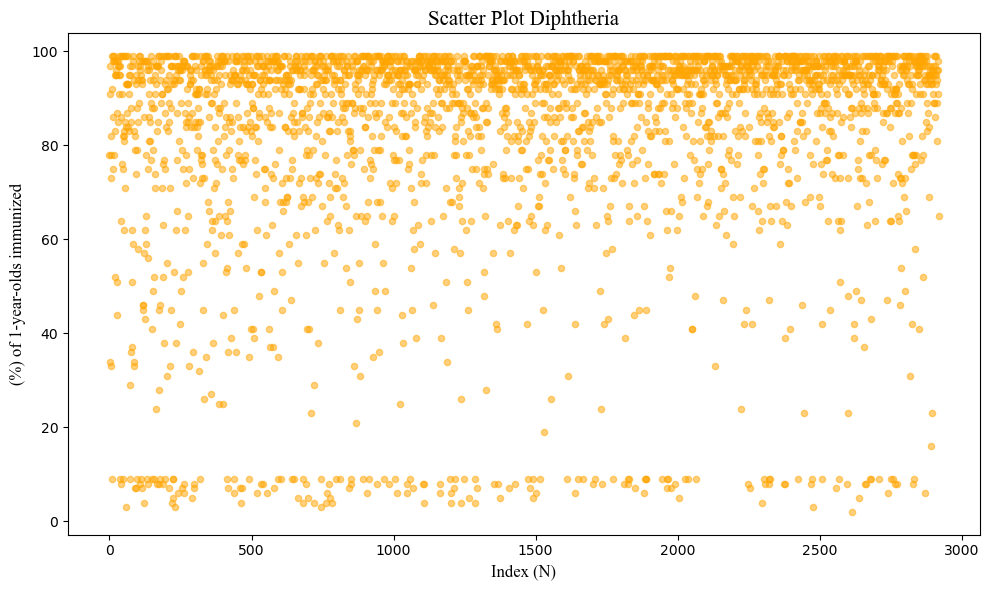

In [160]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Diphtheria'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Diphtheria', xlabel='Index (N)', ylabel='(%) of 1-year-olds immunized',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

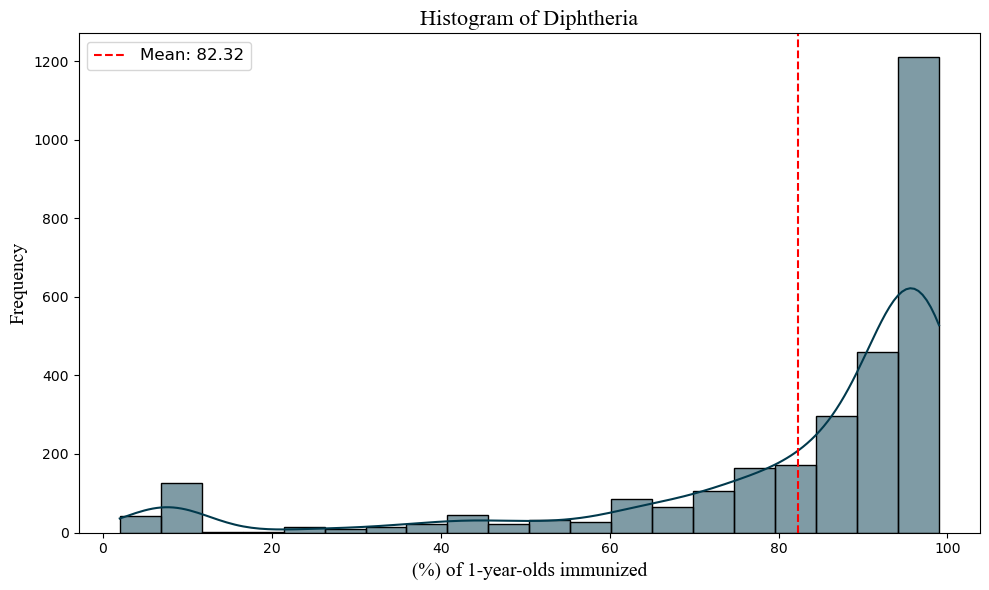

In [161]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Diphtheria'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Diphtheria',
               xlabel='(%) of 1-year-olds immunized',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

From the figures above we can see the data is skewed more to the left, with high mean pointing to the high percentage of elders being immunized.

In [163]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Diphtheria']= lifeExpectancyDataframe['Diphtheria'].astype('float32')

### Column sixteen: 

In [165]:
# Investigating the data of the column 
lifeExpectancyDataframe['HIV/AIDS'].head(10)

0    43.5
1     0.3
2     0.1
3     1.9
4     2.7
5    21.3
6     2.0
7    18.1
8     0.8
9     0.1
Name: HIV/AIDS, dtype: float64

In [166]:
# Investigating the data statically
lifeExpectancyDataframe['HIV/AIDS'].describe()

count    2938.000000
mean        1.742103
std         5.077785
min         0.100000
25%         0.100000
50%         0.100000
75%         0.800000
max        50.600000
Name: HIV/AIDS, dtype: float64

In [167]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['HIV/AIDS'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 0


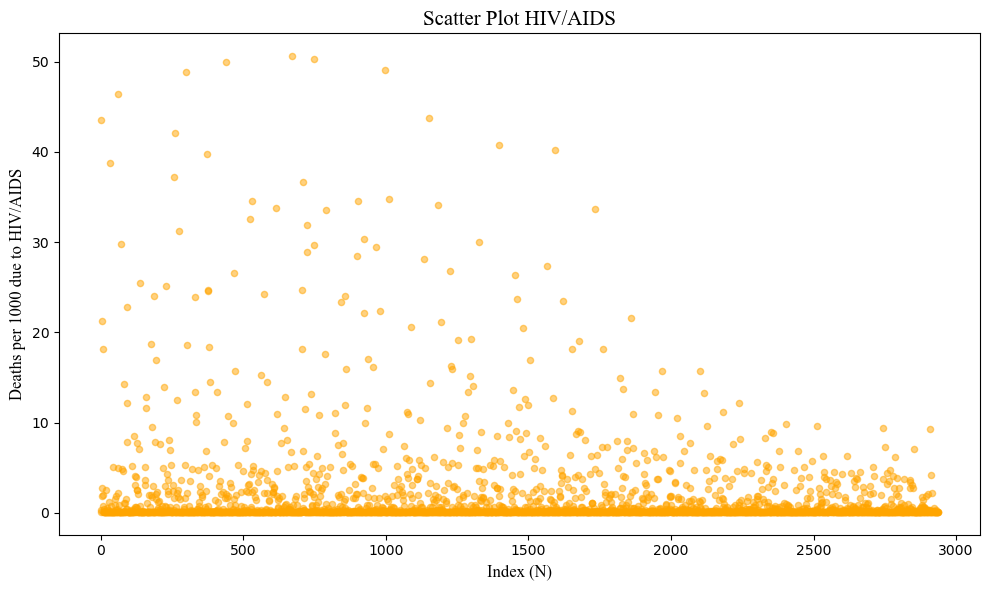

In [168]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['HIV/AIDS'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot HIV/AIDS', xlabel='Index (N)', ylabel='Deaths per 1000 due to HIV/AIDS',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

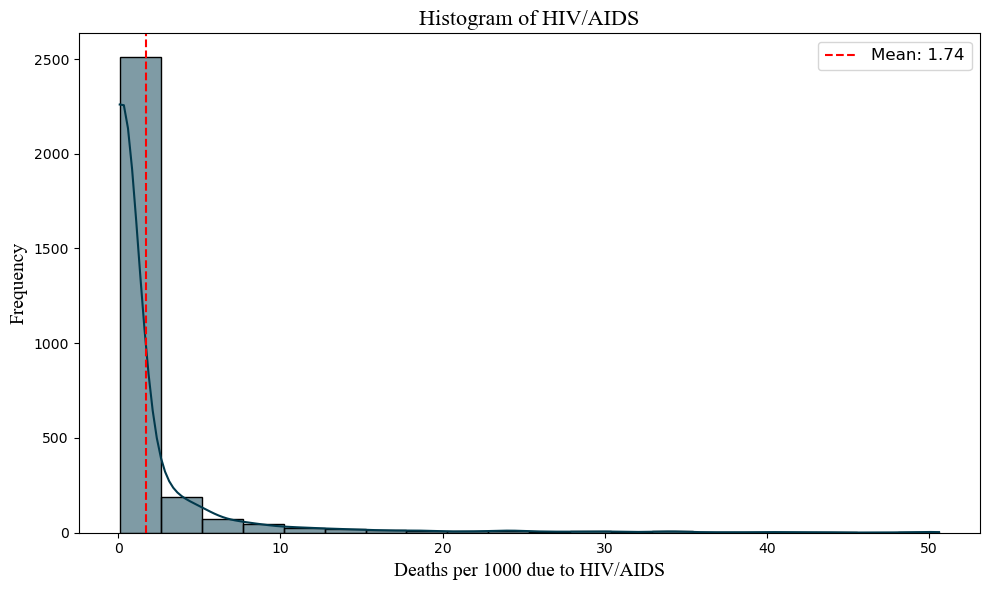

In [169]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['HIV/AIDS'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of HIV/AIDS',
               xlabel='Deaths per 1000 due to HIV/AIDS',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is more skewed to the right side and not distributed normally, possible outliers can be found and the majority of the data is around the mean. 

In [171]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['HIV/AIDS']= lifeExpectancyDataframe['HIV/AIDS'].astype('float32')

### Column seventine: 

In [173]:
# Investigating the data of the column 
lifeExpectancyDataframe['GDP'].head(10)

0     547.358878
1    3364.423711
2    1229.958000
3     172.684910
4            NaN
5     337.225300
6     374.192394
7      43.979713
8            NaN
9     796.793763
Name: GDP, dtype: float64

In [174]:
# Investigating the data statically
lifeExpectancyDataframe['GDP'].describe()

count      2490.000000
mean       7483.158469
std       14270.169342
min           1.681350
25%         463.935626
50%        1766.947595
75%        5910.806335
max      119172.741800
Name: GDP, dtype: float64

In [175]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['GDP'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 448


In [176]:
# Suming the number of known values
data = lifeExpectancyDataframe['GDP']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2490


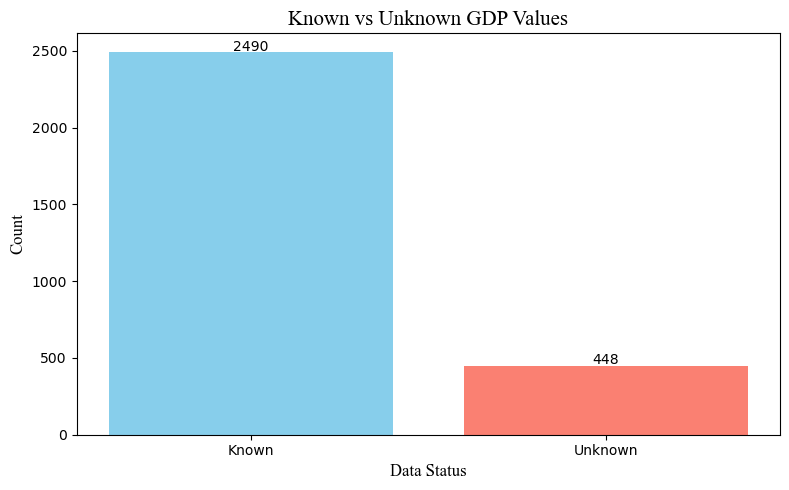

In [177]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown GDP Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

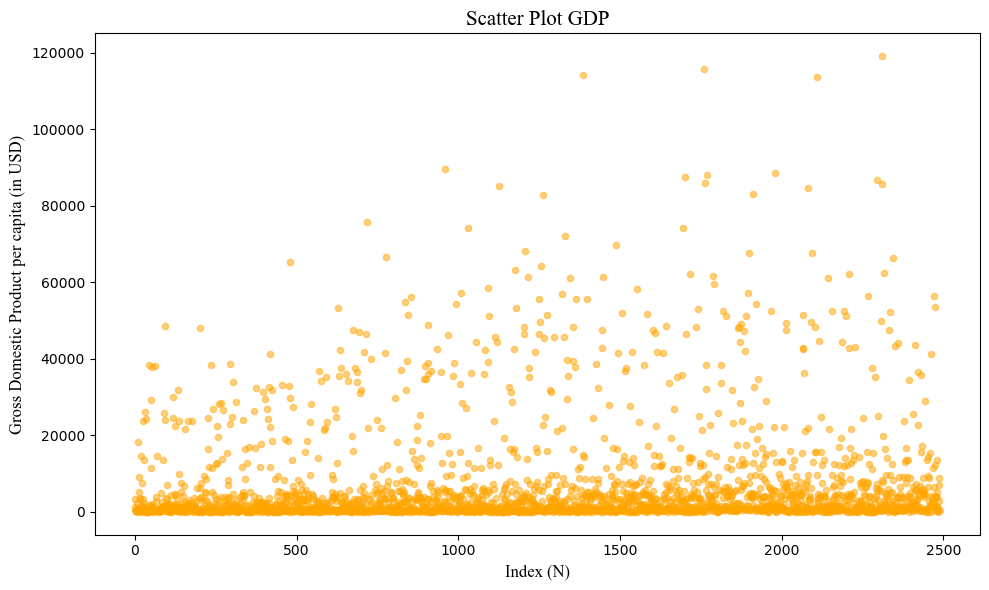

In [178]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['GDP'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot GDP', xlabel='Index (N)', ylabel='Gross Domestic Product per capita (in USD)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

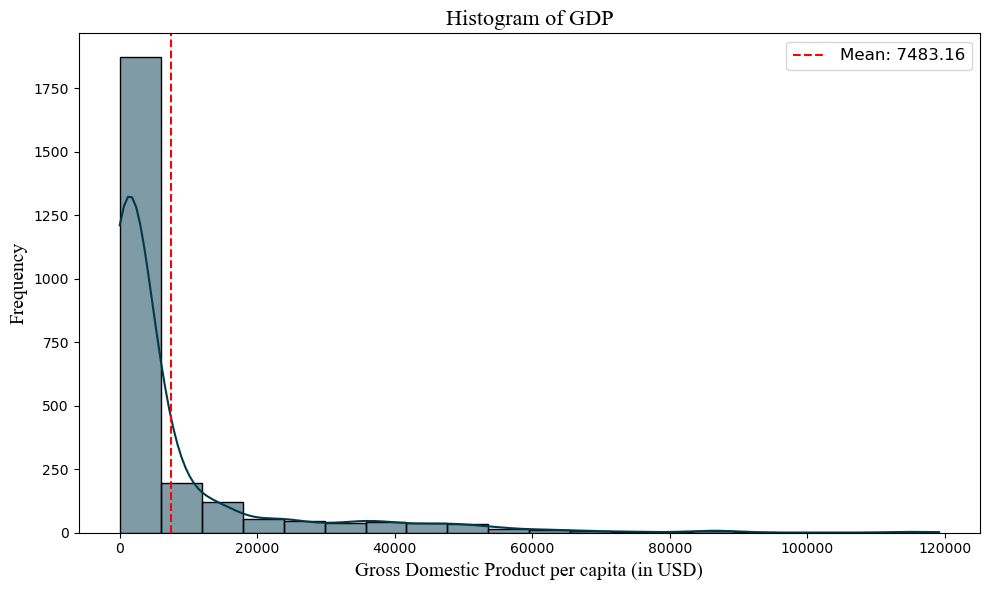

In [179]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['GDP'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of GDP',
               xlabel='Gross Domestic Product per capita (in USD)',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is skewed more to the right side with a mean of _7483_, the data has some high incomes but will never be considered as outliers (I think they are drug dealers). 

In [181]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['GDP']= lifeExpectancyDataframe['GDP'].astype('float32')

### Column eighteen: 

In [183]:
# Investigating the data of the column 
lifeExpectancyDataframe['Population'].head(10)

0    12222251.0
1      247315.0
2    14883626.0
3      614323.0
4       67656.0
5    44896856.0
6     6865951.0
7     3145483.0
8           NaN
9        8446.0
Name: Population, dtype: float64

In [184]:
# Investigating the data statically
lifeExpectancyDataframe['Population'].describe()

count    2.286000e+03
mean     1.275338e+07
std      6.101210e+07
min      3.400000e+01
25%      1.957932e+05
50%      1.386542e+06
75%      7.420359e+06
max      1.293859e+09
Name: Population, dtype: float64

In [185]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Population'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 652


In [186]:
# Suming the number of known values
data = lifeExpectancyDataframe['Population']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2286


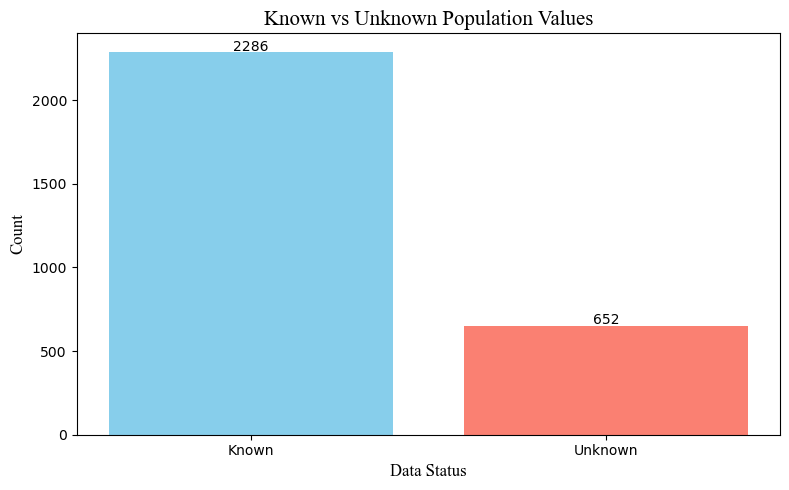

In [187]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Population Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

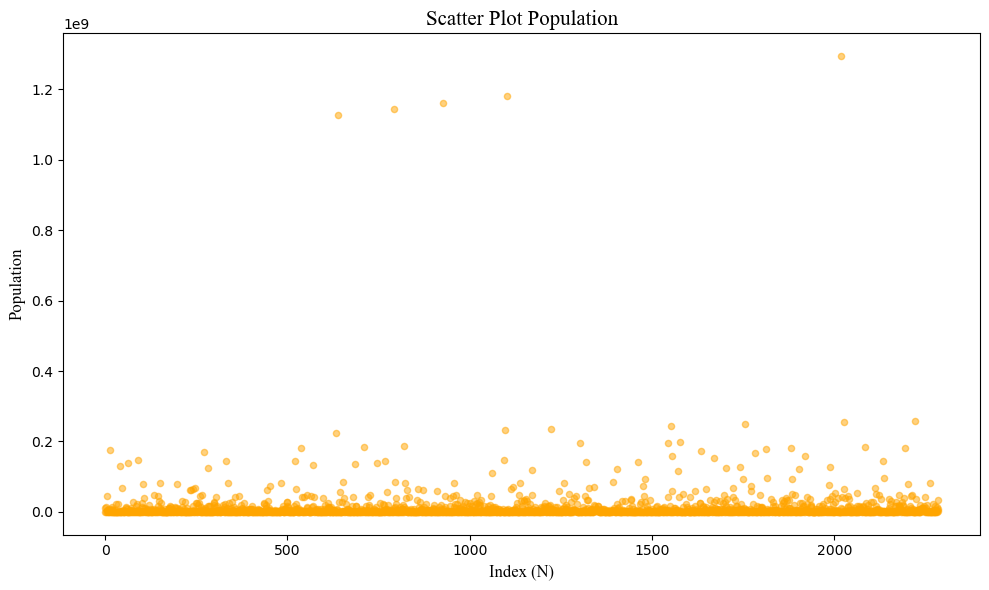

In [188]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Population'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Population', xlabel='Index (N)', ylabel='Population',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

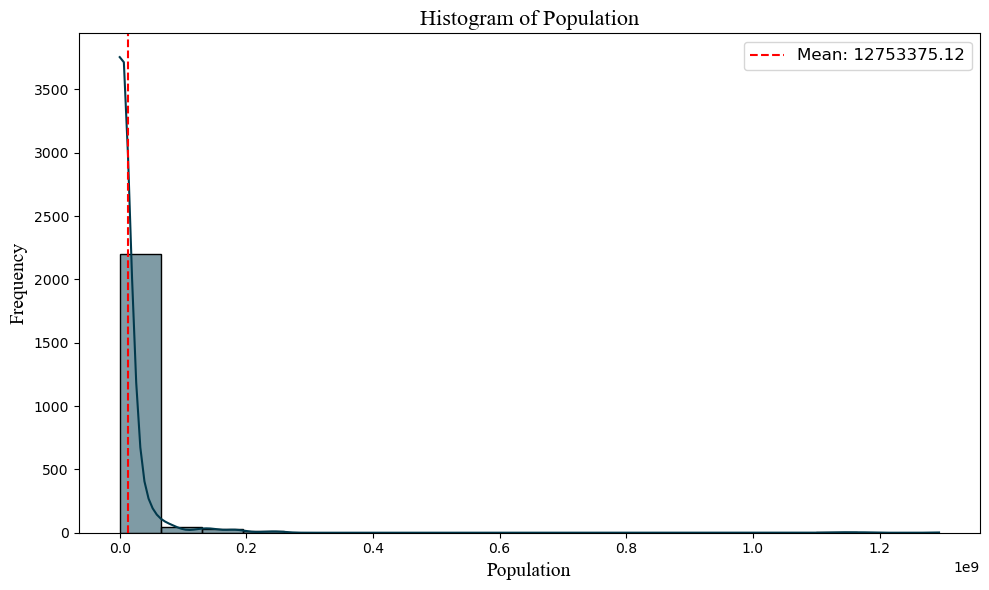

In [189]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Population'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Population',
               xlabel='Population',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is skewed more to the right with higher frequency around the mean with some high points indicating high population in some contires.

### Column nineteen: 

In [192]:
lifeExpectancyDataframe = lifeExpectancyDataframe.rename(columns={'thinness  1-19 years': 'Thinness 10-19 years'})

In [193]:
# Investigating the data of the column 
lifeExpectancyDataframe['Thinness 10-19 years'].head(10)

0    11.0
1     3.8
2     2.7
3     1.7
4     NaN
5    16.3
6     9.7
7     9.2
8     8.0
9     0.2
Name: Thinness 10-19 years, dtype: float64

In [194]:
# Investigating the data statically
lifeExpectancyDataframe['Thinness 10-19 years'].describe()

count    2904.000000
mean        4.839704
std         4.420195
min         0.100000
25%         1.600000
50%         3.300000
75%         7.200000
max        27.700000
Name: Thinness 10-19 years, dtype: float64

In [195]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Thinness 10-19 years'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 34


In [196]:
# Suming the number of known values
data = lifeExpectancyDataframe['Thinness 10-19 years']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2904


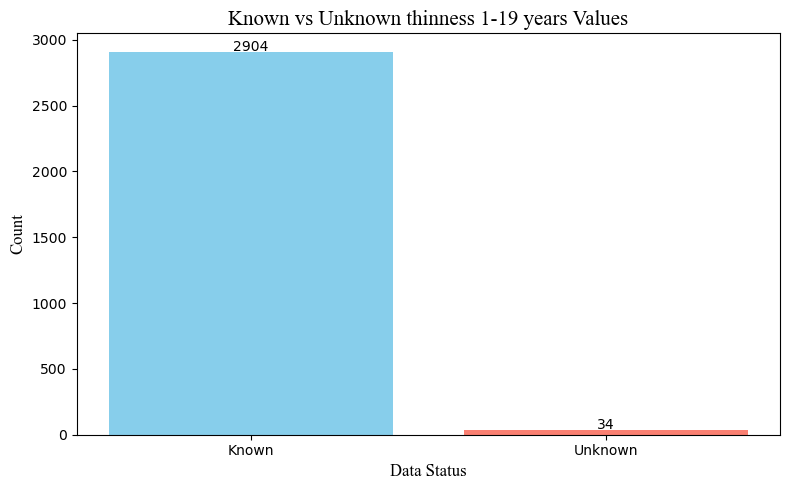

In [197]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown thinness 1-19 years Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

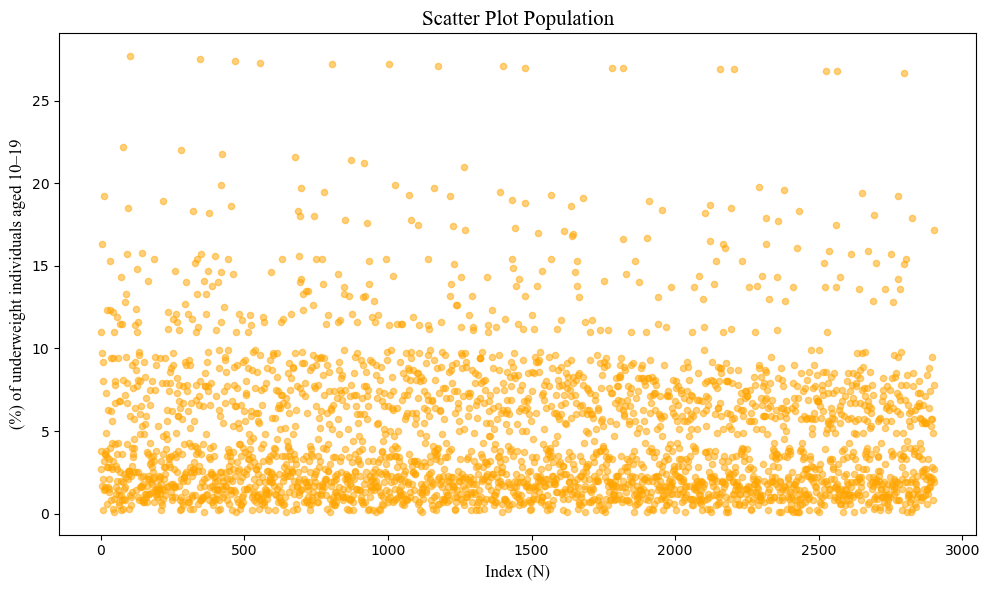

In [198]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 10-19 years'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Population', xlabel='Index (N)', ylabel='(%) of underweight individuals aged 10–19',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

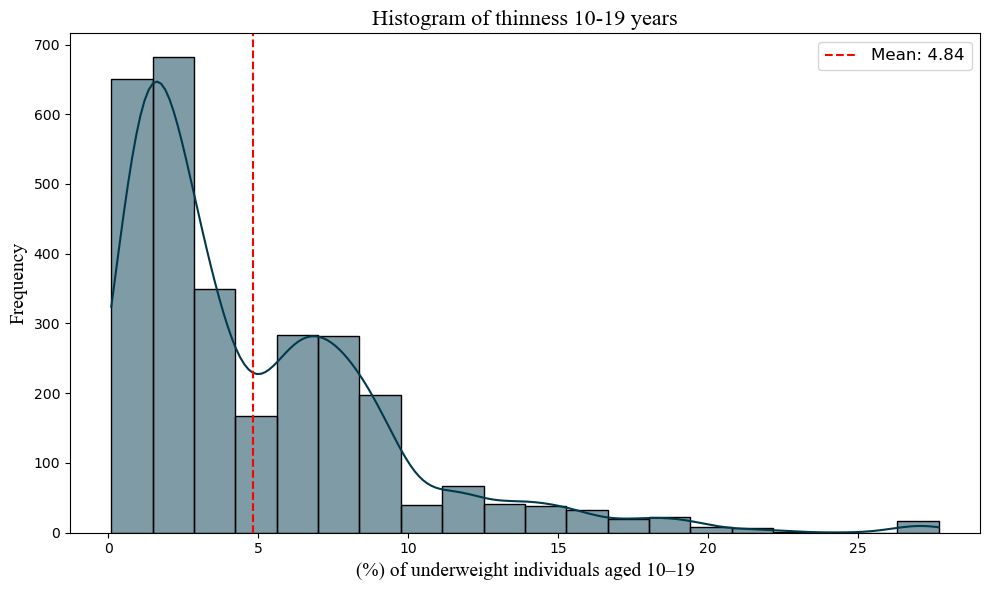

In [199]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 10-19 years'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of thinness 10-19 years',
               xlabel='(%) of underweight individuals aged 10–19',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is skewed more to the right side with higher density around the mean plus some high values.

In [201]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Thinness 10-19 years']= lifeExpectancyDataframe['Thinness 10-19 years'].astype('float32')

### Column twenty: 

In [203]:
lifeExpectancyDataframe = lifeExpectancyDataframe.rename(columns={'thinness 5-9 years': 'Thinness 5-9 years'})

In [204]:
# Investigating the data of the column 
lifeExpectancyDataframe['Thinness 5-9 years'].head(10)

0    11.2
1     3.7
2     2.7
3     1.6
4     NaN
5    19.1
6     9.6
7     9.1
8     7.9
9     0.2
Name: Thinness 5-9 years, dtype: float64

In [205]:
# Investigating the data statically
lifeExpectancyDataframe['Thinness 5-9 years'].describe()

count    2904.000000
mean        4.870317
std         4.508882
min         0.100000
25%         1.500000
50%         3.300000
75%         7.200000
max        28.600000
Name: Thinness 5-9 years, dtype: float64

In [206]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Thinness 5-9 years'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 34


In [207]:
# Suming the number of known values
data = lifeExpectancyDataframe['Thinness 5-9 years']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2904


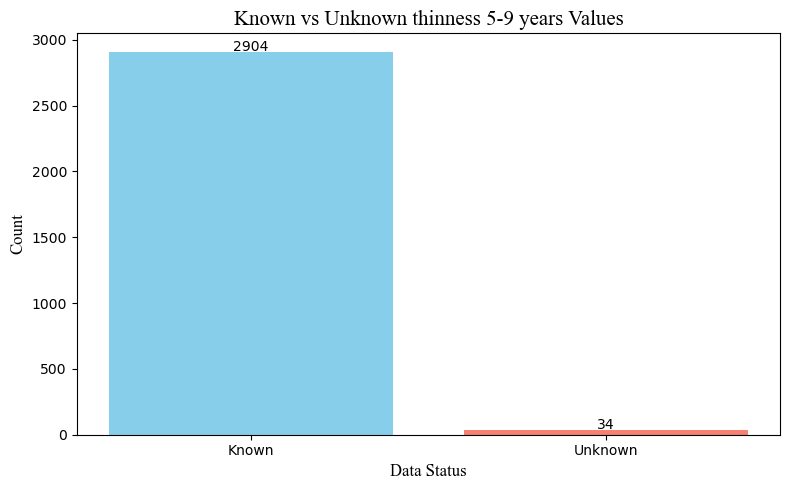

In [208]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown thinness 5-9 years Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

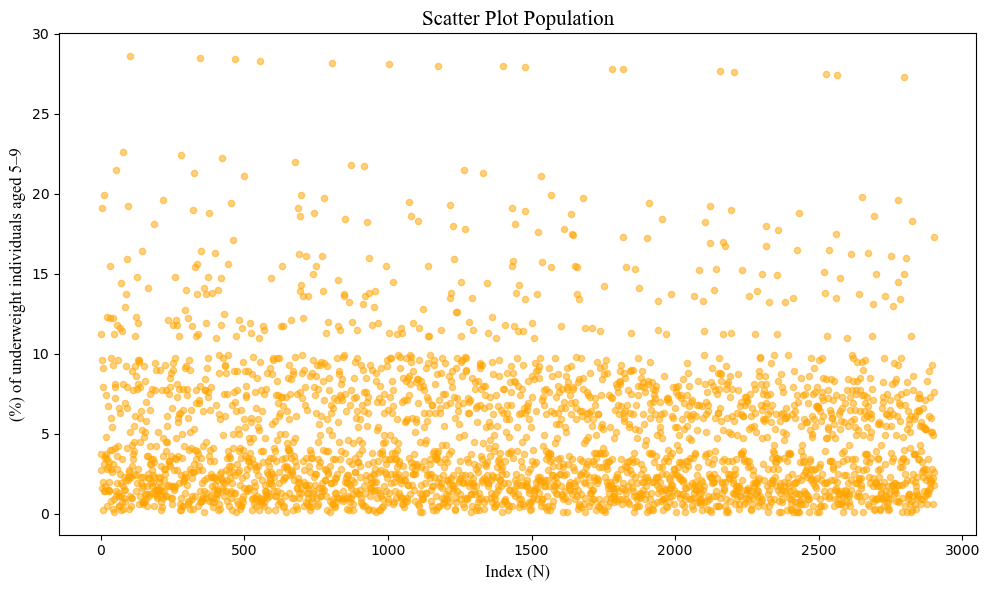

In [209]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 5-9 years'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Population', xlabel='Index (N)', ylabel='(%) of underweight individuals aged 5–9',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

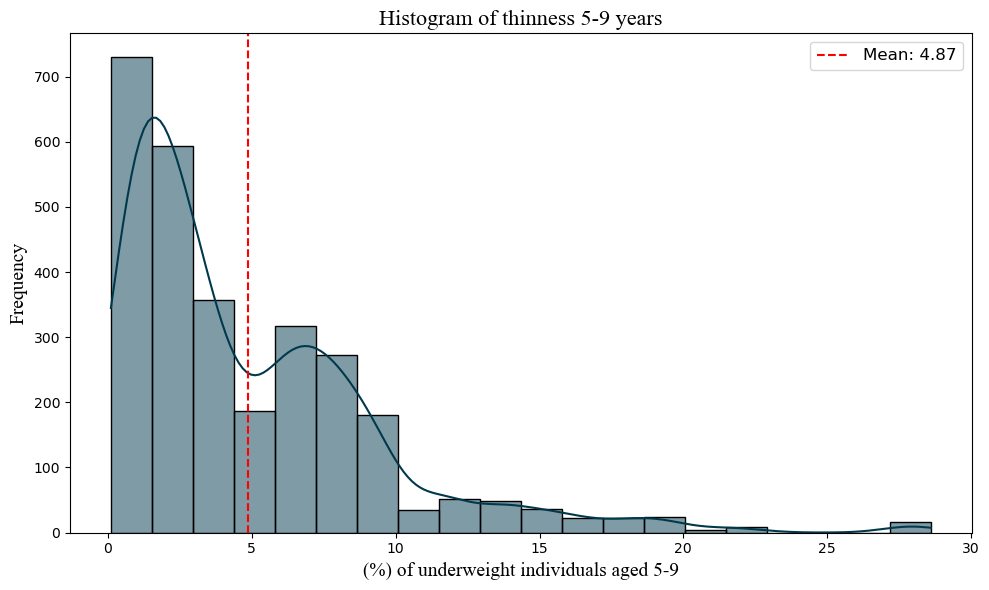

In [210]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 5-9 years'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of thinness 5-9 years',
               xlabel='(%) of underweight individuals aged 5-9',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is skewed more to the right side with higher density around the mean plus some high values.

In [212]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Thinness 5-9 years']= lifeExpectancyDataframe['Thinness 5-9 years'].astype('float32')

### Column twenty one: 

In [214]:
# Investigating the data of the column 
lifeExpectancyDataframe['Income composition of resources'].head(10)

0    0.434
1    0.668
2    0.676
3    0.000
4    0.000
5    0.635
6    0.389
7    0.448
8      NaN
9    0.000
Name: Income composition of resources, dtype: float64

In [215]:
# Investigating the data statically
lifeExpectancyDataframe['Income composition of resources'].describe()

count    2771.000000
mean        0.627551
std         0.210904
min         0.000000
25%         0.493000
50%         0.677000
75%         0.779000
max         0.948000
Name: Income composition of resources, dtype: float64

In [216]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Income composition of resources'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 167


In [217]:
# Suming the number of known values
data = lifeExpectancyDataframe['Income composition of resources']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2771


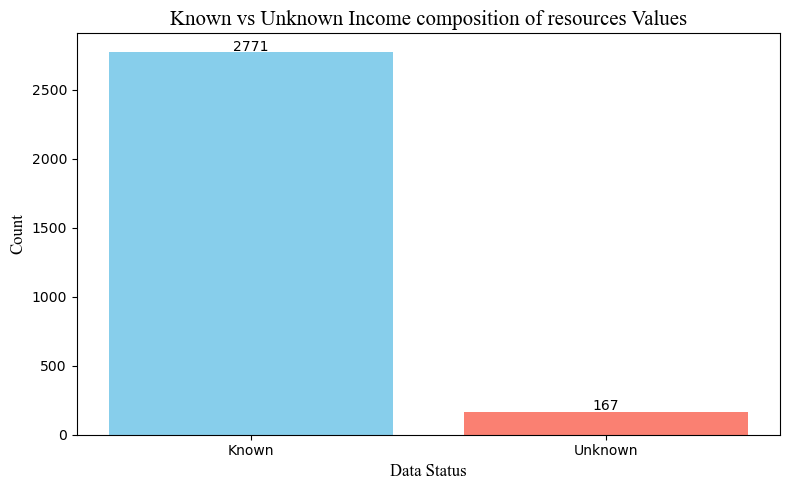

In [218]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Income composition of resources Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

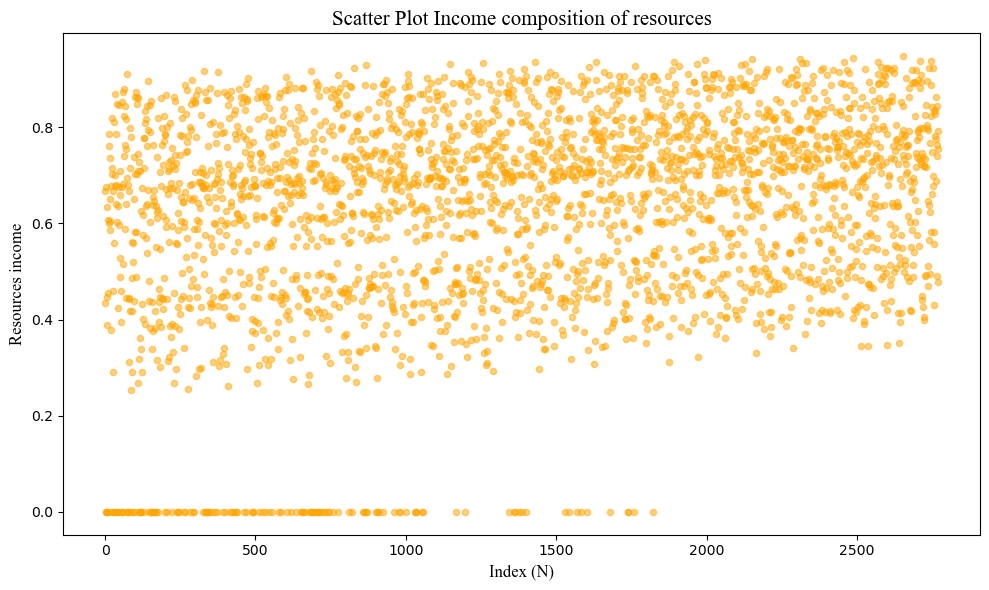

In [219]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Income composition of resources'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Income composition of resources', xlabel='Index (N)', ylabel='Resources income',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

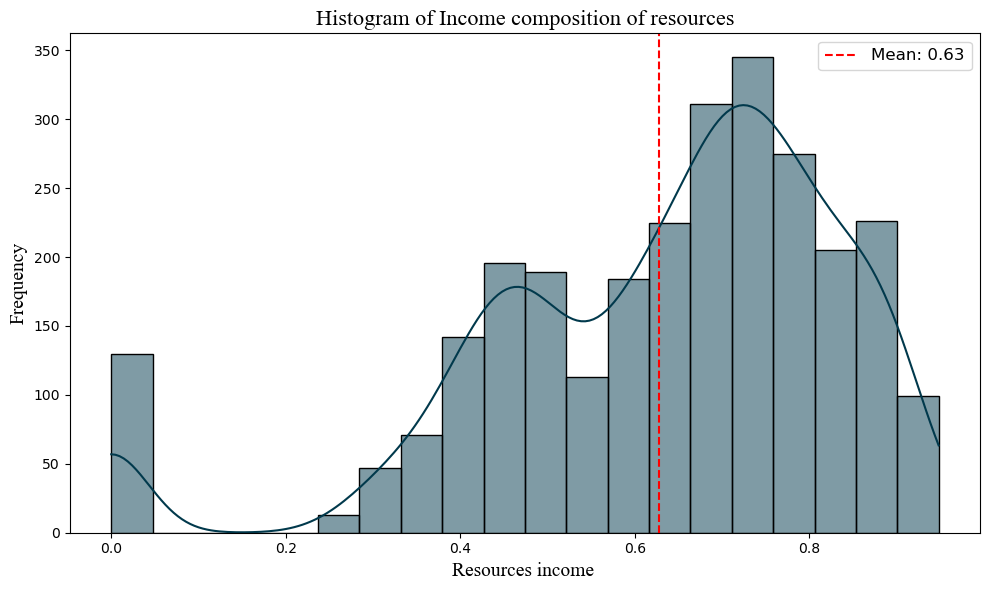

In [220]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Income composition of resources'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Income composition of resources',
               xlabel='Resources income ',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is more skewed to the left side wit high mean and desnsity pointing to at good education, services and income.

### Column twenty two: 

In [223]:
# Investigating the data of the column 
lifeExpectancyDataframe['Schooling'].head(10)

0     9.8
1    11.7
2    12.1
3     0.0
4     0.0
5    13.0
6     6.4
7     8.4
8     NaN
9    10.0
Name: Schooling, dtype: float64

In [224]:
# Investigating the data statically
lifeExpectancyDataframe['Schooling'].describe()

count    2775.000000
mean       11.992793
std         3.358920
min         0.000000
25%        10.100000
50%        12.300000
75%        14.300000
max        20.700000
Name: Schooling, dtype: float64

In [225]:
# checking for missing items and their count
unknown_values = lifeExpectancyDataframe['Schooling'].isna().sum()
print("Nan values sum: " + str(unknown_values))

Nan values sum: 163


In [226]:
# Suming the number of known values
data = lifeExpectancyDataframe['Schooling']
known_values = data.notna().sum()

print("Known values:", known_values)

Known values: 2775


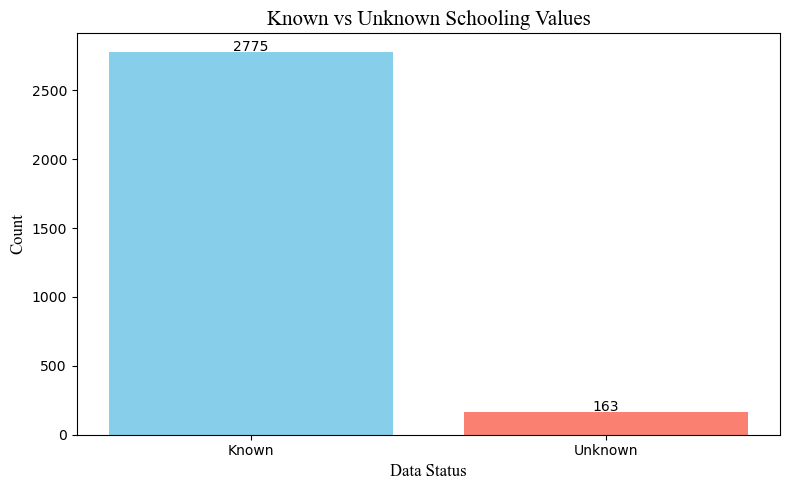

In [227]:
# Bar plot plotting
Data = [known_values, unknown_values]
labels = ['Known', 'Unknown']

plot_categorical_bar(
    Data, labels,
    title='Known vs Unknown Schooling Values',
    xlabel='Data Status', ylabel='Count',
    colors=['skyblue', 'salmon'],
    fontname='Times New Roman',
    figsize=(8, 5),
    label_fontsize=12,
    title_fontsize=15,
    value_fontsize=10,
    text_offset=10
)

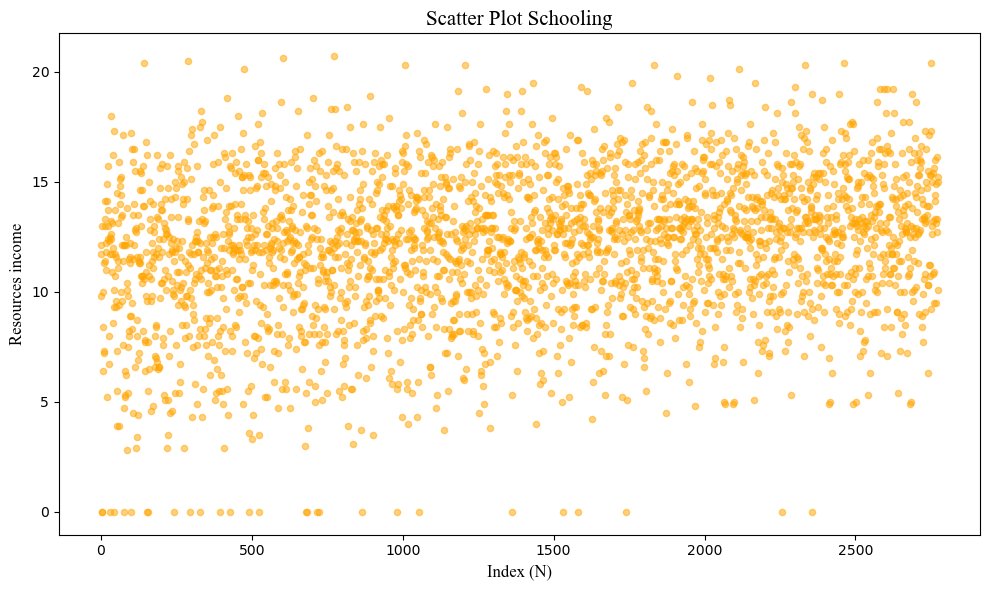

In [228]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Schooling'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Schooling', xlabel='Index (N)', ylabel='Resources income',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

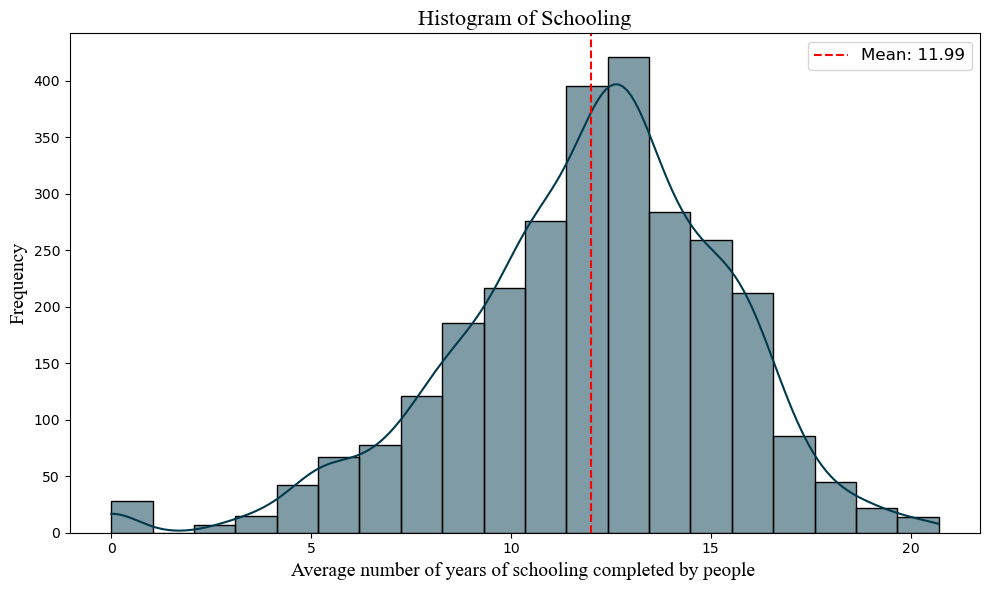

In [229]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Schooling'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Schooling',
               xlabel='Average number of years of schooling completed by people ',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The data is normally distributed which is logically resalable, starting from _zero_ till _twenty_ as non educated societies ending with highly educated and PhD holders, with an average of _12_.

In [231]:
# The data will be stored as float but to save more memory and refrence to the range we are working with the size will be reduced to 32 bit.
lifeExpectancyDataframe['Schooling']= lifeExpectancyDataframe['Schooling'].astype('float32')

In [232]:
lifeExpectancyDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Country                          2938 non-null   object  
 1   Year                             2938 non-null   int16   
 2   Status                           2938 non-null   category
 3   Life expectancy                  2928 non-null   float32 
 4   Adult Mortality                  2928 non-null   float32 
 5   Infant deaths                    2938 non-null   float32 
 6   Alcohol consumption              2744 non-null   float32 
 7   Percentage expenditure           2938 non-null   float32 
 8   Hepatitis B                      2385 non-null   float32 
 9   Measles                          2938 non-null   uint16  
 10  BMI                              2904 non-null   float32 
 11  Death numbers under-five         2938 non-null   uint16  
 12  Polio 

In [233]:
# Swapping the columns for more arrangement
listOfcolumns = list(lifeExpectancyDataframe.columns)

i1 = listOfcolumns.index('Thinness 10-19 years')
i2 = listOfcolumns.index('Thinness 5-9 years')

listOfcolumns[i1], listOfcolumns[i2] = listOfcolumns[i2], listOfcolumns[i1]
lifeExpectancyDataframe = lifeExpectancyDataframe[listOfcolumns]

In [234]:
lifeExpectancyDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Country                          2938 non-null   object  
 1   Year                             2938 non-null   int16   
 2   Status                           2938 non-null   category
 3   Life expectancy                  2928 non-null   float32 
 4   Adult Mortality                  2928 non-null   float32 
 5   Infant deaths                    2938 non-null   float32 
 6   Alcohol consumption              2744 non-null   float32 
 7   Percentage expenditure           2938 non-null   float32 
 8   Hepatitis B                      2385 non-null   float32 
 9   Measles                          2938 non-null   uint16  
 10  BMI                              2904 non-null   float32 
 11  Death numbers under-five         2938 non-null   uint16  
 12  Polio 

## _First Dataframe - cleaning:_

The following comlumns will not be considered as outliears: 
1. Country -String values.
2. Year -real values.
3. Status -String values.
4. Polio disease

### Life expectancy: 

In [238]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Life expectancy', 69.224932, 9.523867)

Mean: 69.224932
Standard Deviation: 9.523867
Outliers: 
 29      39.000000
1996    36.299999
Name: Life expectancy, dtype: float32
Number of rows containing outliers: 2


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000            665.0   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Adult Mortality:

In [240]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Adult Mortality', 164.796448, 124.292079)

Mean: 164.796448
Standard Deviation: 124.292079
Outliers: 
 0       665.0
32      647.0
54      593.0
70      543.0
137     588.0
159     554.0
175     614.0
228     599.0
255     679.0
261     686.0
273     586.0
299     568.0
303     611.0
334     539.0
439     587.0
522     622.0
529     699.0
573     613.0
613     648.0
709     715.0
724     693.0
787     578.0
788     723.0
844     615.0
900     652.0
903     666.0
924     717.0
938     554.0
1009    675.0
1089    566.0
1152    564.0
1184    654.0
1193    587.0
1297    559.0
1328    633.0
1482    632.0
1565    592.0
1653    587.0
1763    566.0
1996    682.0
Name: Adult Mortality, dtype: float32
Number of rows containing outliers: 40


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Infant deaths:

In [242]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Infant deaths', 30.303948, 117.926501)

Mean: 30.303948
Standard Deviation: 117.926501
Outliers: 
 74       576.0
80       385.0
103      490.0
105     1800.0
284      457.0
349     1800.0
363      574.0
391      571.0
430      422.0
474     1700.0
561     1700.0
685      391.0
730      567.0
816     1600.0
873      563.0
962      556.0
1015    1500.0
1189    1500.0
1253     549.0
1375     542.0
1416    1400.0
1495    1300.0
1518     536.0
1732     527.0
1801    1300.0
1838    1200.0
1992     521.0
2081     513.0
2180    1100.0
2231    1100.0
2279     505.0
2457     498.0
2553    1000.0
2593     957.0
2648     490.0
2818     483.0
2831     910.0
Name: Infant deaths, dtype: float32
Number of rows containing outliers: 37


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Alcohol consumption:

In [244]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Alcohol consumption', 4.602861, 4.052413)

Mean: 4.602861
Standard Deviation: 4.052413
Outliers: 
 1459    17.870001
1595    16.990000
2111    17.309999
Name: Alcohol consumption, dtype: float32
Number of rows containing outliers: 3


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Percentage expenditure:

In [246]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Percentage expenditure', 738.251295, 1987.914858)

Mean: 738.251295
Standard Deviation: 1987.914858
Outliers: 
 108      8246.130859
249      7877.336426
494      6853.628418
567     10111.389648
740      9495.541016
            ...     
2677     7971.646484
2727    19479.912109
2728    16255.162109
2734    10468.762695
2751     7163.349121
Name: Percentage expenditure, Length: 84, dtype: float32
Number of rows containing outliers: 84


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Hepatitis B:

In [248]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Hepatitis B', 80.940461, 25.070016)

Mean: 80.940461
Standard Deviation: 25.070016
Outliers: 
 150     5.0
173     4.0
242     1.0
375     4.0
475     5.0
479     5.0
588     5.0
655     5.0
700     2.0
809     5.0
958     5.0
1282    5.0
2120    4.0
2139    2.0
2317    4.0
2370    2.0
2632    2.0
2656    5.0
Name: Hepatitis B, dtype: float32
Number of rows containing outliers: 18


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Measles:

In [250]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Hepatitis B', 2419.592240, 11467.272489)

Mean: 2419.59224
Standard Deviation: 11467.272489
Outliers: 
 Series([], Name: Hepatitis B, dtype: float32)
Number of rows containing outliers: 0


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### BMI:

In [252]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'BMI', 38.321247, 20.044034)

Mean: 38.321247
Standard Deviation: 20.044034
Outliers: 
 Series([], Name: BMI, dtype: float32)
Number of rows containing outliers: 0


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Death numbers under-five: 

In [254]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Death numbers under-five', 42.035739, 160.445548)

Mean: 42.035739
Standard Deviation: 160.445548
Outliers: 
 74       943
103      608
105     2500
284      558
349     2400
363      936
391      928
474     2300
561     2200
730      918
816     2100
873      907
962      893
1015    2000
1189    2000
1253     879
1375     863
1416    1900
1495    1800
1518     848
1732     832
1801    1700
1838    1600
1992     817
2081     802
2180    1500
2231    1400
2279     788
2457     773
2553    1300
2593    1200
2648     759
2818     747
2831    1100
Name: Death numbers under-five, dtype: uint16
Number of rows containing outliers: 34


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Total expenditure:

In [256]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Total expenditure', 5.93819, 2.49832)

Mean: 5.93819
Standard Deviation: 2.49832
Outliers: 
 29      13.630000
145     13.700000
250     13.730000
539     14.550000
725     15.600000
768     15.140000
919     15.150000
1207    15.270000
1303    13.660000
1392    15.570000
1510    16.200001
1687    17.000000
1764    13.440000
1791    14.390000
1836    17.200001
1944    13.830000
2045    17.600000
2115    13.760000
2295    17.200001
2388    17.240000
2480    16.900000
2492    16.610001
2596    17.139999
2673    13.730000
2745    13.710000
Name: Total expenditure, dtype: float32
Number of rows containing outliers: 25


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Diphtheria:

In [258]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Diphtheria', 82.324084, 23.716912)

Mean: 82.324084
Standard Deviation: 23.716912
Outliers: 
 9       9.0
39      9.0
40      8.0
49      9.0
60      3.0
       ... 
2782    8.0
2792    8.0
2848    8.0
2851    9.0
2890    6.0
Name: Diphtheria, Length: 170, dtype: float32
Number of rows containing outliers: 170


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0      43.5   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### HIV/AIDS:

In [260]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'HIV/AIDS', 1.742103, 5.077785)

Mean: 1.742103
Standard Deviation: 5.077785
Outliers: 
 0       43.500000
5       21.299999
7       18.100000
32      38.799999
61      46.400002
          ...    
1653    18.100000
1676    19.000000
1735    33.700001
1763    18.200001
1859    21.600000
Name: HIV/AIDS, Length: 69, dtype: float32
Number of rows containing outliers: 69


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0       NaN   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887  12222251.0                11.2                  11.0   
1  3364.423828    247315.0                 3.7                   3.8   
2  1229.958008  14883626.0                 2.7                   2.7   
3   172.684906    614323.0                 1.6                   1.7   
4          NaN     67656.0                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### GDP:

In [262]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Population', 7483.158469, 14270.169342)

Mean: 7483.158469
Standard Deviation: 14270.169342
Outliers: 
 0       12222251.0
1         247315.0
2       14883626.0
3         614323.0
4          67656.0
           ...    
2931      291695.0
2932     5851479.0
2935     7177991.0
2936     2596218.0
2937    33736494.0
Name: Population, Length: 1979, dtype: float64
Number of rows containing outliers: 1979


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0       NaN   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887         NaN                11.2                  11.0   
1  3364.423828         NaN                 3.7                   3.8   
2  1229.958008         NaN                 2.7                   2.7   
3   172.684906         NaN                 1.6                   1.7   
4          NaN         NaN                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Population:

In [264]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Population', 1.275338e+07, 6.101210e+07)

Mean: 12753380.0
Standard Deviation: 61012100.0
Outliers: 
 Series([], Name: Population, dtype: float64)
Number of rows containing outliers: 0


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0       NaN   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887         NaN                11.2                  11.0   
1  3364.423828         NaN                 3.7                   3.8   
2  1229.958008         NaN                 2.7                   2.7   
3   172.684906         NaN                 1.6                   1.7   
4          NaN         NaN                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Thinness 5-9 years:

In [266]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Thinness 5-9 years', 4.870317, 4.508882)

Mean: 4.870317
Standard Deviation: 4.508882
Outliers: 
 5       19.100000
11      19.900000
53      21.500000
80      22.600000
97      19.200001
105     28.600000
219     19.600000
280     22.400000
324     19.000000
325     21.299999
349     28.500000
382     18.799999
426     22.200001
461     19.400000
474     28.400000
505     21.100000
561     28.299999
683     22.000000
694     19.100000
700     18.600000
704     19.900000
752     18.799999
786     19.700001
816     28.200001
861     18.400000
881     21.799999
929     21.700001
1015    28.100000
1085    19.500000
1094    18.600000
1189    28.000000
1229    19.299999
1279    21.500000
1345    21.299999
1416    28.000000
1447    19.100000
1493    18.900000
1495    27.900000
1548    21.100000
1583    19.900000
1658    18.700001
1699    19.700001
1801    27.799999
1838    27.799999
1931    19.400000
1977    18.400000
2145    19.200001
2180    27.700001
2221    19.000000
2231    27.600000
2460    18.799999
2553    27.500000
2593    

Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0       NaN   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887         NaN                11.2                  11.0   
1  3364.423828         NaN                 3.7                   3.8   
2  1229.958008         NaN                 2.7                   2.7   
3   172.684906         NaN                 1.6                   1.7   
4          NaN         NaN                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Thinness 10-19 years:

In [268]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Thinness 10-19 years', 4.839704, 4.420195)

Mean: 4.839704
Standard Deviation: 4.420195
Outliers: 
 11      19.200001
80      22.200001
97      18.500000
105     27.700001
219     18.900000
280     22.000000
324     18.299999
349     27.500000
382     18.200001
423     19.900000
426     21.799999
461     18.600000
474     27.400000
561     27.299999
683     21.600000
694     18.299999
704     19.700001
786     19.500000
816     27.200001
881     21.400000
929     21.200001
1015    27.200001
1036    19.900000
1085    19.299999
1174    19.700001
1189    27.100000
1229    19.200001
1279    21.000000
1405    19.500000
1416    27.100000
1447    19.000000
1493    18.799999
1495    27.000000
1583    19.299999
1658    18.600000
1699    19.100000
1801    27.000000
1838    27.000000
1931    18.900000
1977    18.400000
2125    18.200001
2145    18.700001
2180    26.900000
2221    18.500000
2231    26.900000
2319    19.799999
2407    19.600000
2460    18.299999
2553    26.799999
2593    26.799999
2681    19.400000
2808    19.200001
2831    

Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0       NaN   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887         NaN                11.2                  11.0   
1  3364.423828         NaN                 3.7                   3.8   
2  1229.958008         NaN                 2.7                   2.7   
3   172.684906         NaN                 1.6                   1.7   
4          NaN         NaN                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Income composition of resources:

In [270]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Income composition of resources', 0.627551, 0.210904)

Mean: 0.627551
Standard Deviation: 0.210904
Outliers: 
 Series([], Name: Income composition of resources, dtype: float64)
Number of rows containing outliers: 0


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0       NaN   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887         NaN                11.2                  11.0   
1  3364.423828         NaN                 3.7                   3.8   
2  1229.958008         NaN                 2.7                   2.7   
3   172.684906         NaN                 1.6                   1.7   
4          NaN         NaN                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        0.0  
4                            0.000        0.0  

[5 rows x 22 columns]

### Schooling: 

In [272]:
replace_outliers_with_nan(lifeExpectancyDataframe, 'Schooling', 11.992793, 3.358920)

Mean: 11.992793
Standard Deviation: 3.35892
Outliers: 
 3       0.0
4       0.0
30      0.0
43      0.0
78      0.0
100     0.0
163     0.0
166     0.0
260     0.0
315     0.0
347     0.0
418     0.0
454     0.0
520     0.0
553     0.0
720     0.0
721     0.0
755     0.0
767     0.0
916     0.0
1038    0.0
1114    0.0
1442    0.0
1616    0.0
1672    0.0
1840    0.0
2388    0.0
2492    0.0
Name: Schooling, dtype: float32
Number of rows containing outliers: 28


Country  Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000  Developing        46.000000              NaN   
1             Belize  2000  Developing        68.300003            196.0   
2         Kazakhstan  2000  Developing        63.900002            292.0   
3  Equatorial Guinea  2000  Developing        52.700001            336.0   
4        South Sudan  2000  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514          NaN   
4           31.0                  NaN                0.000000          NaN   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0     1483  ...           78.0               7.10        78.0       NaN   
1        0  ...           91.0               3.98        91.0       0.3   
2      245  ...           96.0               4.16        97.0       0.1   
3        0  ...           41.0               2.73        34.0       1.9   
4        0  ...            NaN                NaN         NaN       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887         NaN                11.2                  11.0   
1  3364.423828         NaN                 3.7                   3.8   
2  1229.958008         NaN                 2.7                   2.7   
3   172.684906         NaN                 1.6                   1.7   
4          NaN         NaN                 NaN                   NaN   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000        NaN  
4                            0.000        NaN  

[5 rows x 22 columns]

In [273]:
lifeExpectancyDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Country                          2938 non-null   object  
 1   Year                             2938 non-null   int16   
 2   Status                           2938 non-null   category
 3   Life expectancy                  2926 non-null   float32 
 4   Adult Mortality                  2888 non-null   float32 
 5   Infant deaths                    2901 non-null   float32 
 6   Alcohol consumption              2741 non-null   float32 
 7   Percentage expenditure           2854 non-null   float32 
 8   Hepatitis B                      2367 non-null   float32 
 9   Measles                          2938 non-null   uint16  
 10  BMI                              2904 non-null   float32 
 11  Death numbers under-five         2904 non-null   float64 
 12  Polio 

In [274]:
lifeExpectancyDataframe

Country  Year      Status  \
0                                              Zimbabwe  2000  Developing   
1                                                Belize  2000  Developing   
2                                            Kazakhstan  2000  Developing   
3                                     Equatorial Guinea  2000  Developing   
4                                           South Sudan  2000  Developing   
...                                                 ...   ...         ...   
2933  United Kingdom of Great Britain and Northern I...  2015   Developed   
2934                                       Saudi Arabia  2015  Developing   
2935                                           Bulgaria  2015   Developed   
2936                                             Brazil  2015  Developing   
2937                                        Afghanistan  2015  Developing   

      Life expectancy  Adult Mortality  Infant deaths  Alcohol consumption  \
0           46.000000              NaN           24.0                 1.68   
1           68.300003            196.0            0.0                 4.79   
2           63.900002            292.0            9.0                 6.00   
3           52.700001            336.0            3.0                 4.46   
4           48.900002             38.0           31.0                  NaN   
...               ...              ...            ...                  ...   
2933        81.199997             69.0            3.0                10.66   
2934        74.500000             88.0            7.0                  NaN   
2935        74.500000            137.0            0.0                  NaN   
2936        75.000000            142.0           42.0                  NaN   
2937        65.000000            263.0           62.0                 0.01   

      Percentage expenditure  Hepatitis B  Measles  ...  Polio disease  \
0                   0.000000         79.0     1483  ...           78.0   
1                 219.023987         76.0        0  ...           91.0   
2                 112.541161         99.0      245  ...           96.0   
3                  14.954514          NaN        0  ...           41.0   
4                   0.000000          NaN        0  ...            NaN   
...                      ...          ...      ...  ...            ...   
2933                0.000000          NaN       91  ...           96.0   
2934                0.000000         98.0      219  ...           97.0   
2935                0.000000         92.0        0  ...           91.0   
2936                0.000000         96.0      214  ...           98.0   
2937               71.279625         65.0     1154  ...            6.0   

      Total expenditure  Diphtheria  HIV/AIDS          GDP  Population  \
0                  7.10        78.0       NaN   547.358887         NaN   
1                  3.98        91.0       0.3  3364.423828         NaN   
2                  4.16        97.0       0.1  1229.958008         NaN   
3                  2.73        34.0       1.9   172.684906         NaN   
4                   NaN         NaN       2.7          NaN         NaN   
...                 ...         ...       ...          ...         ...   
2933                NaN        96.0       0.1          NaN         NaN   
2934                NaN        98.0       0.1  2732.861816         NaN   
2935                NaN        91.0       0.1  6993.477539         NaN   
2936                NaN        96.0       0.1  8757.261719         NaN   
2937               8.16        65.0       0.1   584.259216         NaN   

      Thinness 5-9 years  Thinness 10-19 years  \
0              11.200000             11.000000   
1               3.700000              3.800000   
2               2.700000              2.700000   
3               1.600000              1.700000   
4                    NaN                   NaN   
...                  ...                   ...   
2933            0.600000              0.800000   
2934    

In [275]:
len(lifeExpectancyDataframe['Country'].unique().sum())

1931

In [276]:
# Seperating the datasets into integers and strings
num_cols = lifeExpectancyDataframe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = lifeExpectancyDataframe.select_dtypes(include=['object']).columns.tolist()

# Print columns based on category
print(f"Numeric columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

# For numeric columns - impute with median
if num_cols:
    num_imputer = SimpleImputer(strategy='median')
    lifeExpectancyDataframe[num_cols] = num_imputer.fit_transform(lifeExpectancyDataframe[num_cols])

# For categorical columns - impute with most frequent value
if cat_cols:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    lifeExpectancyDataframe[cat_cols] = cat_imputer.fit_transform(lifeExpectancyDataframe[cat_cols])

# Create a copy to work with for modeling
df_for_modeling = lifeExpectancyDataframe.copy()

# Process categorical features for modeling
if cat_cols:
    # One-hot encode the categorical columns
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_cats = encoder.fit_transform(df_for_modeling[cat_cols])
    
    # Get the new column names
    encoded_feature_names = encoder.get_feature_names_out(cat_cols)
    
    # Create a DataFrame with the encoded values
    encoded_cats_df = pd.DataFrame(
        encoded_cats, 
        columns=encoded_feature_names, 
        index=df_for_modeling.index
    )
    
    # Drop the original categorical columns and join the encoded ones
    df_for_modeling = df_for_modeling.drop(columns=cat_cols).join(encoded_cats_df)

Numeric columns: ['Year', 'Life expectancy', 'Adult Mortality', 'Infant deaths', 'Alcohol consumption', 'Percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Death numbers under-five', 'Polio disease', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'Thinness 5-9 years', 'Thinness 10-19 years', 'Income composition of resources', 'Schooling']
Categorical columns: ['Country']


In [277]:
lifeExpectancyDataframe

Country    Year      Status  \
0                                              Zimbabwe  2000.0  Developing   
1                                                Belize  2000.0  Developing   
2                                            Kazakhstan  2000.0  Developing   
3                                     Equatorial Guinea  2000.0  Developing   
4                                           South Sudan  2000.0  Developing   
...                                                 ...     ...         ...   
2933  United Kingdom of Great Britain and Northern I...  2015.0   Developed   
2934                                       Saudi Arabia  2015.0  Developing   
2935                                           Bulgaria  2015.0   Developed   
2936                                             Brazil  2015.0  Developing   
2937                                        Afghanistan  2015.0  Developing   

      Life expectancy  Adult Mortality  Infant deaths  Alcohol consumption  \
0           46.000000            142.0           24.0                 1.68   
1           68.300003            196.0            0.0                 4.79   
2           63.900002            292.0            9.0                 6.00   
3           52.700001            336.0            3.0                 4.46   
4           48.900002             38.0           31.0                 3.74   
...               ...              ...            ...                  ...   
2933        81.199997             69.0            3.0                10.66   
2934        74.500000             88.0            7.0                 3.74   
2935        74.500000            137.0            0.0                 3.74   
2936        75.000000            142.0           42.0                 3.74   
2937        65.000000            263.0           62.0                 0.01   

      Percentage expenditure  Hepatitis B  Measles  ...  Polio disease  \
0                   0.000000         79.0   1483.0  ...           78.0   
1                 219.023987         76.0      0.0  ...           91.0   
2                 112.541161         99.0    245.0  ...           96.0   
3                  14.954514         92.0      0.0  ...           41.0   
4                   0.000000         92.0      0.0  ...           93.0   
...                      ...          ...      ...  ...            ...   
2933                0.000000         92.0     91.0  ...           96.0   
2934                0.000000         98.0    219.0  ...           97.0   
2935                0.000000         92.0      0.0  ...           91.0   
2936                0.000000         96.0    214.0  ...           98.0   
2937               71.279625         65.0   1154.0  ...            6.0   

      Total expenditure  Diphtheria  HIV/AIDS          GDP  Population  \
0                  7.10        78.0       0.1   547.358887     15578.0   
1                  3.98        91.0       0.3  3364.423828     15578.0   
2                  4.16        97.0       0.1  1229.958008     15578.0   
3                  2.73        34.0       1.9   172.684906     15578.0   
4                  5.72        93.0       2.7  1766.947571     15578.0   
...                 ...         ...       ...          ...         ...   
2933               5.72        96.0       0.1  1766.947571     15578.0   
2934               5.72        98.0       0.1  2732.861816     15578.0   
2935               5.72        91.0       0.1  6993.477539     15578.0   
2936               5.72        96.0       0.1  8757.261719     15578.0   
2937               8.16        65.0       0.1   584.259216     15578.0   

      Thinness 5-9 years  Thinness 10-19 years  \
0              11.200000             11.000000   
1               3.700000              3.800000   
2               2.700000              2.700000   
3               1.600000              1.700000   
4               3.300000              3.300000   
...                  ...                   ...   
2933            0.600000          

In [278]:
lifeExpectancyDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Country                          2938 non-null   object  
 1   Year                             2938 non-null   float64 
 2   Status                           2938 non-null   category
 3   Life expectancy                  2938 non-null   float64 
 4   Adult Mortality                  2938 non-null   float64 
 5   Infant deaths                    2938 non-null   float64 
 6   Alcohol consumption              2938 non-null   float64 
 7   Percentage expenditure           2938 non-null   float64 
 8   Hepatitis B                      2938 non-null   float64 
 9   Measles                          2938 non-null   float64 
 10  BMI                              2938 non-null   float64 
 11  Death numbers under-five         2938 non-null   float64 
 12  Polio 

In [279]:
lifeExpectancyDataframe.isna().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
Infant deaths                      0
Alcohol consumption                0
Percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
Death numbers under-five           0
Polio disease                      0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
Thinness 5-9 years                 0
Thinness 10-19 years               0
Income composition of resources    0
Schooling                          0
dtype: int64

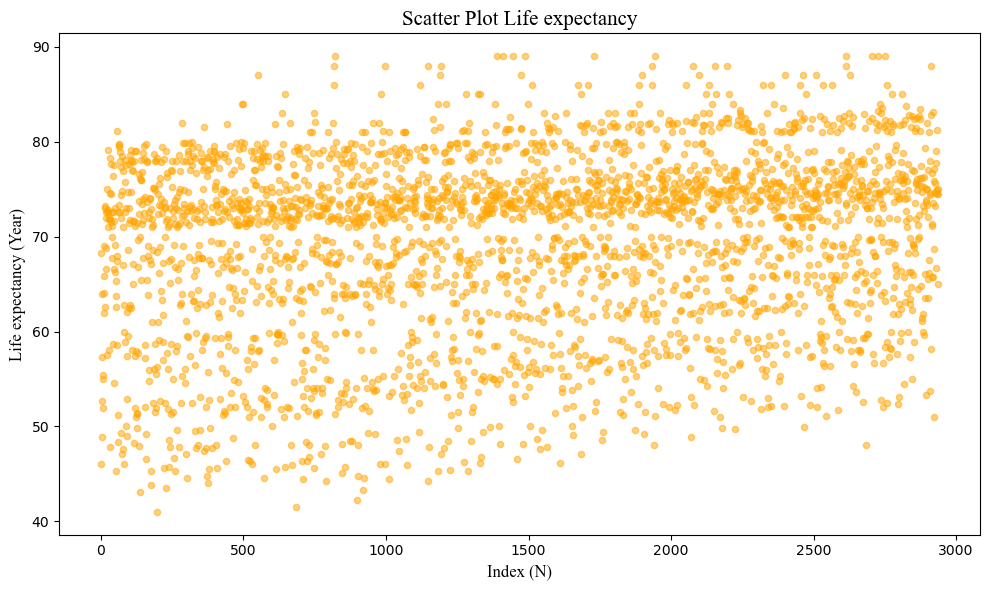

In [280]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Life expectancy'], errors='coerce').dropna()
plot_scatter(Data, title='Scatter Plot Life expectancy', xlabel='Index (N)', ylabel='Life expectancy (Year)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

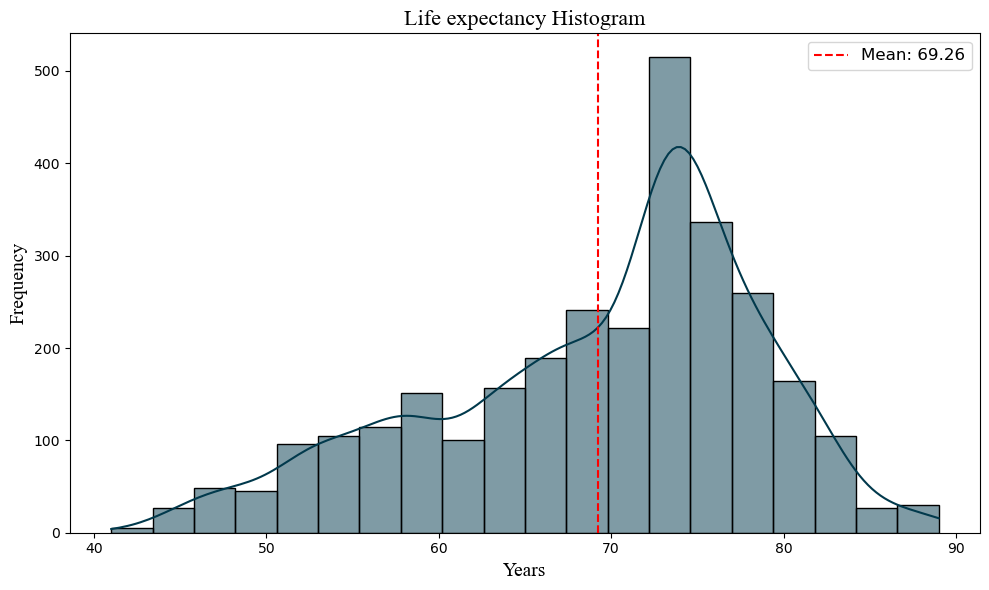

In [281]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Life expectancy'], errors='coerce').dropna()

plot_histogram(Data, title='Life expectancy Histogram', xlabel='Years', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman')

From the plot above we can see the average of life expectancy is around 69 years, and the most frequent value is around 75 years with a low thresholds of 89 and 42. The previous cell a general understanding to the distribution of the data can be generated as following, the cleaning of the data and the modelling changed the lower limits of the data effecting the value of the mean a little from _69.22_ into _69.26_ .

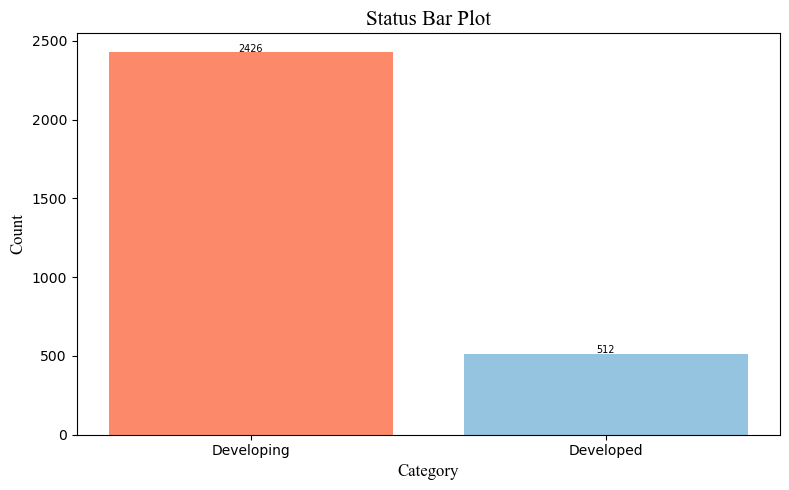

In [283]:
# Bar plot plotting
Data = lifeExpectancyDataframe['Status'].value_counts()
labels = Data.index
Data = Data.values

plot_categorical_bar(Data, labels, title='Status Bar Plot', xlabel='Category', ylabel='Count',
                     colors=None, fontname='Times New Roman', figsize=(8, 5), 
                     label_fontsize=12, title_fontsize=15, value_fontsize=7, 
                     text_offset=5)

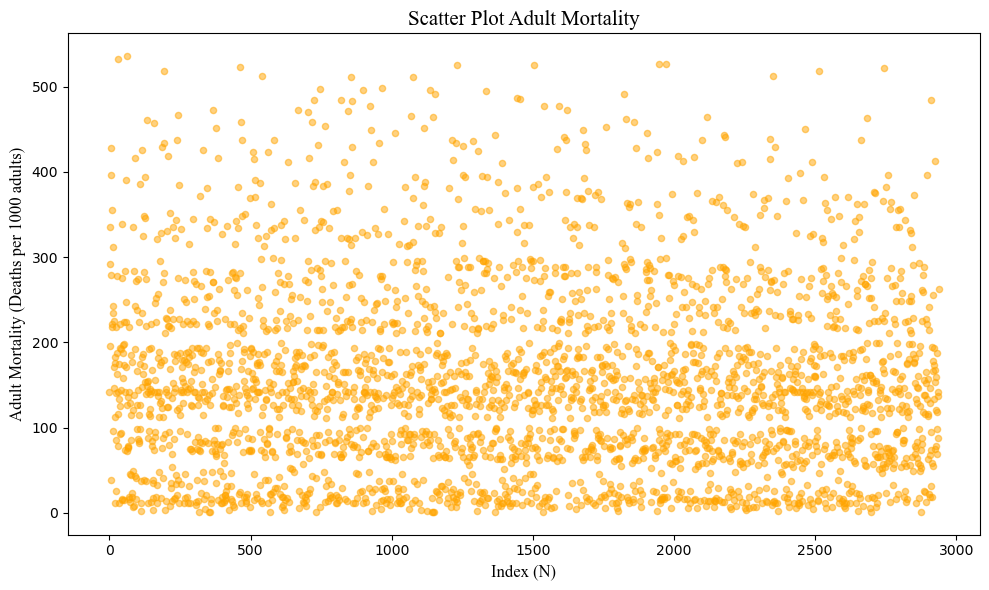

In [284]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Adult Mortality'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Adult Mortality', xlabel='Index (N)', ylabel='Adult Mortality (Deaths per 1000 adults)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

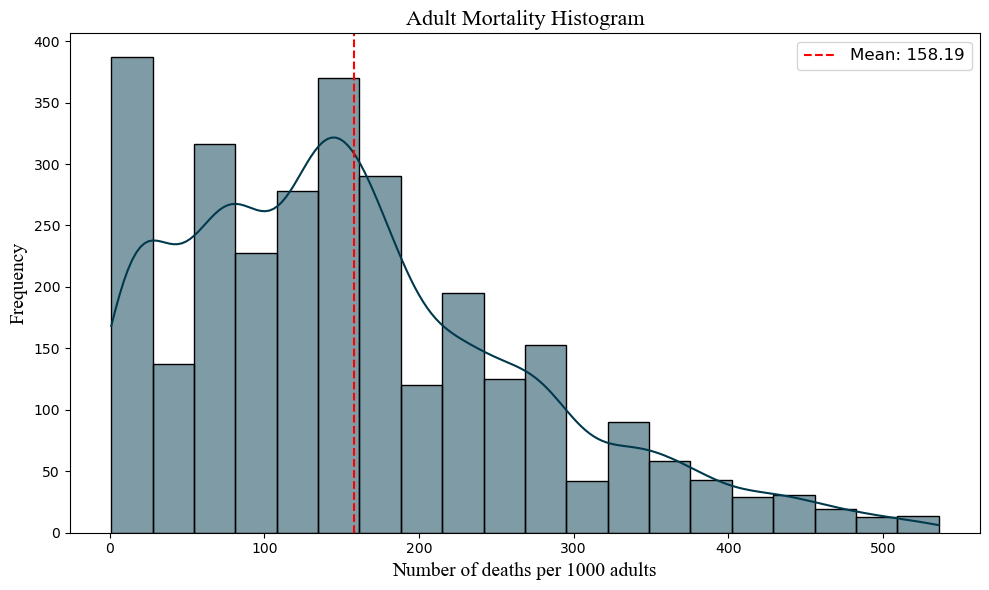

In [285]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Adult Mortality'], errors='coerce').dropna()

plot_histogram(Data, title='Adult Mortality Histogram', xlabel='Number of deaths per 1000 adults', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman')

From the figure above we can notice that the data is more skweed to the right side, with lower mean of 158.19 and lower high values. The feature renders the numbers of people how dies from the X to Y for each 1000 person. Based on the relative fact we can say the some countries have high death rates but the frequency of the countires is low.
As a comclusion the numbers of personal to die with in the range is a kind of low.

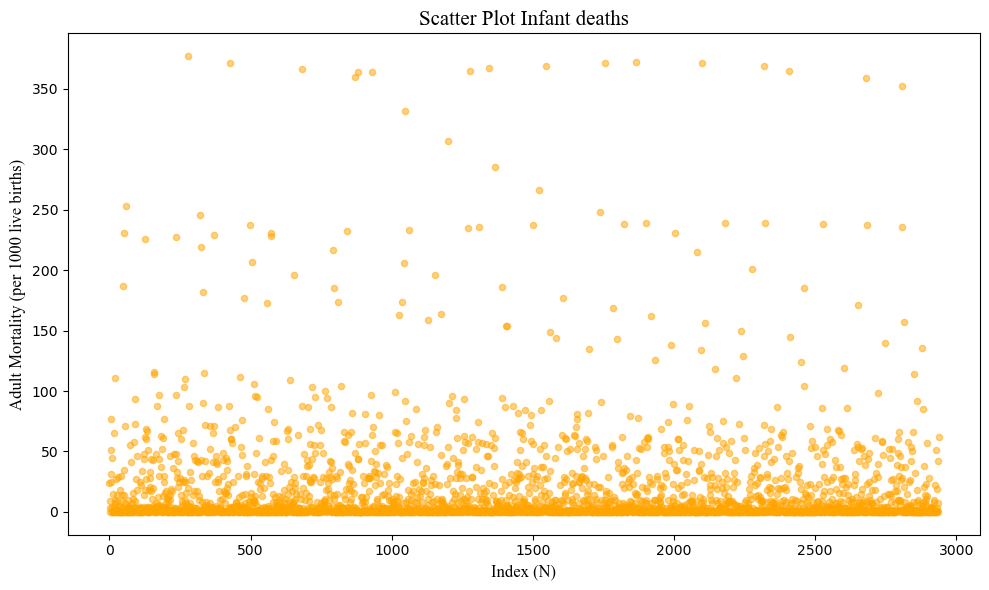

In [287]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Infant deaths'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Infant deaths', xlabel='Index (N)', ylabel='Adult Mortality (per 1000 live births)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

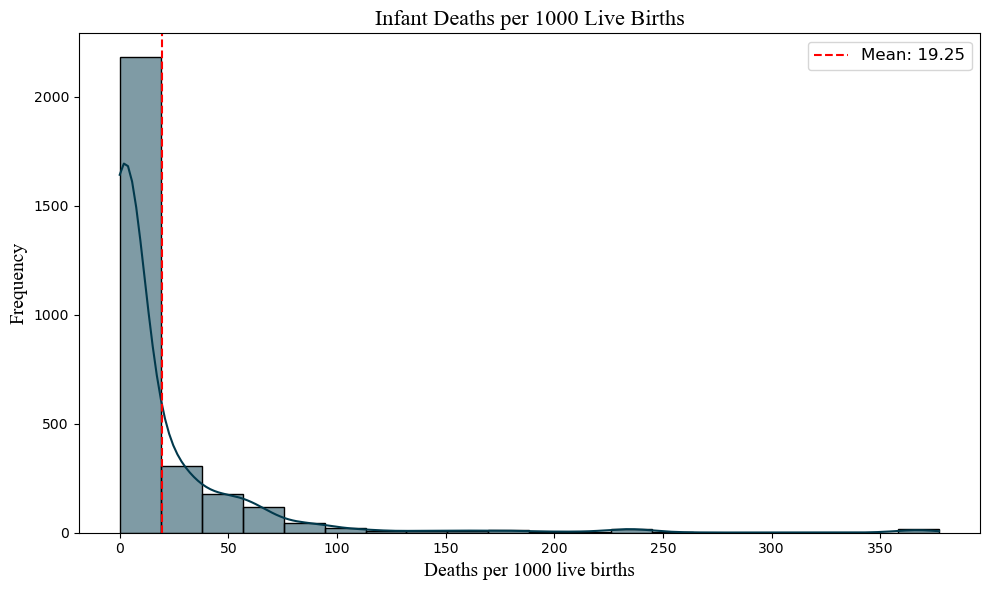

In [288]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Infant deaths'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Infant Deaths per 1000 Live Births',
               xlabel='Deaths per 1000 live births',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

Previously the plot showed possible outliers as the range maxed at 1000 and we had values exceeding the range of measuring. But after cleaning and modeling the range of data shrinked into 400 at max but still skewed to the right.

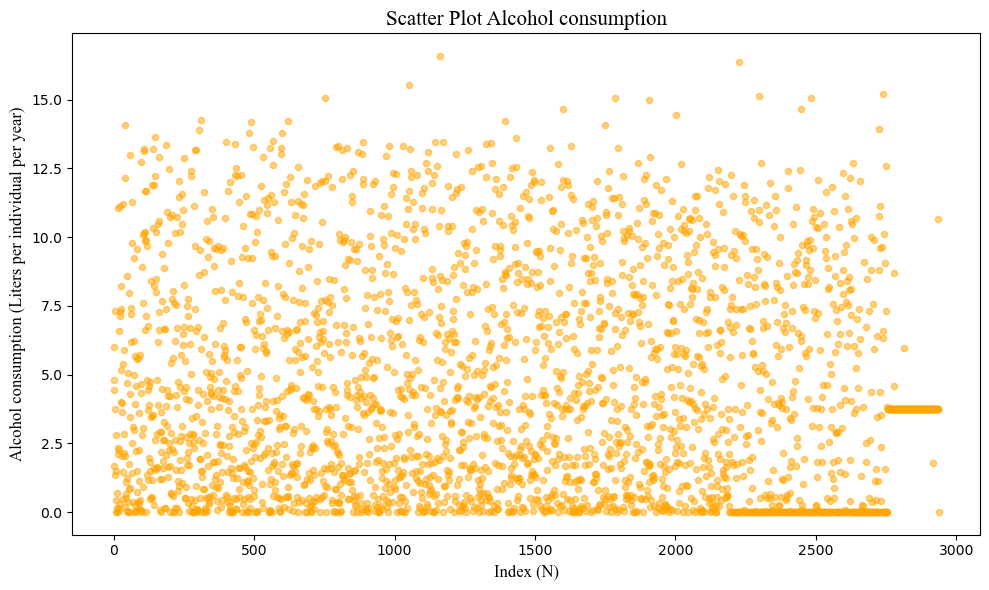

In [290]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Alcohol consumption'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Alcohol consumption', xlabel='Index (N)', ylabel='Alcohol consumption (Liters per individual per year)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

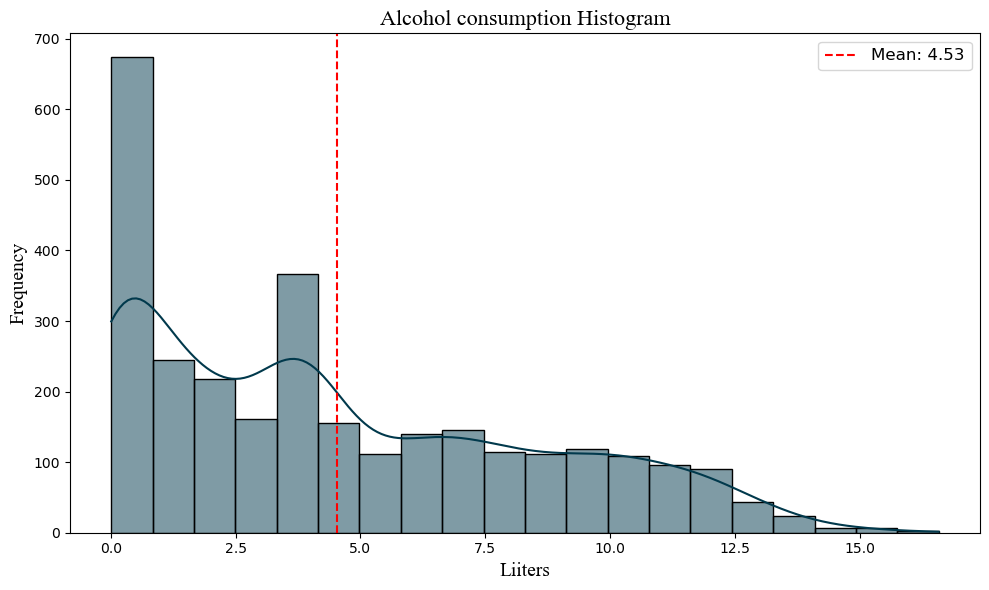

In [291]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Alcohol consumption'], errors='coerce').dropna()

plot_histogram(Data, title='Alcohol consumption Histogram', xlabel='Liiters', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman')

The value of the mean changed from _4.60_ to 4.53 with lowering in the upper bound of the data, because of the cleaning and handling process that replaced the outliers making the data more logical.

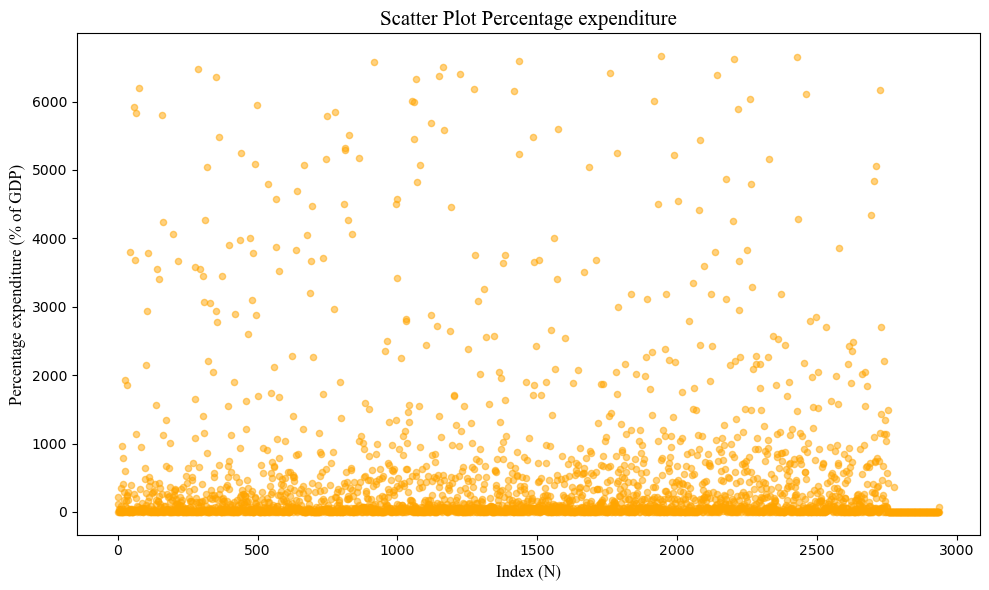

In [293]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Percentage expenditure'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Percentage expenditure', xlabel='Index (N)', ylabel='Percentage expenditure (% of GDP)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

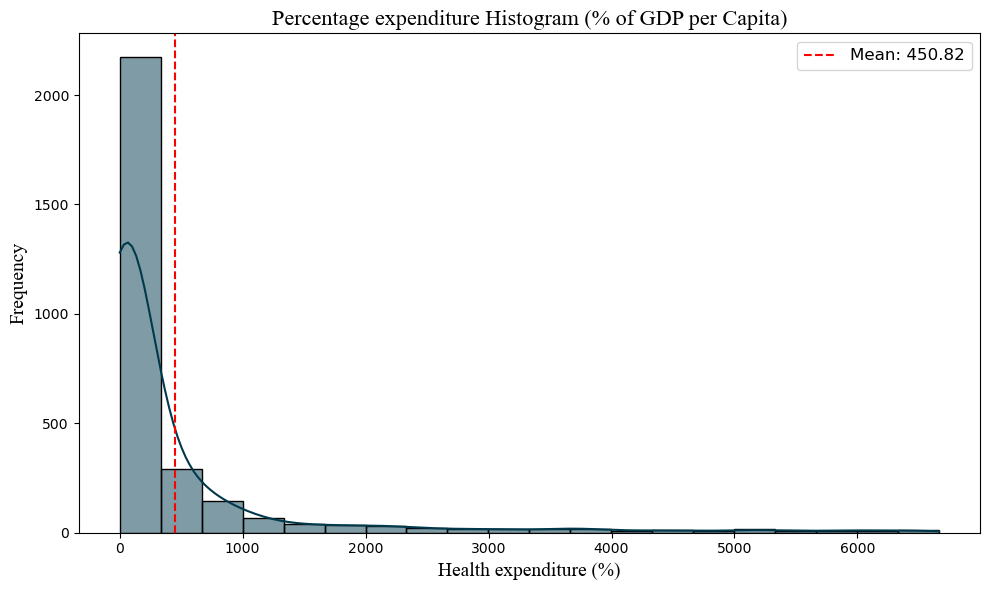

In [294]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Percentage expenditure'], errors='coerce').dropna()

plot_histogram(Data, title='Percentage expenditure Histogram (% of GDP per Capita)', xlabel='Health expenditure (%)', ylabel='Frequency',
                   color='#01394c', bins=20, show_kde=True, show_mean=True,
                   figsize=(10, 6), fontname='Times New Roman')

The value of the mean changed from _738.25_ to _450.82_ with increase in the upper bound of the data, because of the cleaning and handling process that repalced the outliers making the data more logical.

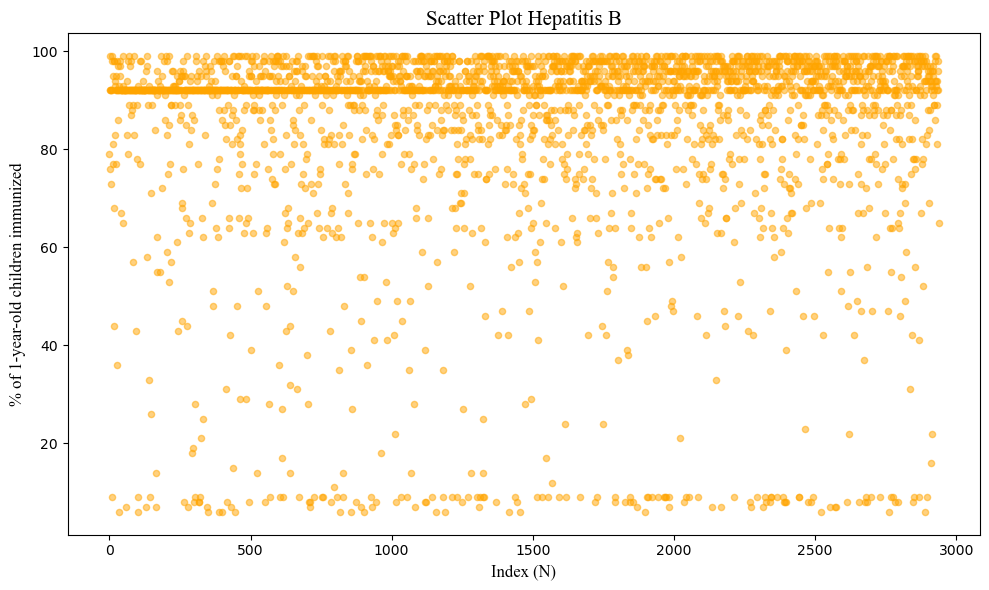

In [296]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Hepatitis B'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Hepatitis B', xlabel='Index (N)', ylabel='% of 1-year-old children immunized',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

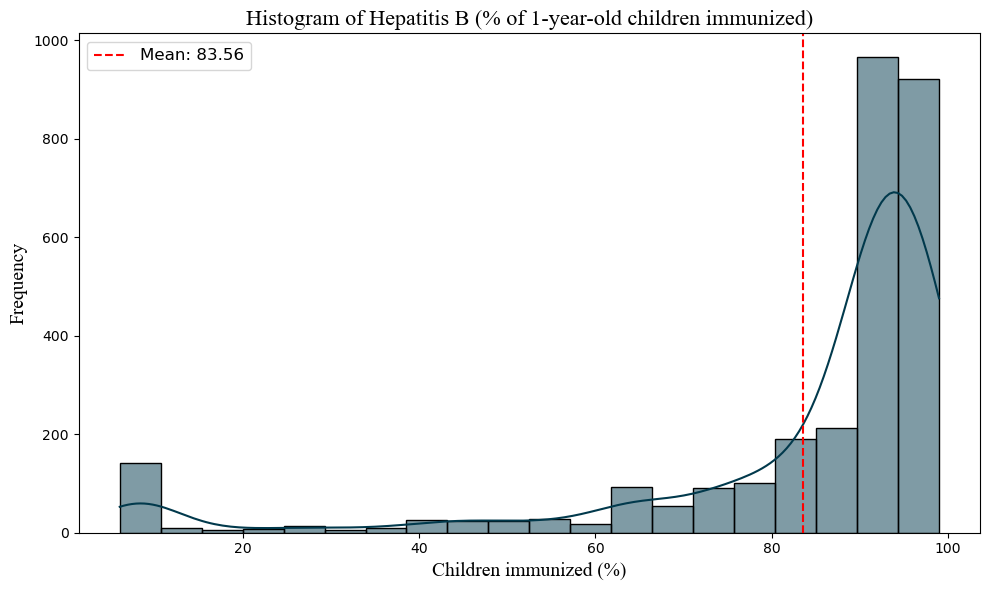

In [297]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Hepatitis B'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Hepatitis B (% of 1-year-old children immunized)',
               xlabel='Children immunized (%)',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The value of the mean changed from 80.94_ to _83.56_ with increase in the upper bound of the data, because of the cleaning and handling process that repalced the outliers making the data more logical.

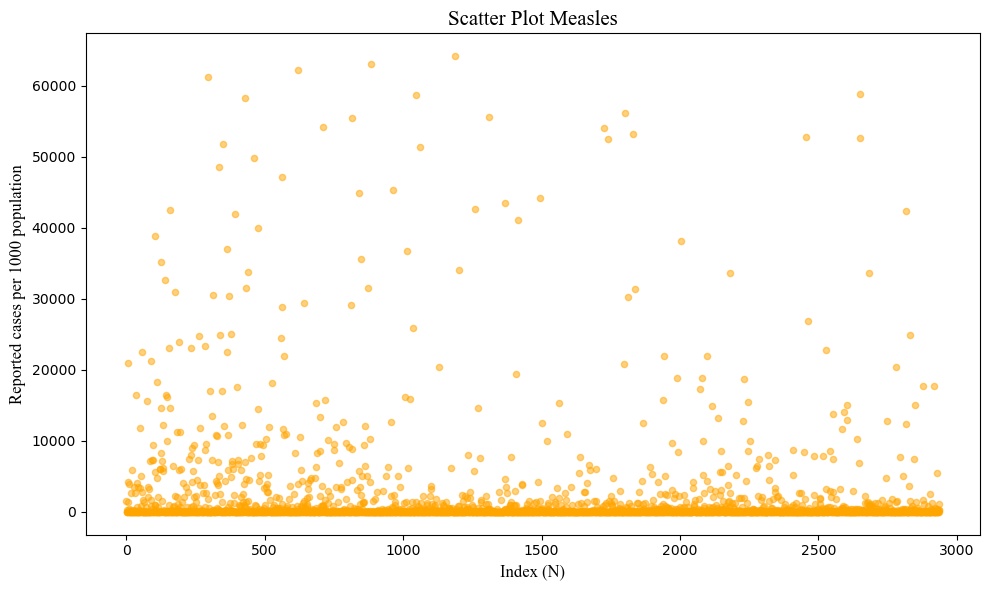

In [299]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Measles'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Measles', xlabel='Index (N)', ylabel='Reported cases per 1000 population',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

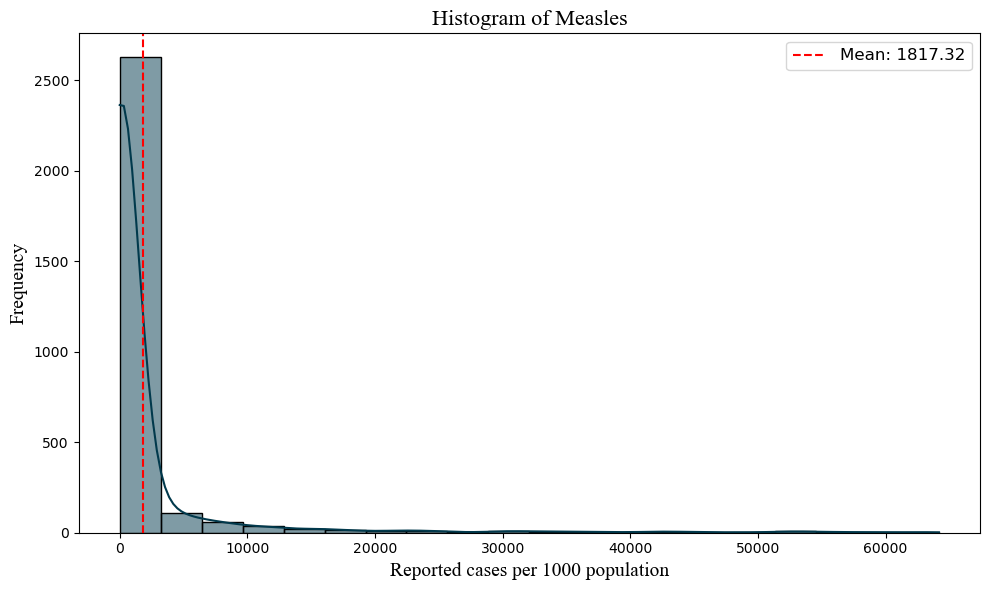

In [300]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Measles'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Measles',
               xlabel='Reported cases per 1000 population',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The value of the mean changed from _2419.59_ to _1817.32_ with decrease in the upper bound of the data, because of the cleaning and handling process that repalced the outliers making the data more logical.

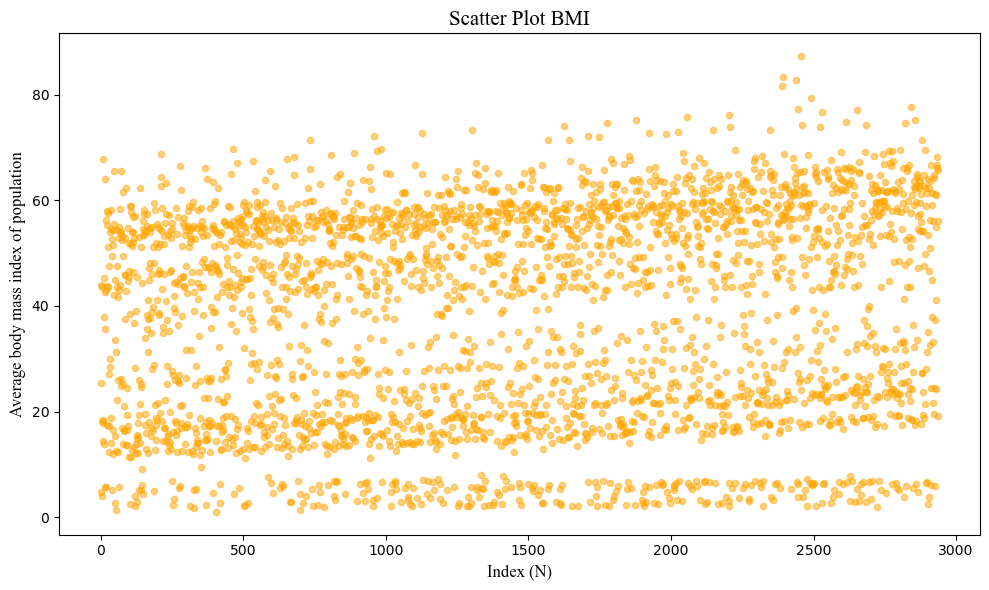

In [302]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['BMI'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot BMI', xlabel='Index (N)', ylabel='Average body mass index of population',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

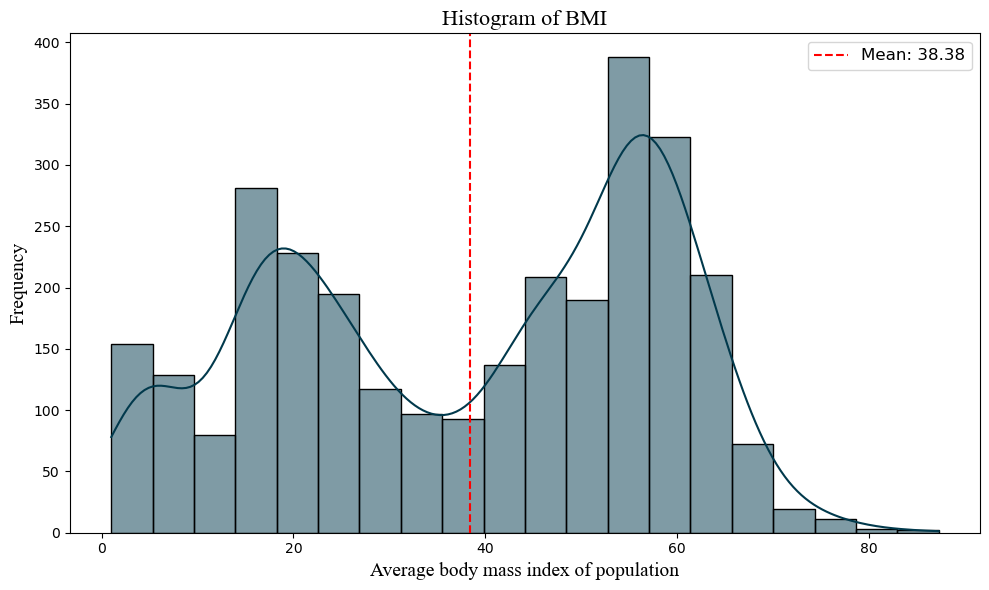

In [303]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['BMI'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of BMI',
               xlabel='Average body mass index of population',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

A small increase in the mean is noticed but in overall the data is distributed normally over the given range. 

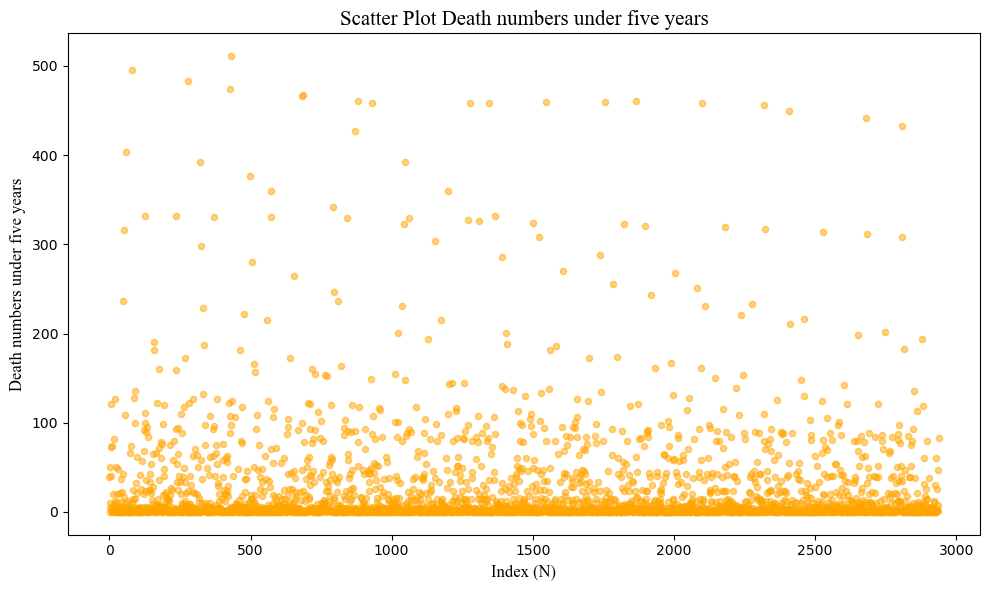

In [305]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Death numbers under-five'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Death numbers under five years', xlabel='Index (N)', ylabel='Death numbers under five years',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

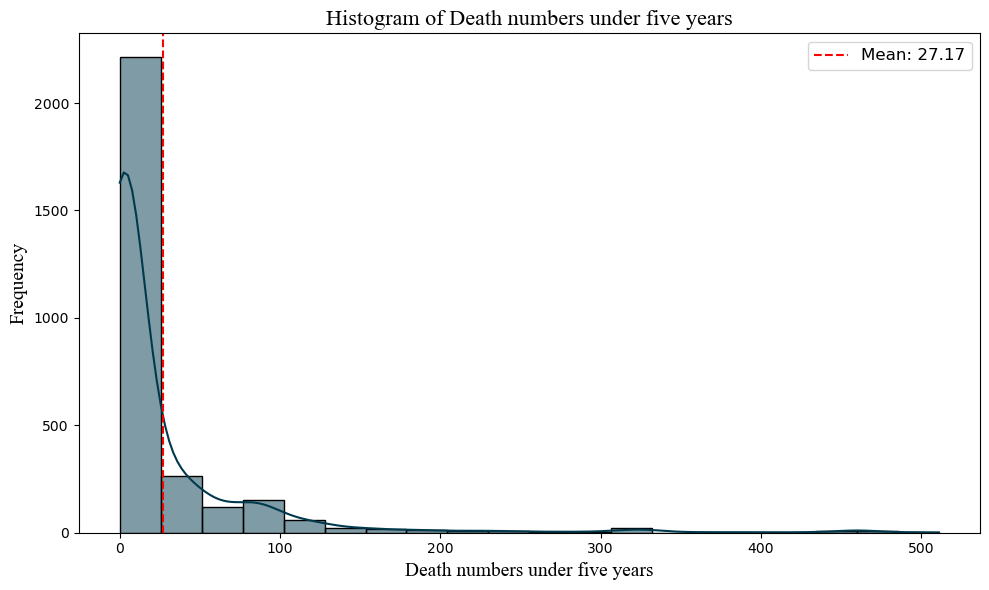

In [306]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Death numbers under-five'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Death numbers under five years',
               xlabel='Death numbers under five years',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The value of the mean changed from _42.02_ to _27.17_ with decrease in the upper bound of the data, because of the cleaning and handling process that repalced the outliers making the data more logical.

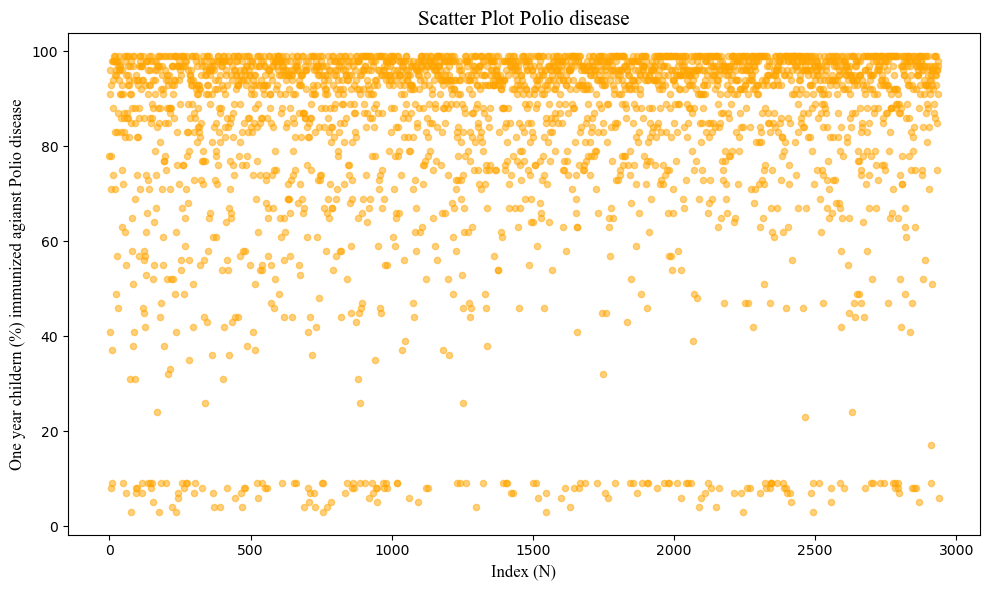

In [308]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Polio disease'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Polio disease', xlabel='Index (N)', ylabel='One year childern (%) immunized agianst Polio disease',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

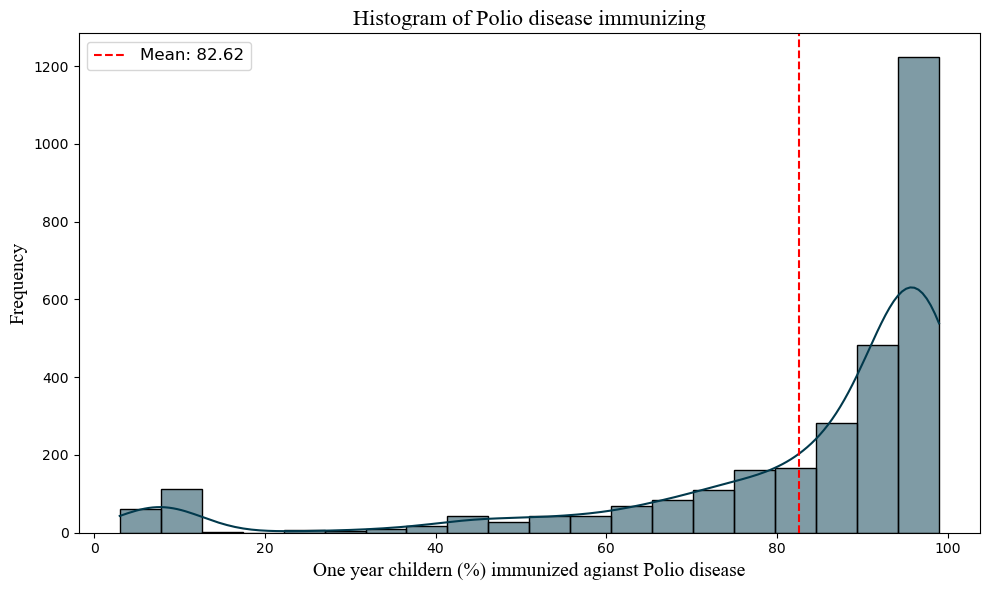

In [309]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Polio disease'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Polio disease immunizing',
               xlabel='One year childern (%) immunized agianst Polio disease',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The change in the mean is not that large to consider the cleaning and modeling effected the data. 

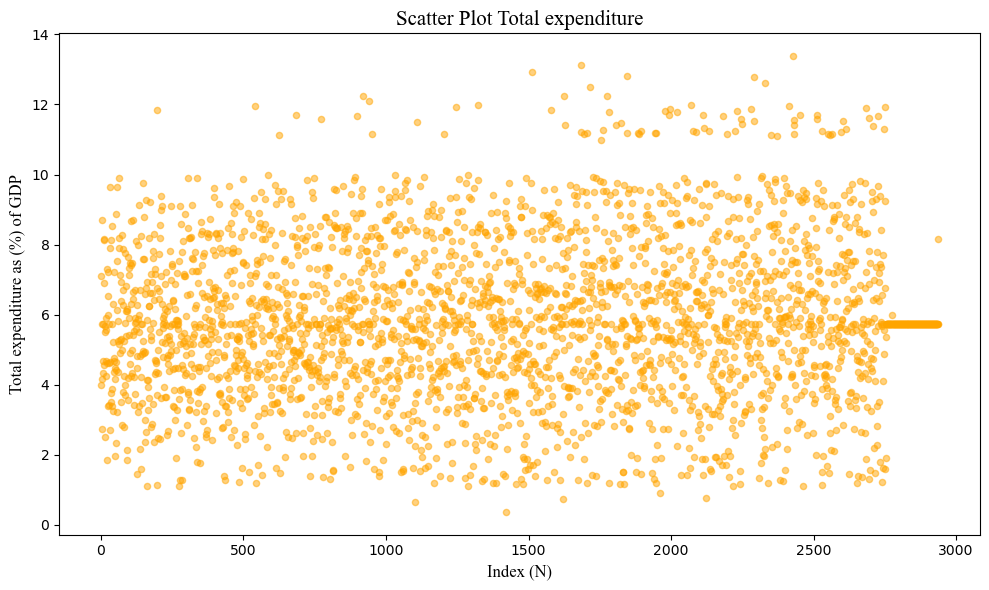

In [311]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Total expenditure'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Total expenditure', xlabel='Index (N)', ylabel='Total expenditure as (%) of GDP',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

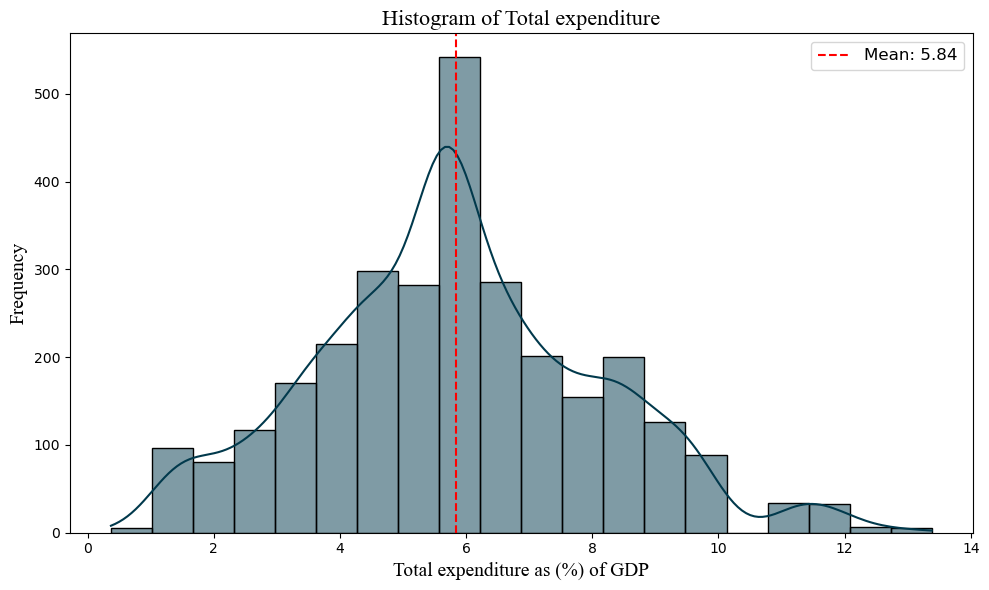

In [312]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Total expenditure'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Total expenditure',
               xlabel='Total expenditure as (%) of GDP',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The mean value decreases a little possible indicator to outliers that been replaced with in the modeling criteria and the over all data generally looks normally distributed.

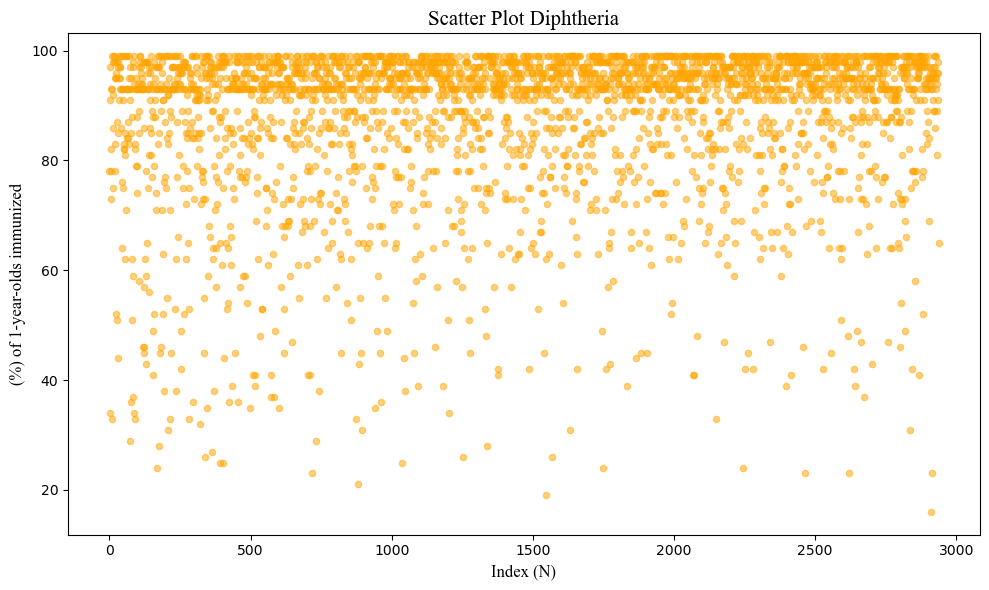

In [314]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Diphtheria'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Diphtheria', xlabel='Index (N)', ylabel='(%) of 1-year-olds immunized',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

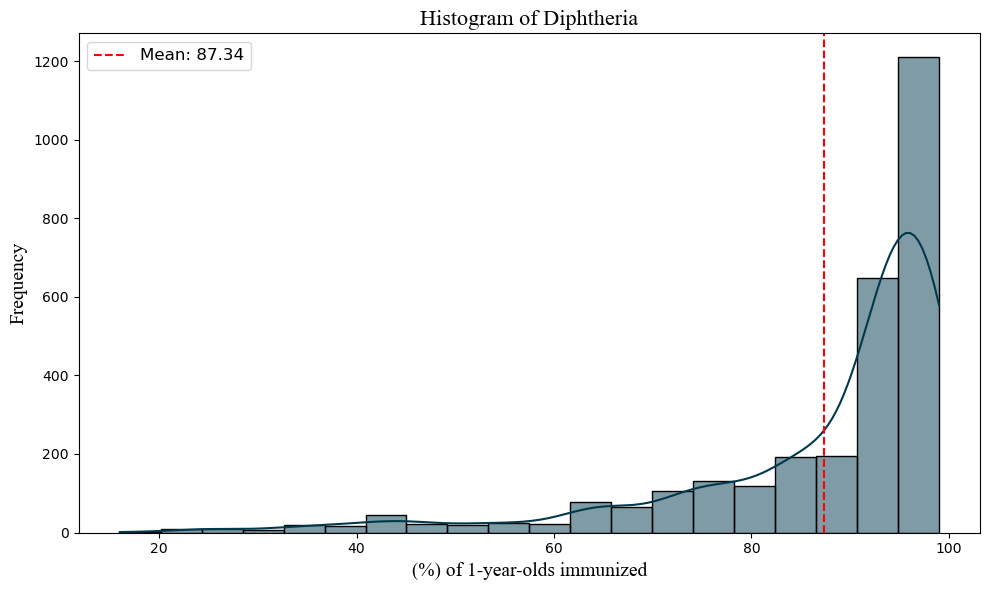

In [315]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Diphtheria'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Diphtheria',
               xlabel='(%) of 1-year-olds immunized',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The mean value increased from _82.32_ to _87.34_ possibly the modeling replaced the null values and outliers with new real values. 

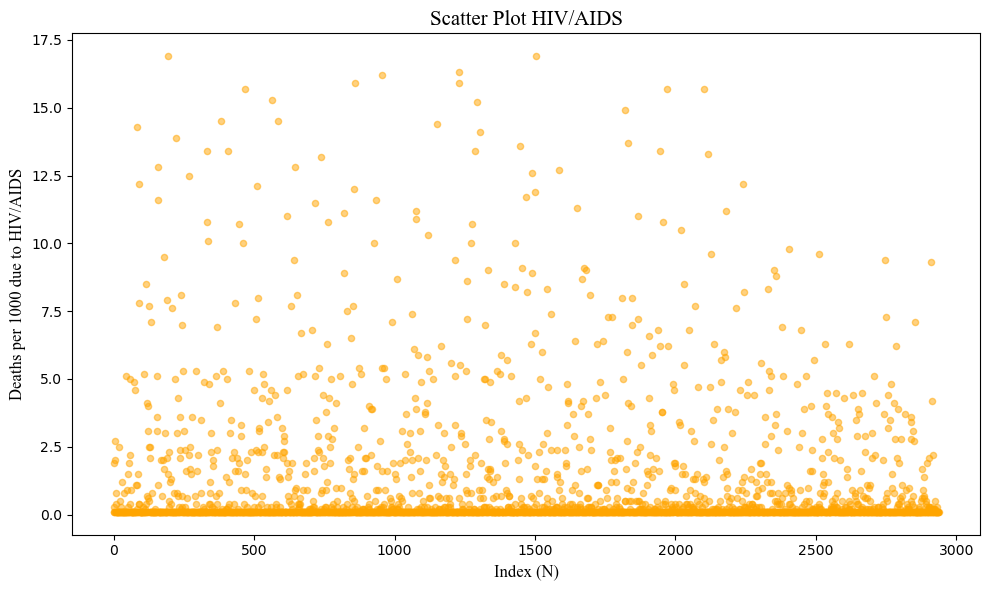

In [317]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['HIV/AIDS'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot HIV/AIDS', xlabel='Index (N)', ylabel='Deaths per 1000 due to HIV/AIDS',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

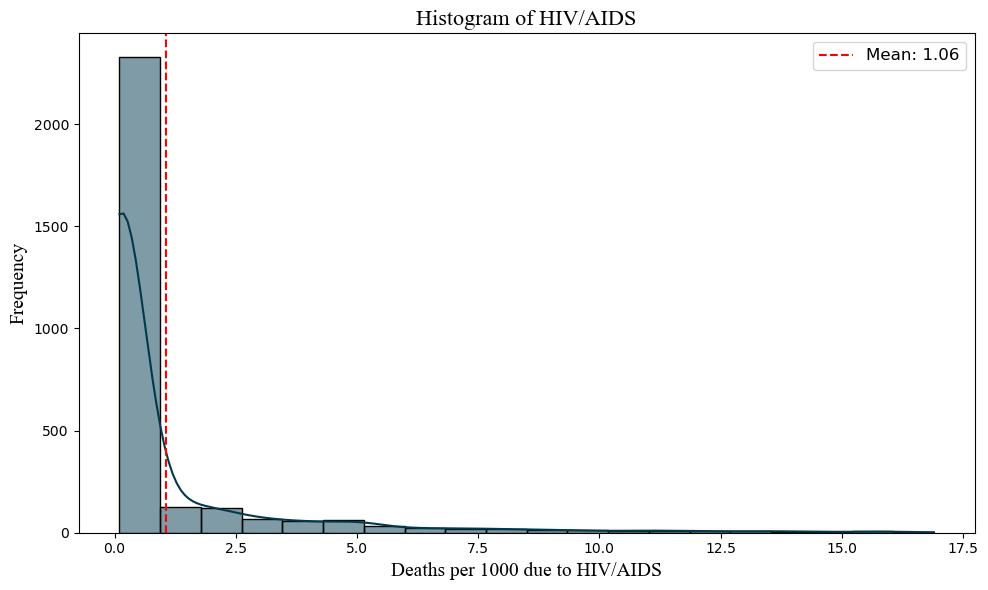

In [318]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['HIV/AIDS'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of HIV/AIDS',
               xlabel='Deaths per 1000 due to HIV/AIDS',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The mean value decreases from _1.74_ into _1.06_ possible indicator to outliers and new values have been models.

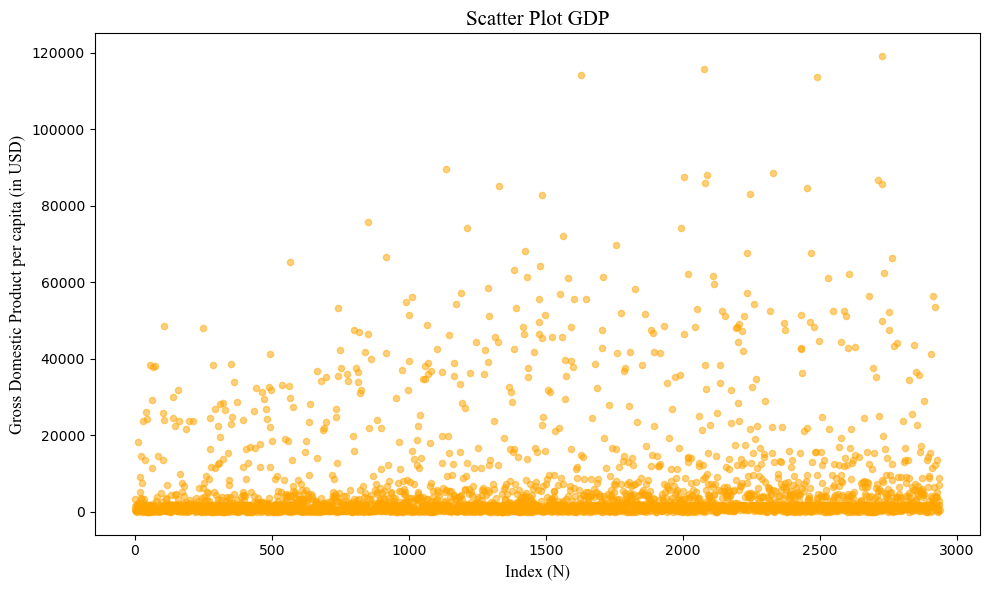

In [320]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['GDP'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot GDP', xlabel='Index (N)', ylabel='Gross Domestic Product per capita (in USD)',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

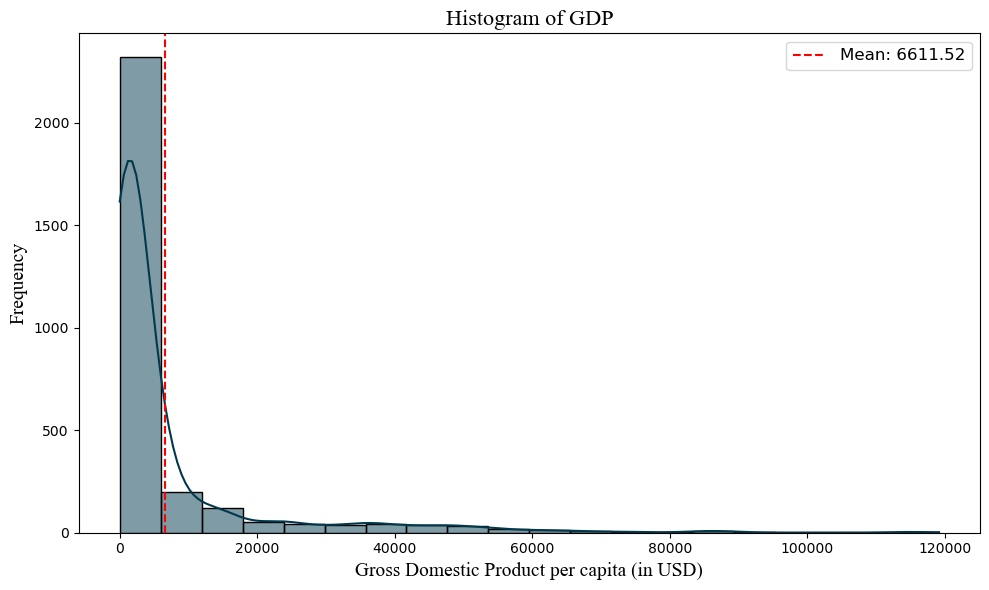

In [321]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['GDP'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of GDP',
               xlabel='Gross Domestic Product per capita (in USD)',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The mean value has decreases from _7483.16_ into 6611.52 holding the same structure the modeling of the data and outliers are direct reasons to the change in the mean value.

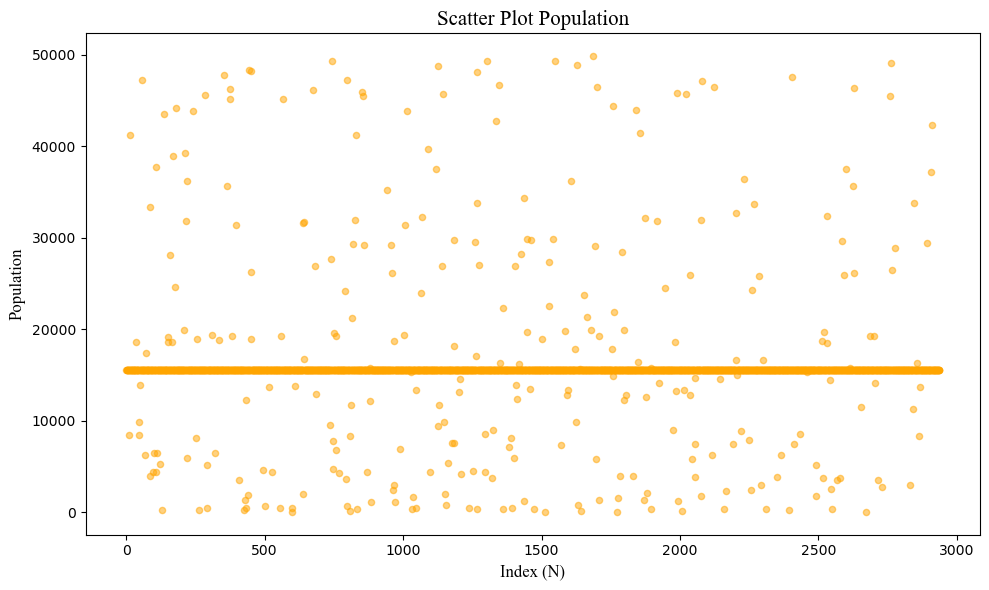

In [323]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Population'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Population', xlabel='Index (N)', ylabel='Population',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

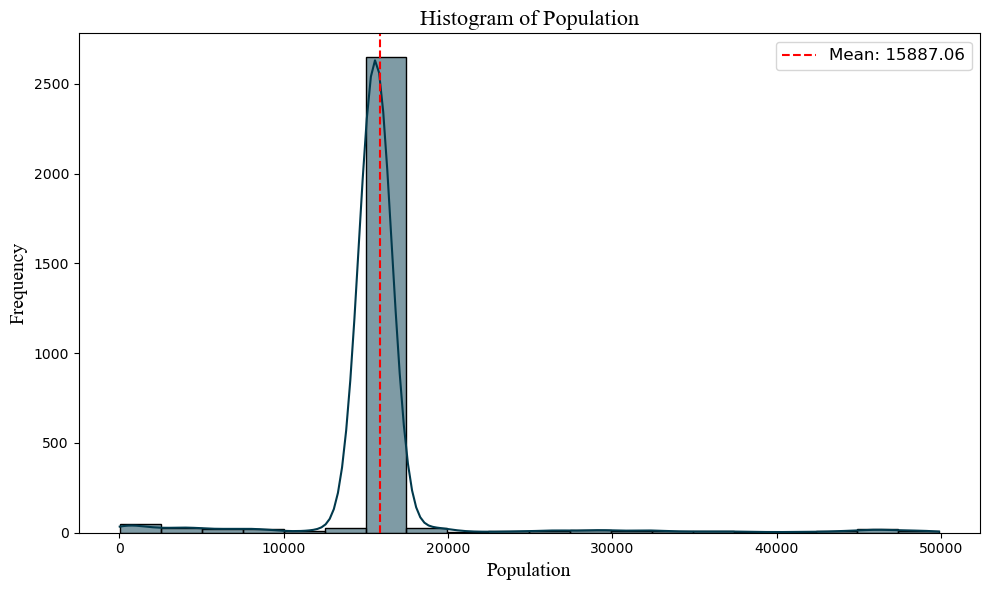

In [324]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Population'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Population',
               xlabel='Population',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The distribution of the data has completely changed effecting the mean of the population because of the modeling criteria which as far as I think it was the wrong method for this case.

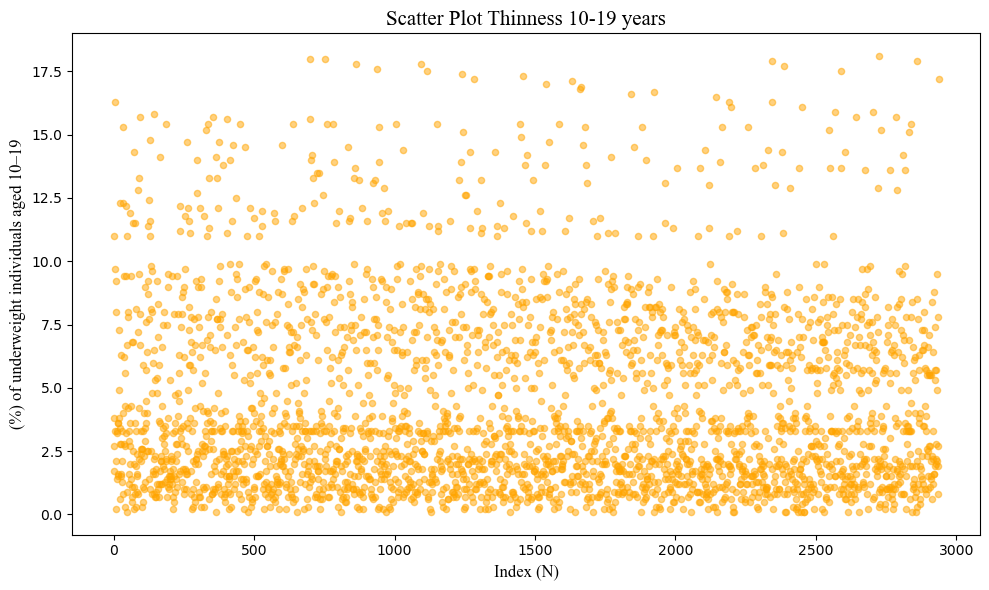

In [326]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 10-19 years'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Thinness 10-19 years', xlabel='Index (N)', ylabel='(%) of underweight individuals aged 10–19',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

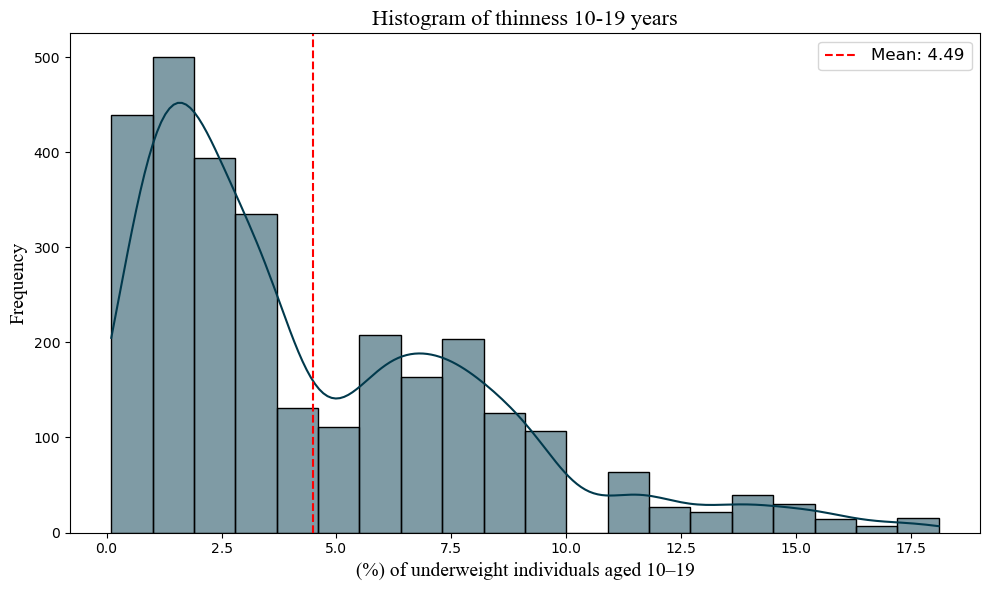

In [327]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 10-19 years'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of thinness 10-19 years',
               xlabel='(%) of underweight individuals aged 10–19',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The mean value has decreases a litle indicating to outliers or null values or both but the numbers are small relative to the rest of the data. 

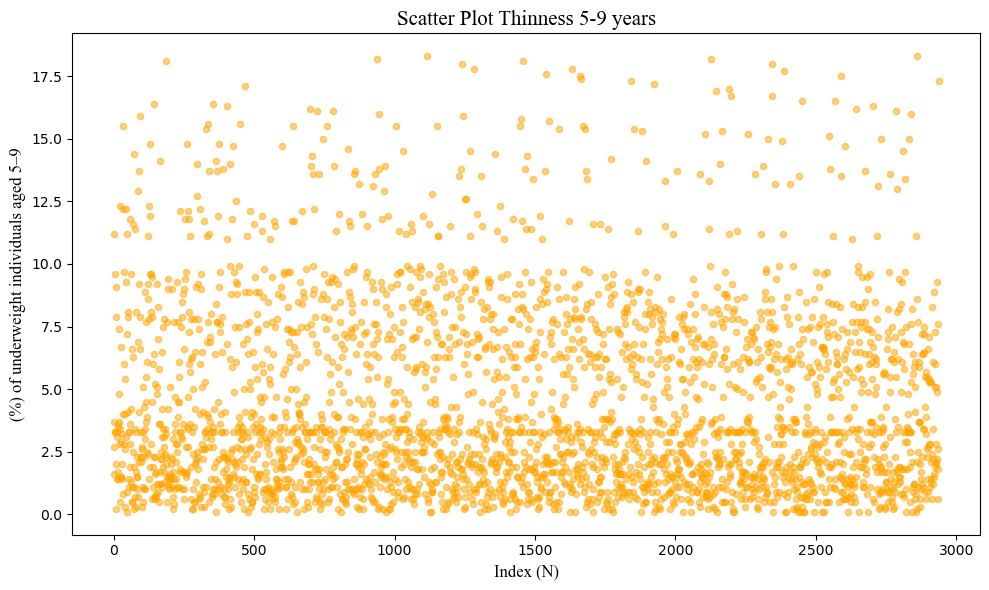

In [329]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 5-9 years'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Thinness 5-9 years', xlabel='Index (N)', ylabel='(%) of underweight individuals aged 5–9',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

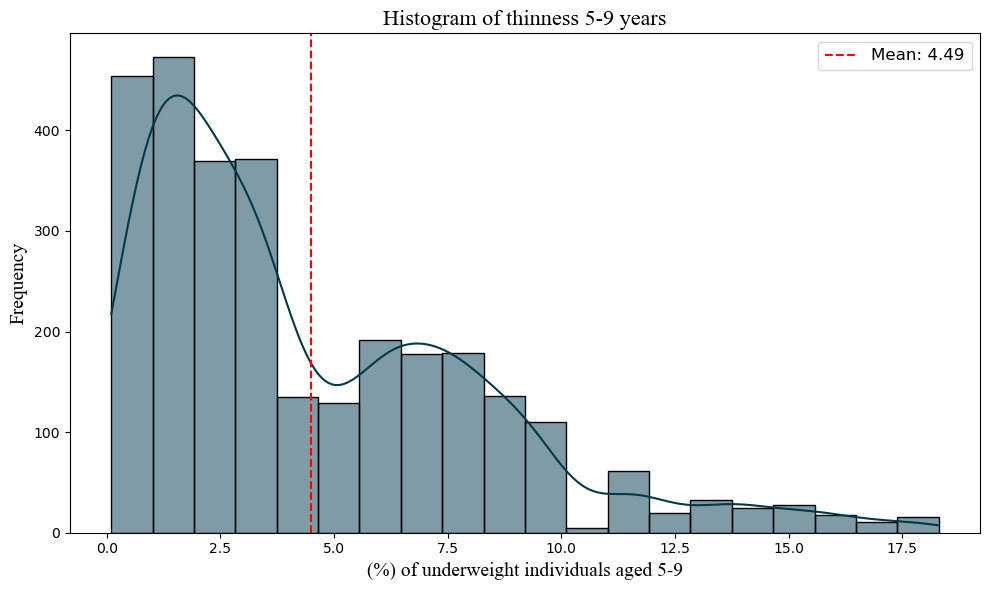

In [330]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Thinness 5-9 years'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of thinness 5-9 years',
               xlabel='(%) of underweight individuals aged 5-9',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The mean value has decreases a litle indicating to outliers or null values or both but the numbers are small relative to the rest of the data. 

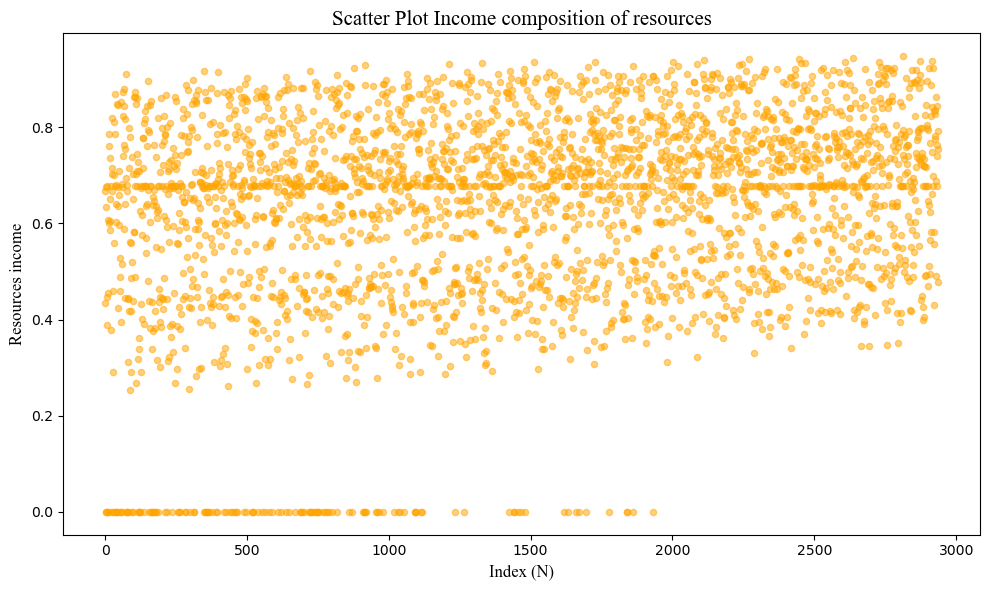

In [332]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Income composition of resources'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Income composition of resources', xlabel='Index (N)', ylabel='Resources income',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

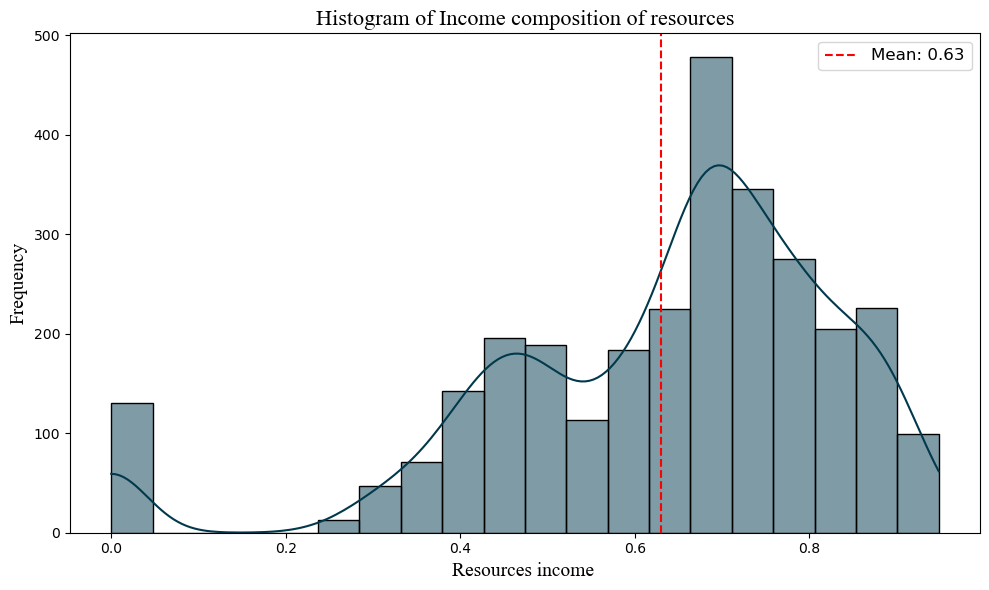

In [333]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Income composition of resources'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Income composition of resources',
               xlabel='Resources income ',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

There is no change on the mean, data is not effect by the modeling and does not contain outlers. 

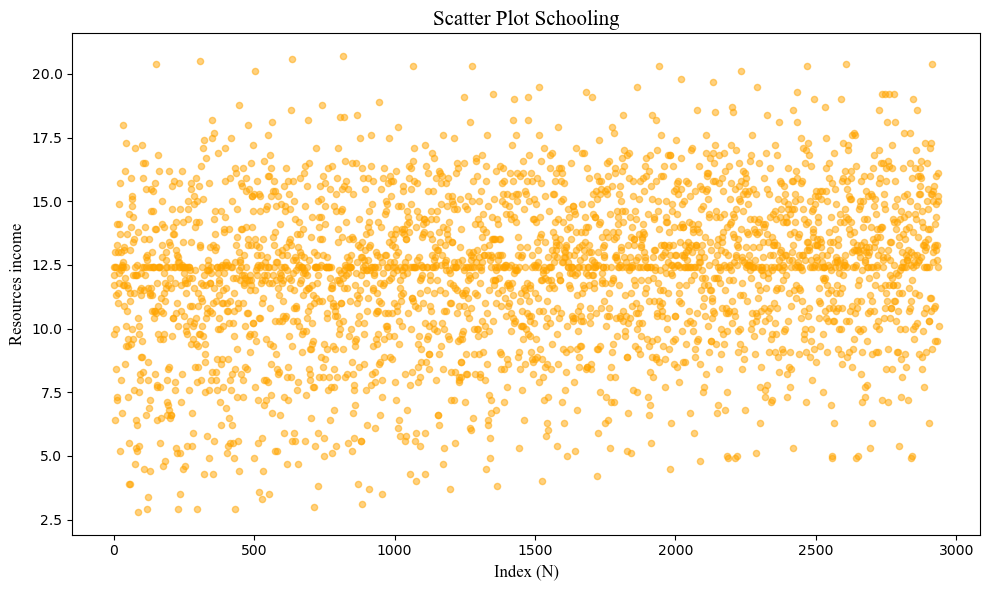

In [335]:
#Scatter plot plotting 
Data = pd.to_numeric(lifeExpectancyDataframe['Schooling'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Schooling', xlabel='Index (N)', ylabel='Resources income',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

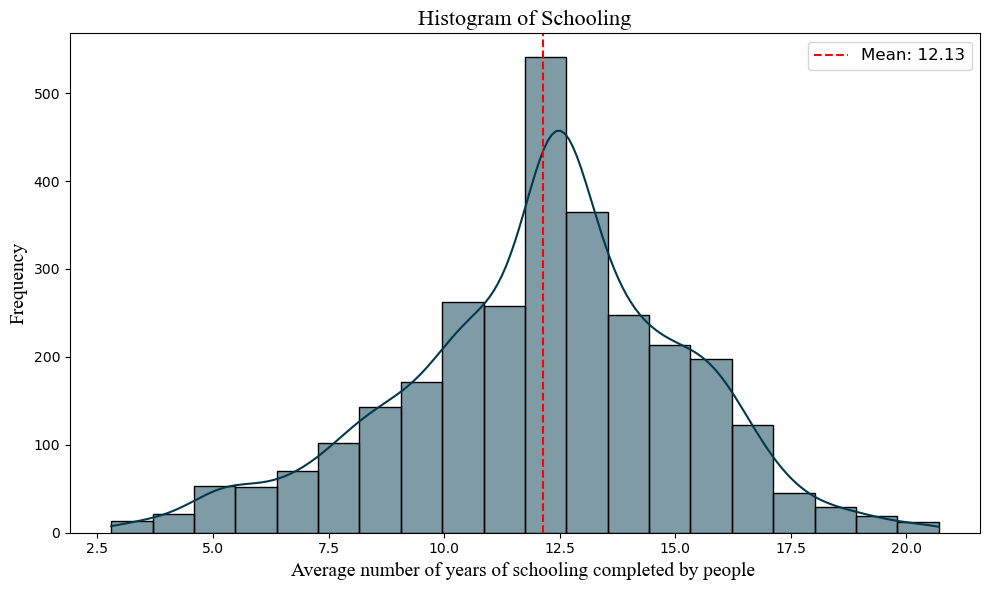

In [336]:
# Histogram plotting
Data = pd.to_numeric(lifeExpectancyDataframe['Schooling'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Schooling',
               xlabel='Average number of years of schooling completed by people ',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

The mean increases from _11.99_ into _12.13_ based on the modeling criteria. 

In [338]:
lifeExpectancyDataframe.head(5)

Country    Year      Status  Life expectancy  Adult Mortality  \
0           Zimbabwe  2000.0  Developing        46.000000            142.0   
1             Belize  2000.0  Developing        68.300003            196.0   
2         Kazakhstan  2000.0  Developing        63.900002            292.0   
3  Equatorial Guinea  2000.0  Developing        52.700001            336.0   
4        South Sudan  2000.0  Developing        48.900002             38.0   

   Infant deaths  Alcohol consumption  Percentage expenditure  Hepatitis B  \
0           24.0                 1.68                0.000000         79.0   
1            0.0                 4.79              219.023987         76.0   
2            9.0                 6.00              112.541161         99.0   
3            3.0                 4.46               14.954514         92.0   
4           31.0                 3.74                0.000000         92.0   

   Measles  ...  Polio disease  Total expenditure  Diphtheria  HIV/AIDS  \
0   1483.0  ...           78.0               7.10        78.0       0.1   
1      0.0  ...           91.0               3.98        91.0       0.3   
2    245.0  ...           96.0               4.16        97.0       0.1   
3      0.0  ...           41.0               2.73        34.0       1.9   
4      0.0  ...           93.0               5.72        93.0       2.7   

           GDP  Population  Thinness 5-9 years  Thinness 10-19 years  \
0   547.358887     15578.0                11.2                  11.0   
1  3364.423828     15578.0                 3.7                   3.8   
2  1229.958008     15578.0                 2.7                   2.7   
3   172.684906     15578.0                 1.6                   1.7   
4  1766.947571     15578.0                 3.3                   3.3   

   Income composition of resources  Schooling  
0                            0.434        9.8  
1                            0.668       11.7  
2                            0.676       12.1  
3                            0.000       12.4  
4                            0.000       12.4  

[5 rows x 22 columns]

## _Exploration Second Dataframe -before cleaning:_

### Column one: 

In [341]:
# Investigating the data of the column 
HealthExpenditureDataframe['Year']

0     2015
1     2014
2     2013
3     2012
4     2011
5     2010
6     2009
7     2008
8     2007
9     2006
10    2005
11    2004
12    2003
13    2002
14    2001
15    2000
Name: Year, dtype: int64

In [342]:
# Arranging the data to match the other dataset
HealthExpenditureDataframe.sort_values('Year', ascending=True).reset_index(drop=True)

Year  Health_Expenditure_%_GDP
0   2000                  6.617313
1   2001                  7.018181
2   2002                  6.922676
3   2003                  6.855439
4   2004                  6.800597
5   2005                  6.903250
6   2006                  6.709723
7   2007                  6.695371
8   2008                  6.828302
9   2009                  6.916369
10  2010                  6.888176
11  2011                  6.839191
12  2012                  6.976485
13  2013                  6.958152
14  2014                  7.045307
15  2015                  7.022178

In [343]:
# checking for missing items and their count
print("Nan values sum: " + str(HealthExpenditureDataframe['Year'].isna().sum()))

Nan values sum: 0


### Column two:

In [345]:
# Renaming the feature
HealthExpenditureDataframe = HealthExpenditureDataframe.rename(columns={'Health_Expenditure_%_GDP': 'Health Expenditure'})

In [346]:
HealthExpenditureDataframe

Year  Health Expenditure
0   2015            7.022178
1   2014            7.045307
2   2013            6.958152
3   2012            6.976485
4   2011            6.839191
5   2010            6.888176
6   2009            6.916369
7   2008            6.828302
8   2007            6.695371
9   2006            6.709723
10  2005            6.903250
11  2004            6.800597
12  2003            6.855439
13  2002            6.922676
14  2001            7.018181
15  2000            6.617313

In [347]:
print("Nan values sum: " + str(HealthExpenditureDataframe['Health Expenditure'].isna().sum()))

Nan values sum: 0


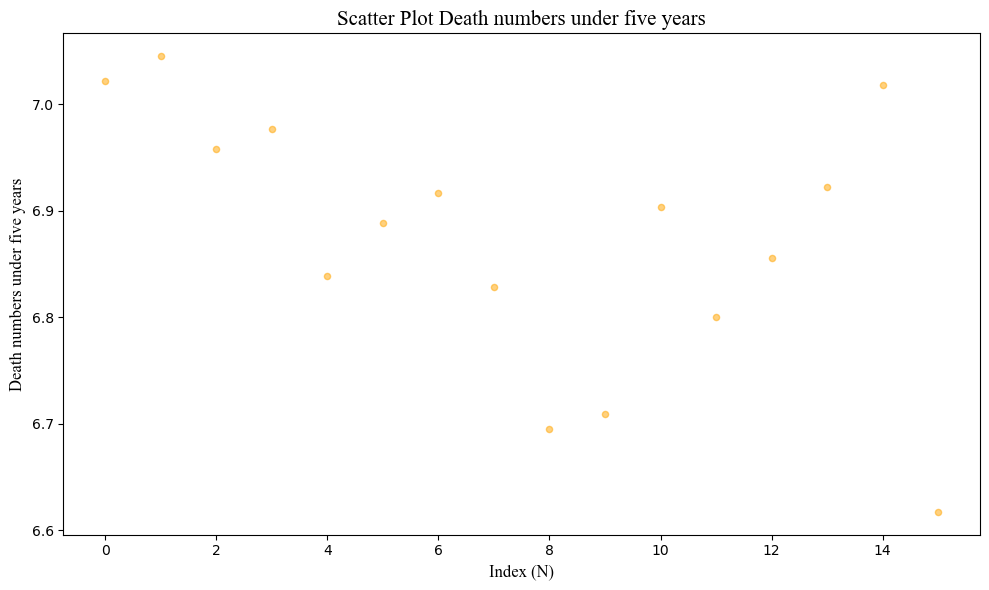

In [348]:
#Scatter plot plotting 
Data = pd.to_numeric(HealthExpenditureDataframe['Health Expenditure'], errors='coerce').dropna()

plot_scatter(Data, title='Scatter Plot Death numbers under five years', xlabel='Index (N)', ylabel='Death numbers under five years',
                 color='#FFA500', alpha=0.5, point_size=20, figsize=(10, 6),
                 fontname='Times New Roman')

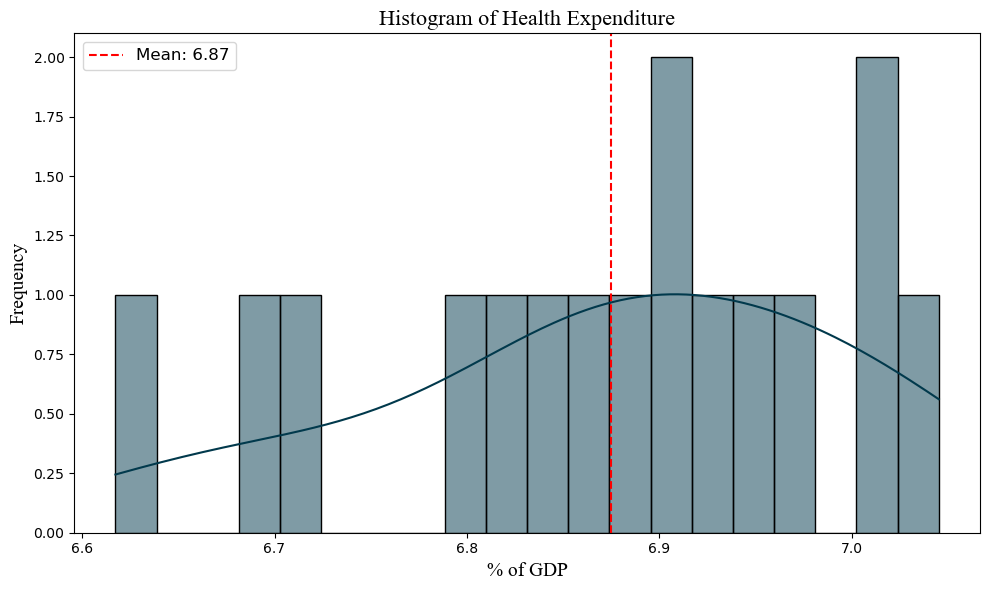

In [349]:
# Histogram plotting
Data = pd.to_numeric(HealthExpenditureDataframe['Health Expenditure'], errors='coerce').dropna()

plot_histogram(Data, 
               title='Histogram of Health Expenditure',
               xlabel='% of GDP',
               ylabel='Frequency',
               color='#01394c',
               bins=20,
               show_kde=True,
               show_mean=True,
               figsize=(10, 6),
               fontname='Times New Roman')

As can be shown from the plot a slightly right-skewed, with most values clustered around the mean of _6.87%_, as shown by the red dashed line. This suggests that while health spending is generally consistent across the observed countries or years, there are instances of slightly higher expenditures that pull the average up. 

In [351]:
# Data Cleaning Summary Cell -Dataframe one
print("Missing values per column:\n", lifeExpectancyDataframe.isna().sum())
print("\nDuplicate rows:", lifeExpectancyDataframe.duplicated().sum())
print("\nData types:\n", lifeExpectancyDataframe.dtypes)

Missing values per column:
 Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
Infant deaths                      0
Alcohol consumption                0
Percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
Death numbers under-five           0
Polio disease                      0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
Thinness 5-9 years                 0
Thinness 10-19 years               0
Income composition of resources    0
Schooling                          0
dtype: int64

Duplicate rows: 0

Data types:
 Country                              object
Year                                float64
Status                  

In [352]:
# Data Cleaning Summary Cell -Dataframe two
print("Missing values per column:\n", HealthExpenditureDataframe.isna().sum())
print("\nDuplicate rows:", HealthExpenditureDataframe.duplicated().sum())
print("\nData types:\n", HealthExpenditureDataframe.dtypes)

Missing values per column:
 Year                  0
Health Expenditure    0
dtype: int64

Duplicate rows: 0

Data types:
 Year                    int64
Health Expenditure    float64
dtype: object


In [353]:
mergedDataframe = pd.merge(lifeExpectancyDataframe, HealthExpenditureDataframe, on='Year', how='left')
mergedDataframe.to_csv('final_dataset.csv', index=False)
mergedDataframe

Country    Year      Status  \
0                                              Zimbabwe  2000.0  Developing   
1                                                Belize  2000.0  Developing   
2                                            Kazakhstan  2000.0  Developing   
3                                     Equatorial Guinea  2000.0  Developing   
4                                           South Sudan  2000.0  Developing   
...                                                 ...     ...         ...   
2933  United Kingdom of Great Britain and Northern I...  2015.0   Developed   
2934                                       Saudi Arabia  2015.0  Developing   
2935                                           Bulgaria  2015.0   Developed   
2936                                             Brazil  2015.0  Developing   
2937                                        Afghanistan  2015.0  Developing   

      Life expectancy  Adult Mortality  Infant deaths  Alcohol consumption  \
0           46.000000            142.0           24.0                 1.68   
1           68.300003            196.0            0.0                 4.79   
2           63.900002            292.0            9.0                 6.00   
3           52.700001            336.0            3.0                 4.46   
4           48.900002             38.0           31.0                 3.74   
...               ...              ...            ...                  ...   
2933        81.199997             69.0            3.0                10.66   
2934        74.500000             88.0            7.0                 3.74   
2935        74.500000            137.0            0.0                 3.74   
2936        75.000000            142.0           42.0                 3.74   
2937        65.000000            263.0           62.0                 0.01   

      Percentage expenditure  Hepatitis B  Measles  ...  Total expenditure  \
0                   0.000000         79.0   1483.0  ...               7.10   
1                 219.023987         76.0      0.0  ...               3.98   
2                 112.541161         99.0    245.0  ...               4.16   
3                  14.954514         92.0      0.0  ...               2.73   
4                   0.000000         92.0      0.0  ...               5.72   
...                      ...          ...      ...  ...                ...   
2933                0.000000         92.0     91.0  ...               5.72   
2934                0.000000         98.0    219.0  ...               5.72   
2935                0.000000         92.0      0.0  ...               5.72   
2936                0.000000         96.0    214.0  ...               5.72   
2937               71.279625         65.0   1154.0  ...               8.16   

      Diphtheria  HIV/AIDS          GDP  Population  Thinness 5-9 years  \
0           78.0       0.1   547.358887     15578.0           11.200000   
1           91.0       0.3  3364.423828     15578.0            3.700000   
2           97.0       0.1  1229.958008     15578.0            2.700000   
3           34.0       1.9   172.684906     15578.0            1.600000   
4           93.0       2.7  1766.947571     15578.0            3.300000   
...          ...       ...          ...         ...                 ...   
2933        96.0       0.1  1766.947571     15578.0            0.600000   
2934        98.0       0.1  2732.861816     15578.0            7.600000   
2935        91.0       0.1  6993.477539     15578.0            1.800000   
2936        96.0       0.1  8757.261719     15578.0            2.600000   
2937        65.0       0.1   584.259216     15578.0           17.299999   

      Thinness 10-19 years  Income composition of resources  Schooling  \
0                11.000000                            0.434        9.8   
1                 3.800000                            0.668       11.7   
2                 2.700000                            0.676       12.1   
3                 1.700000  

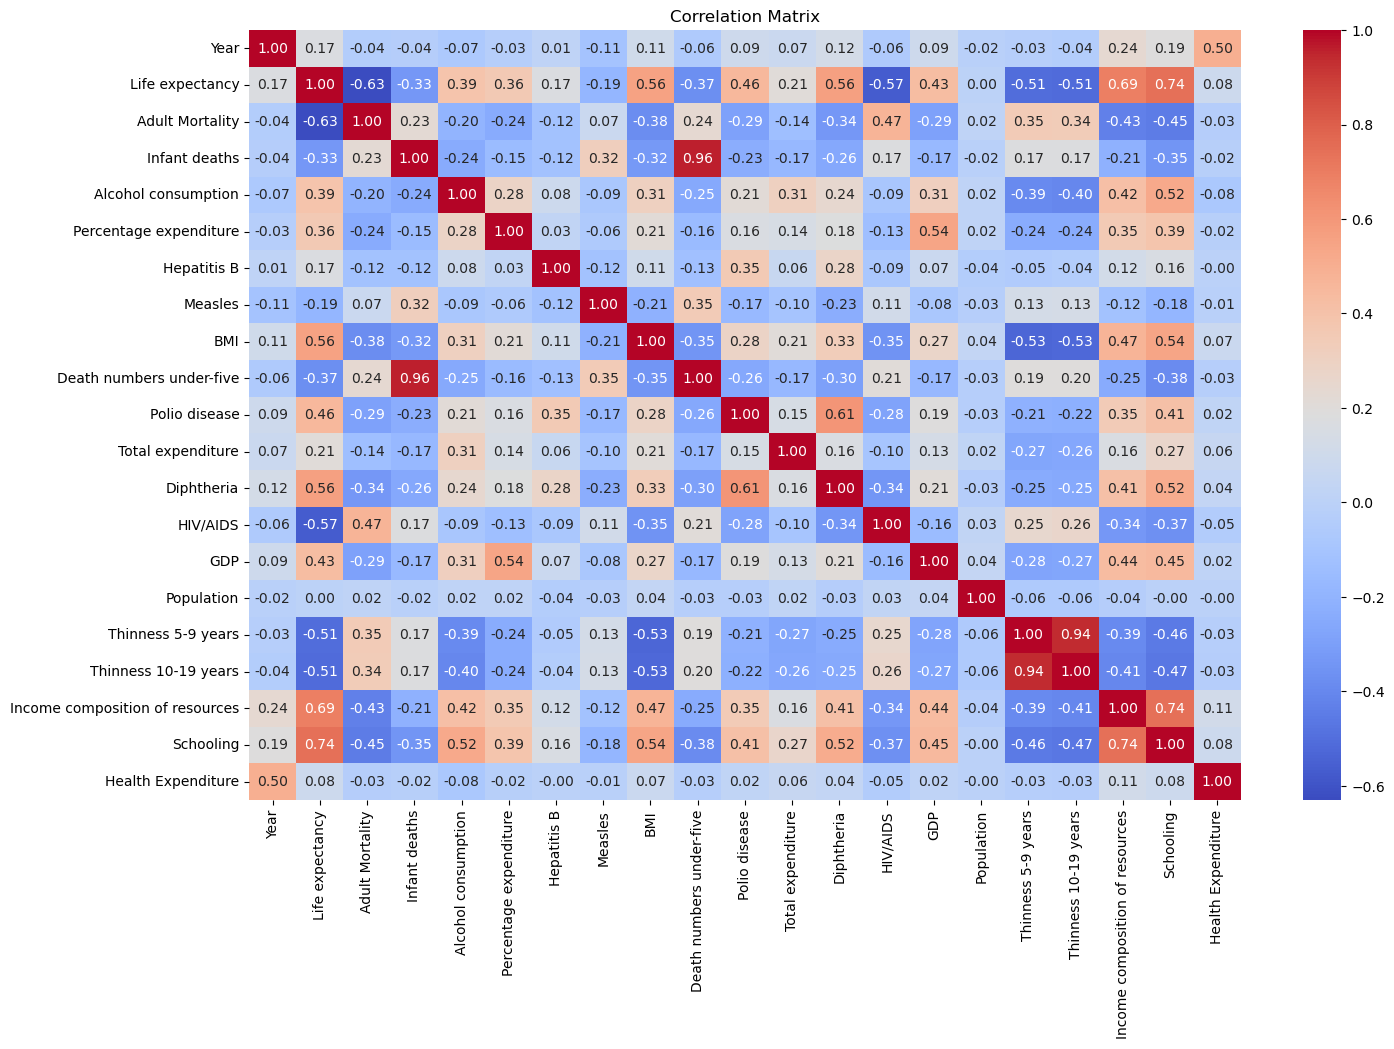

In [354]:
plt.figure(figsize=(16, 10))
sns.heatmap(mergedDataframe.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

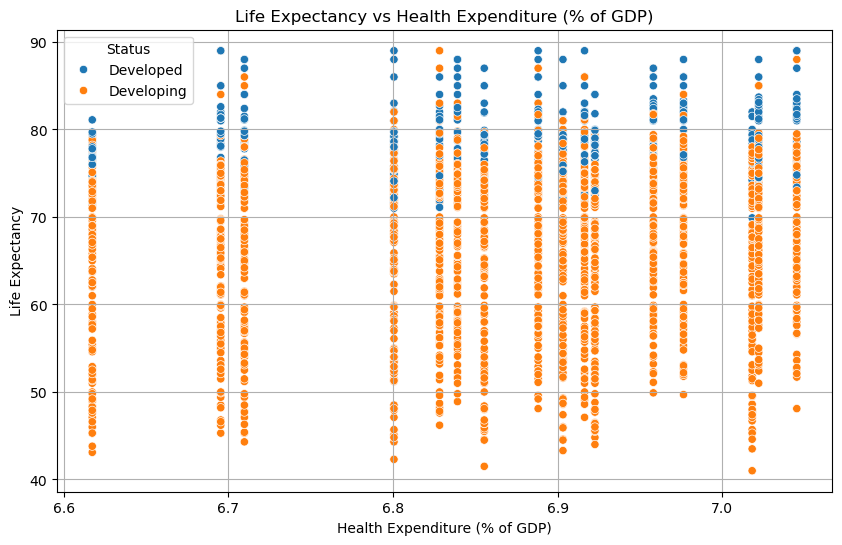

In [355]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mergedDataframe, x='Health Expenditure', y='Life expectancy', hue='Status')
plt.title('Life Expectancy vs Health Expenditure (% of GDP)')
plt.xlabel('Health Expenditure (% of GDP)')
plt.ylabel('Life Expectancy')
plt.grid(True)
plt.show()

##  Research Question

**What is the relationship between average years of schooling and life expectancy, and how does education influence other health outcomes such as infant mortality, under-five mortality, and disease prevalence?**

---

##  Data Insights Summary

Using the provided datasets, I explored how education correlates with various health indicators by visualizating the following figures:

1. **Correlation Heatmap**
2. **Scatter Plot: Life Expectancy vs Health Expenditure**

---

##  Key Findings

###  Education and Life Expectancy
- **Correlation Coefficient: 0.66**
- A strong **positive relationship** exists between schooling and life expectancy.
- More education leads to healthier decisions and better access to medical resources.

###  Infant & Child Mortality
- **Infant Mortality vs Schooling:** -0.58  
- **Under-5 Mortality vs Schooling:** -0.56  
- Education improves child care knowledge, prenatal care, and access to vaccination programs.

###  Disease Prevalence
- **HIV/AIDS Prevalence vs Schooling:** -0.56  
- **Hepatitis B vs Schooling:** -0.38  
- Educated populations are more aware of prevention strategies and safer health practices.

###  Health Expenditure and Life Expectancy
- Countries that spend more on health **tend to have higher life expectancy**.
- However, **education plays a crucial role** in maximizing the impact of that spending, especially in developing regions.

---

##  Conclusion

**Education saves lives.**  
Where higher schooling levels not only extend life expectancy but also significantly reduce mortality rates and disease spread. To improve public health _the investment in education is as vital_ as healthcare funding __especially__ in developing countries.